In [7]:
# Get the data for expeirment
import sklearn
import pandas as pd 
import numpy as np
import time

from sklearn import tree
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
from sklearn.metrics import explained_variance_score, mean_squared_error
from scipy.spatial.distance import cdist
from numpy.linalg import pinv
from math import sqrt

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import KFold
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import geopy.distance as distance
from sklearn.preprocessing import MinMaxScaler

import Data_utils
import matplotlib.ticker as ticker
from functools import reduce
from collections import Counter

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.inspection import PartialDependenceDisplay
from scikeras.wrappers import KerasRegressor
from sklearn.metrics import r2_score

import plotly.express as px
import TsModel
import GprModel
from sklearn.utils import validation
from windrose import WindroseAxes
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from tensorflow.keras import datasets, layers, models, losses
from matplotlib.projections import register_projection
from matplotlib.projections.polar import PolarAxes
from matplotlib.spines import Spine
from matplotlib.path import Path
from matplotlib.transforms import Affine2D
from matplotlib.patches import Circle, RegularPolygon

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [8]:
plt.rcParams.update({'font.size': 16})

In [9]:
# Source: From the TSmodel
def preprocess_data(train, validation):
    scaler = StandardScaler()
    train_data = scaler.fit_transform(train)
    validation_data = scaler.transform(validation)
    
    return train_data, validation_data

In [10]:
def linear_model(train_x, train_y, validation_x, validation_y):
    start_time = time.time()

    reg = LinearRegression().fit(train_x, train_y)
    
    time_used = time.time() - start_time
        
    train_pred = reg.predict(train_x)
    
    validation_pred = reg.predict(validation_x)
    
    print("linear train")
    print(mean_squared_error(train_y, train_pred, squared = False))
    
    print("linear_validation")
    print(mean_squared_error(validation_y, validation_pred, squared = False))
    
    return mean_squared_error(train_y, train_pred, squared = False), mean_squared_error(validation_y, validation_pred, squared = False), time_used

In [11]:
def build_neural_network_model():
    model = models.Sequential()
    model.add(layers.Dense(30, activation=tf.keras.activations.tanh))    
    model.add(layers.Dense(1, activation=tf.keras.activations.relu))    
    
    return model

In [12]:
def neural_network_model(train_x, train_y, validation_x, validation_y):
    start_time = time.time()
    
    neural_network_model = build_neural_network_model()
    
    neural_network_model.compile(
        optimizer='adam',
        loss=tf.keras.losses.MeanSquaredError(),
        metrics=[tf.keras.metrics.RootMeanSquaredError(), KerasRegressor.r_squared]
    )
    
    history = neural_network_model.fit(
        train_x, 
        train_y, 
        epochs=number_of_epochs, 
        validation_data=(validation_x, validation_y)
    )
    
    time_used = time.time() - start_time
    
    return history, np.mean(np.array(history.history['root_mean_squared_error'])), np.mean(np.array(history.history['val_root_mean_squared_error'])), neural_network_model, time_used

In [13]:
def fcm_rule_model(train_x, train_y, validation_x, validation_y):
    start_time = time.time()
    
    ts_model = TsModel.TsModel(number_of_rules=30, early_end_threshold=1e-8)
    _, rmse_train, _ = ts_model.fit(train_x,train_y)
    time_used = time.time() - start_time
    
    y_hat_validation = ts_model.predict(validation_x)
    rmse_validation = mean_squared_error(validation_y, y_hat_validation,squared=False)

    return rmse_train, rmse_validation, time_used

In [32]:
# hyperparameters for the expeirment
# This experiment is completed until 10 stations

number_of_neighbour_stations = [1,2,3,4,5,6,7,8,9, 10,11,12]
number_of_epochs = 50

# Expeirment related parameters
number_of_folds = 10 # have to be 10 fold

# Results containers
training_results = []
training_times = []
test_results = []
nn_histories = []
gpr_test_results = []

# Determine the optimal value for the given hyperparameter
def do_experiment(hyper_parameter_to_test_values):    
    for hyperparameter_value in hyper_parameter_to_test_values:
        # Station data is generated already, only need to train the model
        flatten_train_x = pd.read_csv(f"Data/exp/{hyperparameter_value}x.csv", index_col=0).to_numpy()
        flatten_train_y = pd.read_csv(f"Data/exp/{hyperparameter_value}y.csv", index_col=0)['0'].to_numpy().reshape(-1, 1)

        # Test data should still need to be generated
        flatten_test_x = pd.read_csv(f"Data/exp/{hyperparameter_value}x_test.csv", index_col=0).to_numpy()
        flatten_test_y = pd.read_csv(f"Data/exp/{hyperparameter_value}y_test.csv", index_col=0)['0'].to_numpy().reshape(-1, 1)

        # After all data are ready, do a 10 fold cross validation
        training_results_fold = []
        training_times_fold = []
        test_results_fold = []
        nn_history_fold = []
            
        for i in range(0, number_of_folds):
            flatten_train_x, flatten_train_y = shuffle(flatten_train_x, flatten_train_y)
    
            flatten_train_x = np.asarray(flatten_train_x).astype('float32')
            flatten_train_y = np.asarray(flatten_train_y).astype('float32')
            flatten_test_x = np.asarray(flatten_test_x).astype('float32')
            flatten_test_y = np.asarray(flatten_test_y).astype('float32')
            
            print(f"Currently running fold {i} for {hyperparameter_value} stations")

            # Normalize the input
            norm_flatten_train_x, norm_flatten_test_x = preprocess_data(flatten_train_x, flatten_test_x)            
            # Linear model
            li_train_rmse, li_val_rmse, li_train_time = linear_model(norm_flatten_train_x, flatten_train_y, norm_flatten_test_x , flatten_test_y)
            training_results_fold.append({'linear_train' : li_train_rmse})
            training_times_fold.append({'linear_train' : li_train_time})
            test_results_fold.append({'linear_test' : li_val_rmse})
            
            # FCM model
            fcm_train_rmse, fcm_val_rmse,fcm_train_time = fcm_rule_model(norm_flatten_train_x, flatten_train_y, norm_flatten_test_x , flatten_test_y)
            training_results_fold.append({'fcm_train' : fcm_train_rmse})
            training_times_fold.append({'fcm_train' : fcm_train_time})
            test_results_fold.append({'fcm_test' : fcm_val_rmse})
            
            # NN
            nn_history, nn_train_rmse, nn_val_rmse, nn_model, nn_train_time = neural_network_model(norm_flatten_train_x, flatten_train_y, norm_flatten_test_x , flatten_test_y)
            
            nn_test_prediction = nn_model.predict(flatten_test_x)
            # Record results
            nn_history_fold.append(nn_history.history)
            training_results_fold.append({'nn_train' : nn_train_rmse})
            training_times_fold.append({'nn_train' : nn_train_time})
            test_results_fold.append({'nn_test' : nn_val_rmse})
            
            #GP
            flatten_train_x_reshaped = flatten_train_x.reshape(20,-1, flatten_train_x.shape[-1])
            flatten_train_y_reshaped = flatten_train_y.reshape(20,-1, flatten_train_y.shape[-1])
            indices = np.random.choice(flatten_train_x_reshaped.shape[1], 200, replace=False)
            
            gpr_model = GprModel.GprModel()
            gpr_model.fit(np.vstack(flatten_train_x_reshaped[:,indices,:]), np.vstack(flatten_train_y_reshaped[:,indices,:].reshape(-1,1)))
            mean, rmse = gpr_model.predict(flatten_test_x, flatten_test_y)
            test_results_fold.append({'gpr_test' : np.mean(rmse)})
        
        #After all folds are done, update the result containers
        training_results.append(training_results_fold)
        training_times.append(training_times_fold)
        test_results.append(test_results_fold)
        nn_histories.append(nn_history_fold)        
        

In [33]:
do_experiment(number_of_neighbour_stations)

Currently running fold 0 for 1 stations
linear train
7.323052
linear_validation
7.3328376
FCM training RMSE: 7.066464081476167
Epoch 1/50
16697/16697 [==============================] - 32s 2ms/step - loss: 59.6495 - root_mean_squared_error: 7.7233 - r_squared: 0.2645 - val_loss: 53.2105 - val_root_mean_squared_error: 7.2946 - val_r_squared: -0.1310
Epoch 2/50
16697/16697 [==============================] - 32s 2ms/step - loss: 51.5776 - root_mean_squared_error: 7.1818 - r_squared: 0.3606 - val_loss: 51.0549 - val_root_mean_squared_error: 7.1453 - val_r_squared: -0.0954
Epoch 3/50
16697/16697 [==============================] - 33s 2ms/step - loss: 50.8281 - root_mean_squared_error: 7.1294 - r_squared: 0.3674 - val_loss: 50.9620 - val_root_mean_squared_error: 7.1388 - val_r_squared: -0.1220
Epoch 4/50
16697/16697 [==============================] - 31s 2ms/step - loss: 50.7437 - root_mean_squared_error: 7.1235 - r_squared: 0.3691 - val_loss: 50.9093 - val_root_mean_squared_error: 7.1351 - 

Epoch 37/50
16697/16697 [==============================] - 29s 2ms/step - loss: 50.4566 - root_mean_squared_error: 7.1033 - r_squared: 0.3724 - val_loss: 50.6672 - val_root_mean_squared_error: 7.1181 - val_r_squared: -0.0923
Epoch 38/50
16697/16697 [==============================] - 30s 2ms/step - loss: 50.4600 - root_mean_squared_error: 7.1035 - r_squared: 0.3703 - val_loss: 50.6368 - val_root_mean_squared_error: 7.1160 - val_r_squared: -0.1036
Epoch 39/50
16697/16697 [==============================] - 30s 2ms/step - loss: 50.4526 - root_mean_squared_error: 7.1030 - r_squared: 0.3708 - val_loss: 50.6782 - val_root_mean_squared_error: 7.1189 - val_r_squared: -0.0770
Epoch 40/50
16697/16697 [==============================] - 29s 2ms/step - loss: 50.4487 - root_mean_squared_error: 7.1027 - r_squared: 0.3714 - val_loss: 50.6096 - val_root_mean_squared_error: 7.1140 - val_r_squared: -0.1018
Epoch 41/50
16697/16697 [==============================] - 29s 2ms/step - loss: 50.4442 - root_mean_

E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\scipy\optimize\_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


[1. 1. 1.]
Root Mean Squared Error: 724.5124372800911
Currently running fold 1 for 1 stations
linear train
7.323051
linear_validation
7.3328366
FCM training RMSE: 7.070953132180979
Epoch 1/50
16697/16697 [==============================] - 30s 2ms/step - loss: 59.7160 - root_mean_squared_error: 7.7276 - r_squared: 0.2629 - val_loss: 54.1869 - val_root_mean_squared_error: 7.3612 - val_r_squared: -0.1491
Epoch 2/50
16697/16697 [==============================] - 29s 2ms/step - loss: 52.3245 - root_mean_squared_error: 7.2336 - r_squared: 0.3507 - val_loss: 51.3776 - val_root_mean_squared_error: 7.1678 - val_r_squared: -0.1170
Epoch 3/50
16697/16697 [==============================] - 30s 2ms/step - loss: 50.9038 - root_mean_squared_error: 7.1347 - r_squared: 0.3677 - val_loss: 50.9040 - val_root_mean_squared_error: 7.1347 - val_r_squared: -0.0938
Epoch 4/50
16697/16697 [==============================] - 30s 2ms/step - loss: 50.7568 - root_mean_squared_error: 7.1244 - r_squared: 0.3683 - val_

Epoch 37/50
16697/16697 [==============================] - 30s 2ms/step - loss: 49.8622 - root_mean_squared_error: 7.0613 - r_squared: 0.3815 - val_loss: 50.0359 - val_root_mean_squared_error: 7.0736 - val_r_squared: -0.0534
Epoch 38/50
16697/16697 [==============================] - 29s 2ms/step - loss: 49.8463 - root_mean_squared_error: 7.0602 - r_squared: 0.3803 - val_loss: 49.9985 - val_root_mean_squared_error: 7.0710 - val_r_squared: -0.0515
Epoch 39/50
16697/16697 [==============================] - 29s 2ms/step - loss: 49.8233 - root_mean_squared_error: 7.0586 - r_squared: 0.3804 - val_loss: 49.9883 - val_root_mean_squared_error: 7.0702 - val_r_squared: -0.0576
Epoch 40/50
16697/16697 [==============================] - 30s 2ms/step - loss: 49.8016 - root_mean_squared_error: 7.0570 - r_squared: 0.3815 - val_loss: 49.9679 - val_root_mean_squared_error: 7.0688 - val_r_squared: -0.0663
Epoch 41/50
16697/16697 [==============================] - 30s 2ms/step - loss: 49.7793 - root_mean_

E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\scipy\optimize\_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


[1. 1. 1.]
Root Mean Squared Error: 770.792600240156
Currently running fold 2 for 1 stations
linear train
7.3230515
linear_validation
7.3328366
FCM training RMSE: 7.0721530204018865
Epoch 1/50
16697/16697 [==============================] - 30s 2ms/step - loss: 59.7106 - root_mean_squared_error: 7.7273 - r_squared: 0.2630 - val_loss: 54.0541 - val_root_mean_squared_error: 7.3521 - val_r_squared: -0.1857
Epoch 2/50
16697/16697 [==============================] - 30s 2ms/step - loss: 51.9642 - root_mean_squared_error: 7.2086 - r_squared: 0.3543 - val_loss: 51.1085 - val_root_mean_squared_error: 7.1490 - val_r_squared: -0.1118
Epoch 3/50
16697/16697 [==============================] - 30s 2ms/step - loss: 50.8407 - root_mean_squared_error: 7.1303 - r_squared: 0.3673 - val_loss: 50.8896 - val_root_mean_squared_error: 7.1337 - val_r_squared: -0.1138
Epoch 4/50
16697/16697 [==============================] - 30s 2ms/step - loss: 50.7623 - root_mean_squared_error: 7.1248 - r_squared: 0.3676 - val

Epoch 37/50
16697/16697 [==============================] - 30s 2ms/step - loss: 50.3397 - root_mean_squared_error: 7.0950 - r_squared: 0.3738 - val_loss: 50.5507 - val_root_mean_squared_error: 7.1099 - val_r_squared: -0.0818
Epoch 38/50
16697/16697 [==============================] - 30s 2ms/step - loss: 50.3212 - root_mean_squared_error: 7.0937 - r_squared: 0.3732 - val_loss: 50.5059 - val_root_mean_squared_error: 7.1067 - val_r_squared: -0.0892
Epoch 39/50
16697/16697 [==============================] - 30s 2ms/step - loss: 50.3051 - root_mean_squared_error: 7.0926 - r_squared: 0.3737 - val_loss: 50.4943 - val_root_mean_squared_error: 7.1059 - val_r_squared: -0.0930
Epoch 40/50
16697/16697 [==============================] - 30s 2ms/step - loss: 50.2884 - root_mean_squared_error: 7.0914 - r_squared: 0.3749 - val_loss: 50.4579 - val_root_mean_squared_error: 7.1034 - val_r_squared: -0.0747
Epoch 41/50
16697/16697 [==============================] - 30s 2ms/step - loss: 50.2726 - root_mean_

E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\scipy\optimize\_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


[1. 1. 1.]
Root Mean Squared Error: 797.0349607214511
Currently running fold 3 for 1 stations
linear train
7.323052
linear_validation
7.3328376
FCM training RMSE: 7.075170874871426
Epoch 1/50
16697/16697 [==============================] - 30s 2ms/step - loss: 59.3677 - root_mean_squared_error: 7.7050 - r_squared: 0.2686 - val_loss: 53.6250 - val_root_mean_squared_error: 7.3229 - val_r_squared: -0.1512
Epoch 2/50
16697/16697 [==============================] - 30s 2ms/step - loss: 51.7746 - root_mean_squared_error: 7.1955 - r_squared: 0.3579 - val_loss: 51.1716 - val_root_mean_squared_error: 7.1534 - val_r_squared: -0.0985
Epoch 3/50
16697/16697 [==============================] - 30s 2ms/step - loss: 50.8830 - root_mean_squared_error: 7.1332 - r_squared: 0.3672 - val_loss: 50.9632 - val_root_mean_squared_error: 7.1388 - val_r_squared: -0.1258
Epoch 4/50
16697/16697 [==============================] - 30s 2ms/step - loss: 50.7521 - root_mean_squared_error: 7.1241 - r_squared: 0.3690 - val_

Epoch 37/50
16697/16697 [==============================] - 30s 2ms/step - loss: 50.4328 - root_mean_squared_error: 7.1016 - r_squared: 0.3714 - val_loss: 50.6057 - val_root_mean_squared_error: 7.1138 - val_r_squared: -0.0882
Epoch 38/50
16697/16697 [==============================] - 30s 2ms/step - loss: 50.4148 - root_mean_squared_error: 7.1003 - r_squared: 0.3728 - val_loss: 50.6126 - val_root_mean_squared_error: 7.1143 - val_r_squared: -0.0706
Epoch 39/50
16697/16697 [==============================] - 30s 2ms/step - loss: 50.3839 - root_mean_squared_error: 7.0982 - r_squared: 0.3730 - val_loss: 50.5245 - val_root_mean_squared_error: 7.1081 - val_r_squared: -0.0886
Epoch 40/50
16697/16697 [==============================] - 30s 2ms/step - loss: 50.3560 - root_mean_squared_error: 7.0962 - r_squared: 0.3731 - val_loss: 50.5205 - val_root_mean_squared_error: 7.1078 - val_r_squared: -0.0994
Epoch 41/50
16697/16697 [==============================] - 30s 2ms/step - loss: 50.3282 - root_mean_

E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\scipy\optimize\_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


[1. 1. 1.]
Root Mean Squared Error: 707.0465680487888
Currently running fold 4 for 1 stations
linear train
7.323052
linear_validation
7.3328376
FCM training RMSE: 7.069036934021693
Epoch 1/50
16697/16697 [==============================] - 30s 2ms/step - loss: 59.9361 - root_mean_squared_error: 7.7418 - r_squared: 0.2626 - val_loss: 53.5940 - val_root_mean_squared_error: 7.3208 - val_r_squared: -0.1592
Epoch 2/50
16697/16697 [==============================] - 30s 2ms/step - loss: 51.7426 - root_mean_squared_error: 7.1932 - r_squared: 0.3573 - val_loss: 51.0315 - val_root_mean_squared_error: 7.1436 - val_r_squared: -0.0970
Epoch 3/50
16697/16697 [==============================] - 29s 2ms/step - loss: 50.7972 - root_mean_squared_error: 7.1272 - r_squared: 0.3675 - val_loss: 50.9568 - val_root_mean_squared_error: 7.1384 - val_r_squared: -0.1280
Epoch 4/50
16697/16697 [==============================] - 30s 2ms/step - loss: 50.7277 - root_mean_squared_error: 7.1223 - r_squared: 0.3675 - val_

Epoch 37/50
16697/16697 [==============================] - 29s 2ms/step - loss: 50.4240 - root_mean_squared_error: 7.1010 - r_squared: 0.3726 - val_loss: 50.7112 - val_root_mean_squared_error: 7.1212 - val_r_squared: -0.0635
Epoch 38/50
16697/16697 [==============================] - 30s 2ms/step - loss: 50.4086 - root_mean_squared_error: 7.0999 - r_squared: 0.3727 - val_loss: 50.5653 - val_root_mean_squared_error: 7.1109 - val_r_squared: -0.0924
Epoch 39/50
16697/16697 [==============================] - 29s 2ms/step - loss: 50.3846 - root_mean_squared_error: 7.0982 - r_squared: 0.3735 - val_loss: 50.6848 - val_root_mean_squared_error: 7.1193 - val_r_squared: -0.0535
Epoch 40/50
16697/16697 [==============================] - 29s 2ms/step - loss: 50.3581 - root_mean_squared_error: 7.0963 - r_squared: 0.3734 - val_loss: 50.5035 - val_root_mean_squared_error: 7.1066 - val_r_squared: -0.0851
Epoch 41/50
16697/16697 [==============================] - 29s 2ms/step - loss: 50.3309 - root_mean_

E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\scipy\optimize\_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


[1. 1. 1.]
Root Mean Squared Error: 737.7197313470867
Currently running fold 5 for 1 stations
linear train
7.3230515
linear_validation
7.3328376
FCM training RMSE: 7.07344561104228
Epoch 1/50
16697/16697 [==============================] - 30s 2ms/step - loss: 59.6681 - root_mean_squared_error: 7.7245 - r_squared: 0.2633 - val_loss: 53.7823 - val_root_mean_squared_error: 7.3336 - val_r_squared: -0.1600
Epoch 2/50
16697/16697 [==============================] - 30s 2ms/step - loss: 51.9302 - root_mean_squared_error: 7.2063 - r_squared: 0.3552 - val_loss: 51.3692 - val_root_mean_squared_error: 7.1672 - val_r_squared: -0.0830
Epoch 3/50
16697/16697 [==============================] - 30s 2ms/step - loss: 50.8733 - root_mean_squared_error: 7.1326 - r_squared: 0.3672 - val_loss: 50.9697 - val_root_mean_squared_error: 7.1393 - val_r_squared: -0.0938
Epoch 4/50
16697/16697 [==============================] - 30s 2ms/step - loss: 50.7752 - root_mean_squared_error: 7.1257 - r_squared: 0.3669 - val_

Epoch 37/50
16697/16697 [==============================] - 29s 2ms/step - loss: 50.4520 - root_mean_squared_error: 7.1030 - r_squared: 0.3720 - val_loss: 50.6335 - val_root_mean_squared_error: 7.1157 - val_r_squared: -0.0898
Epoch 38/50
16697/16697 [==============================] - 30s 2ms/step - loss: 50.4431 - root_mean_squared_error: 7.1023 - r_squared: 0.3728 - val_loss: 50.6193 - val_root_mean_squared_error: 7.1147 - val_r_squared: -0.0902
Epoch 39/50
16697/16697 [==============================] - 30s 2ms/step - loss: 50.4386 - root_mean_squared_error: 7.1020 - r_squared: 0.3717 - val_loss: 50.6062 - val_root_mean_squared_error: 7.1138 - val_r_squared: -0.0881
Epoch 40/50
16697/16697 [==============================] - 30s 2ms/step - loss: 50.4276 - root_mean_squared_error: 7.1012 - r_squared: 0.3735 - val_loss: 50.6204 - val_root_mean_squared_error: 7.1148 - val_r_squared: -0.1045
Epoch 41/50
16697/16697 [==============================] - 30s 2ms/step - loss: 50.4210 - root_mean_

E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\scipy\optimize\_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


[1. 1. 1.]
Root Mean Squared Error: 792.8331254409234
Currently running fold 6 for 1 stations
linear train
7.3230515
linear_validation
7.3328376
FCM training RMSE: 7.073410828322179
Epoch 1/50
16697/16697 [==============================] - 30s 2ms/step - loss: 58.8786 - root_mean_squared_error: 7.6732 - r_squared: 0.2736 - val_loss: 52.1568 - val_root_mean_squared_error: 7.2220 - val_r_squared: -0.1306
Epoch 2/50
16697/16697 [==============================] - 30s 2ms/step - loss: 51.2601 - root_mean_squared_error: 7.1596 - r_squared: 0.3632 - val_loss: 51.0277 - val_root_mean_squared_error: 7.1434 - val_r_squared: -0.0913
Epoch 3/50
16697/16697 [==============================] - 29s 2ms/step - loss: 50.8521 - root_mean_squared_error: 7.1311 - r_squared: 0.3670 - val_loss: 51.0007 - val_root_mean_squared_error: 7.1415 - val_r_squared: -0.0969
Epoch 4/50
16697/16697 [==============================] - 29s 2ms/step - loss: 50.8066 - root_mean_squared_error: 7.1279 - r_squared: 0.3683 - val

Epoch 37/50
16697/16697 [==============================] - 29s 2ms/step - loss: 50.4987 - root_mean_squared_error: 7.1062 - r_squared: 0.3712 - val_loss: 50.7272 - val_root_mean_squared_error: 7.1223 - val_r_squared: -0.0830
Epoch 38/50
16697/16697 [==============================] - 29s 2ms/step - loss: 50.4893 - root_mean_squared_error: 7.1056 - r_squared: 0.3717 - val_loss: 50.7226 - val_root_mean_squared_error: 7.1220 - val_r_squared: -0.0977
Epoch 39/50
16697/16697 [==============================] - 30s 2ms/step - loss: 50.4905 - root_mean_squared_error: 7.1057 - r_squared: 0.3710 - val_loss: 50.7358 - val_root_mean_squared_error: 7.1229 - val_r_squared: -0.0757
Epoch 40/50
16697/16697 [==============================] - 29s 2ms/step - loss: 50.4829 - root_mean_squared_error: 7.1051 - r_squared: 0.3711 - val_loss: 50.6516 - val_root_mean_squared_error: 7.1170 - val_r_squared: -0.0982
Epoch 41/50
16697/16697 [==============================] - 30s 2ms/step - loss: 50.4592 - root_mean_

E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\scipy\optimize\_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


[1. 1. 1.]
Root Mean Squared Error: 1519.760755792719
Currently running fold 7 for 1 stations
linear train
7.323051
linear_validation
7.3328366
FCM training RMSE: 7.071347378592103
Epoch 1/50
16697/16697 [==============================] - 30s 2ms/step - loss: 59.5467 - root_mean_squared_error: 7.7167 - r_squared: 0.2646 - val_loss: 54.0371 - val_root_mean_squared_error: 7.3510 - val_r_squared: -0.1823
Epoch 2/50
16697/16697 [==============================] - 29s 2ms/step - loss: 51.9299 - root_mean_squared_error: 7.2062 - r_squared: 0.3556 - val_loss: 51.3389 - val_root_mean_squared_error: 7.1651 - val_r_squared: -0.1220
Epoch 3/50
16697/16697 [==============================] - 30s 2ms/step - loss: 50.8824 - root_mean_squared_error: 7.1332 - r_squared: 0.3664 - val_loss: 50.8956 - val_root_mean_squared_error: 7.1341 - val_r_squared: -0.1047
Epoch 4/50
16697/16697 [==============================] - 30s 2ms/step - loss: 50.7543 - root_mean_squared_error: 7.1242 - r_squared: 0.3686 - val_

Epoch 37/50
16697/16697 [==============================] - 30s 2ms/step - loss: 50.4263 - root_mean_squared_error: 7.1011 - r_squared: 0.3723 - val_loss: 50.7151 - val_root_mean_squared_error: 7.1215 - val_r_squared: -0.0722
Epoch 38/50
16697/16697 [==============================] - 30s 2ms/step - loss: 50.4085 - root_mean_squared_error: 7.0999 - r_squared: 0.3733 - val_loss: 50.6503 - val_root_mean_squared_error: 7.1169 - val_r_squared: -0.0670
Epoch 39/50
16697/16697 [==============================] - 30s 2ms/step - loss: 50.3780 - root_mean_squared_error: 7.0977 - r_squared: 0.3744 - val_loss: 50.5523 - val_root_mean_squared_error: 7.1100 - val_r_squared: -0.0940
Epoch 40/50
16697/16697 [==============================] - 30s 2ms/step - loss: 50.3545 - root_mean_squared_error: 7.0961 - r_squared: 0.3739 - val_loss: 50.5807 - val_root_mean_squared_error: 7.1120 - val_r_squared: -0.1103
Epoch 41/50
16697/16697 [==============================] - 30s 2ms/step - loss: 50.3371 - root_mean_

E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\scipy\optimize\_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


[1. 1. 1.]
Root Mean Squared Error: 919.9682754501165
Currently running fold 8 for 1 stations
linear train
7.3230515
linear_validation
7.3328376
FCM training RMSE: 7.073945876399935
Epoch 1/50
16697/16697 [==============================] - 30s 2ms/step - loss: 58.7088 - root_mean_squared_error: 7.6622 - r_squared: 0.2751 - val_loss: 51.5902 - val_root_mean_squared_error: 7.1826 - val_r_squared: -0.1117
Epoch 2/50
16697/16697 [==============================] - 30s 2ms/step - loss: 51.3225 - root_mean_squared_error: 7.1640 - r_squared: 0.3622 - val_loss: 51.3981 - val_root_mean_squared_error: 7.1692 - val_r_squared: -0.0830
Epoch 3/50
16697/16697 [==============================] - 29s 2ms/step - loss: 51.1714 - root_mean_squared_error: 7.1534 - r_squared: 0.3643 - val_loss: 51.2452 - val_root_mean_squared_error: 7.1586 - val_r_squared: -0.1071
Epoch 4/50
16697/16697 [==============================] - 30s 2ms/step - loss: 50.8981 - root_mean_squared_error: 7.1343 - r_squared: 0.3667 - val

Epoch 37/50
16697/16697 [==============================] - 30s 2ms/step - loss: 50.4791 - root_mean_squared_error: 7.1049 - r_squared: 0.3720 - val_loss: 50.6845 - val_root_mean_squared_error: 7.1193 - val_r_squared: -0.0790
Epoch 38/50
16697/16697 [==============================] - 30s 2ms/step - loss: 50.4743 - root_mean_squared_error: 7.1045 - r_squared: 0.3729 - val_loss: 50.6711 - val_root_mean_squared_error: 7.1184 - val_r_squared: -0.0824
Epoch 39/50
16697/16697 [==============================] - 29s 2ms/step - loss: 50.4720 - root_mean_squared_error: 7.1044 - r_squared: 0.3720 - val_loss: 50.6352 - val_root_mean_squared_error: 7.1158 - val_r_squared: -0.0955
Epoch 40/50
16697/16697 [==============================] - 30s 2ms/step - loss: 50.4669 - root_mean_squared_error: 7.1040 - r_squared: 0.3712 - val_loss: 50.6469 - val_root_mean_squared_error: 7.1167 - val_r_squared: -0.0985
Epoch 41/50
16697/16697 [==============================] - 30s 2ms/step - loss: 50.4606 - root_mean_

E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\scipy\optimize\_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


[1. 1. 1.]
Root Mean Squared Error: 795.6282040241531
Currently running fold 9 for 1 stations
linear train
7.3230515
linear_validation
7.3328376
FCM training RMSE: 7.074173264018286
Epoch 1/50
16697/16697 [==============================] - 30s 2ms/step - loss: 58.6229 - root_mean_squared_error: 7.6566 - r_squared: 0.2770 - val_loss: 51.6440 - val_root_mean_squared_error: 7.1864 - val_r_squared: -0.1225
Epoch 2/50
16697/16697 [==============================] - 29s 2ms/step - loss: 51.0895 - root_mean_squared_error: 7.1477 - r_squared: 0.3642 - val_loss: 51.0492 - val_root_mean_squared_error: 7.1449 - val_r_squared: -0.1137
Epoch 3/50
16697/16697 [==============================] - 30s 2ms/step - loss: 50.8488 - root_mean_squared_error: 7.1308 - r_squared: 0.3674 - val_loss: 50.9429 - val_root_mean_squared_error: 7.1374 - val_r_squared: -0.1077
Epoch 4/50
16697/16697 [==============================] - 29s 2ms/step - loss: 50.8024 - root_mean_squared_error: 7.1276 - r_squared: 0.3680 - val

Epoch 37/50
16697/16697 [==============================] - 29s 2ms/step - loss: 50.4685 - root_mean_squared_error: 7.1041 - r_squared: 0.3714 - val_loss: 50.6426 - val_root_mean_squared_error: 7.1164 - val_r_squared: -0.0904
Epoch 38/50
16697/16697 [==============================] - 30s 2ms/step - loss: 50.4682 - root_mean_squared_error: 7.1041 - r_squared: 0.3731 - val_loss: 50.6306 - val_root_mean_squared_error: 7.1155 - val_r_squared: -0.0953
Epoch 39/50
16697/16697 [==============================] - 30s 2ms/step - loss: 50.4652 - root_mean_squared_error: 7.1039 - r_squared: 0.3718 - val_loss: 50.6518 - val_root_mean_squared_error: 7.1170 - val_r_squared: -0.1100
Epoch 40/50
16697/16697 [==============================] - 30s 2ms/step - loss: 50.4594 - root_mean_squared_error: 7.1035 - r_squared: 0.3724 - val_loss: 50.7109 - val_root_mean_squared_error: 7.1212 - val_r_squared: -0.0807
Epoch 41/50
16697/16697 [==============================] - 30s 2ms/step - loss: 50.4533 - root_mean_

E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\scipy\optimize\_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


[1. 1. 1.]
Root Mean Squared Error: 669.6921753605732
Currently running fold 0 for 2 stations
linear train
7.173171
linear_validation
7.180802
FCM training RMSE: 6.593923872948165
Epoch 1/50
16697/16697 [==============================] - 30s 2ms/step - loss: 56.0529 - root_mean_squared_error: 7.4868 - r_squared: 0.3101 - val_loss: 47.1784 - val_root_mean_squared_error: 6.8687 - val_r_squared: 0.0691
Epoch 2/50
16697/16697 [==============================] - 30s 2ms/step - loss: 46.3187 - root_mean_squared_error: 6.8058 - r_squared: 0.4238 - val_loss: 45.6148 - val_root_mean_squared_error: 6.7539 - val_r_squared: 0.1036
Epoch 3/50
16697/16697 [==============================] - 30s 2ms/step - loss: 45.2237 - root_mean_squared_error: 6.7249 - r_squared: 0.4377 - val_loss: 44.8123 - val_root_mean_squared_error: 6.6942 - val_r_squared: 0.1245
Epoch 4/50
16697/16697 [==============================] - 30s 2ms/step - loss: 44.5189 - root_mean_squared_error: 6.6723 - r_squared: 0.4448 - val_loss

Epoch 37/50
16697/16697 [==============================] - 30s 2ms/step - loss: 39.8320 - root_mean_squared_error: 6.3113 - r_squared: 0.5011 - val_loss: 39.7365 - val_root_mean_squared_error: 6.3037 - val_r_squared: 0.2444
Epoch 38/50
16697/16697 [==============================] - 30s 2ms/step - loss: 39.7536 - root_mean_squared_error: 6.3050 - r_squared: 0.5023 - val_loss: 39.6771 - val_root_mean_squared_error: 6.2990 - val_r_squared: 0.2432
Epoch 39/50
16697/16697 [==============================] - 30s 2ms/step - loss: 39.6840 - root_mean_squared_error: 6.2995 - r_squared: 0.5037 - val_loss: 39.6482 - val_root_mean_squared_error: 6.2967 - val_r_squared: 0.2513
Epoch 40/50
16697/16697 [==============================] - 30s 2ms/step - loss: 39.6077 - root_mean_squared_error: 6.2935 - r_squared: 0.5033 - val_loss: 39.6204 - val_root_mean_squared_error: 6.2945 - val_r_squared: 0.2567
Epoch 41/50
16697/16697 [==============================] - 30s 2ms/step - loss: 39.5383 - root_mean_squa

E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\scipy\optimize\_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


[1. 1. 1.]
Root Mean Squared Error: 1082.5419177649085
Currently running fold 1 for 2 stations
linear train
7.173171
linear_validation
7.1808023
FCM training RMSE: 6.583829665844238
Epoch 1/50
16697/16697 [==============================] - 30s 2ms/step - loss: 55.7590 - root_mean_squared_error: 7.4672 - r_squared: 0.3136 - val_loss: 46.8172 - val_root_mean_squared_error: 6.8423 - val_r_squared: 0.0633
Epoch 2/50
16697/16697 [==============================] - 29s 2ms/step - loss: 45.8737 - root_mean_squared_error: 6.7730 - r_squared: 0.4299 - val_loss: 45.4098 - val_root_mean_squared_error: 6.7387 - val_r_squared: 0.0785
Epoch 3/50
16697/16697 [==============================] - 30s 2ms/step - loss: 45.0269 - root_mean_squared_error: 6.7102 - r_squared: 0.4402 - val_loss: 44.7862 - val_root_mean_squared_error: 6.6923 - val_r_squared: 0.1302
Epoch 4/50
16697/16697 [==============================] - 30s 2ms/step - loss: 44.5297 - root_mean_squared_error: 6.6731 - r_squared: 0.4459 - val_lo

Epoch 37/50
16697/16697 [==============================] - 30s 2ms/step - loss: 39.2385 - root_mean_squared_error: 6.2641 - r_squared: 0.5084 - val_loss: 39.3799 - val_root_mean_squared_error: 6.2753 - val_r_squared: 0.2568
Epoch 38/50
16697/16697 [==============================] - 30s 2ms/step - loss: 39.1824 - root_mean_squared_error: 6.2596 - r_squared: 0.5096 - val_loss: 39.1494 - val_root_mean_squared_error: 6.2569 - val_r_squared: 0.2553
Epoch 39/50
16697/16697 [==============================] - 30s 2ms/step - loss: 39.1162 - root_mean_squared_error: 6.2543 - r_squared: 0.5103 - val_loss: 39.1064 - val_root_mean_squared_error: 6.2535 - val_r_squared: 0.2510
Epoch 40/50
16697/16697 [==============================] - 30s 2ms/step - loss: 39.0731 - root_mean_squared_error: 6.2508 - r_squared: 0.5104 - val_loss: 39.0725 - val_root_mean_squared_error: 6.2508 - val_r_squared: 0.2500
Epoch 41/50
16697/16697 [==============================] - 30s 2ms/step - loss: 39.0246 - root_mean_squa

E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\scipy\optimize\_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


[1. 1. 1.]
Root Mean Squared Error: 809.9073950646548
Currently running fold 2 for 2 stations
linear train
7.17317
linear_validation
7.1808023
FCM training RMSE: 6.58799816220275
Epoch 1/50
16697/16697 [==============================] - 30s 2ms/step - loss: 56.3049 - root_mean_squared_error: 7.5037 - r_squared: 0.3081 - val_loss: 47.3647 - val_root_mean_squared_error: 6.8822 - val_r_squared: 0.0597
Epoch 2/50
16697/16697 [==============================] - 29s 2ms/step - loss: 46.1908 - root_mean_squared_error: 6.7964 - r_squared: 0.4275 - val_loss: 45.4944 - val_root_mean_squared_error: 6.7450 - val_r_squared: 0.1065
Epoch 3/50
16697/16697 [==============================] - 30s 2ms/step - loss: 45.0842 - root_mean_squared_error: 6.7145 - r_squared: 0.4395 - val_loss: 44.9181 - val_root_mean_squared_error: 6.7021 - val_r_squared: 0.1261
Epoch 4/50
16697/16697 [==============================] - 30s 2ms/step - loss: 44.5228 - root_mean_squared_error: 6.6725 - r_squared: 0.4449 - val_loss:

Epoch 37/50
16697/16697 [==============================] - 30s 2ms/step - loss: 39.1951 - root_mean_squared_error: 6.2606 - r_squared: 0.5082 - val_loss: 39.2326 - val_root_mean_squared_error: 6.2636 - val_r_squared: 0.2643
Epoch 38/50
16697/16697 [==============================] - 30s 2ms/step - loss: 39.1150 - root_mean_squared_error: 6.2542 - r_squared: 0.5104 - val_loss: 39.1301 - val_root_mean_squared_error: 6.2554 - val_r_squared: 0.2561
Epoch 39/50
16697/16697 [==============================] - 29s 2ms/step - loss: 39.0496 - root_mean_squared_error: 6.2490 - r_squared: 0.5117 - val_loss: 39.0372 - val_root_mean_squared_error: 6.2480 - val_r_squared: 0.2533
Epoch 40/50
16697/16697 [==============================] - 30s 2ms/step - loss: 38.9906 - root_mean_squared_error: 6.2442 - r_squared: 0.5116 - val_loss: 39.0658 - val_root_mean_squared_error: 6.2503 - val_r_squared: 0.2546
Epoch 41/50
16697/16697 [==============================] - 30s 2ms/step - loss: 38.9400 - root_mean_squa

E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\scipy\optimize\_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


[1. 1. 1.]
Root Mean Squared Error: 466.50585757166857
Currently running fold 3 for 2 stations
linear train
7.1731706
linear_validation
7.1808023
FCM training RMSE: 6.59423795060907
Epoch 1/50
16697/16697 [==============================] - 30s 2ms/step - loss: 56.5603 - root_mean_squared_error: 7.5207 - r_squared: 0.3036 - val_loss: 47.1451 - val_root_mean_squared_error: 6.8662 - val_r_squared: 0.0712
Epoch 2/50
16697/16697 [==============================] - 30s 2ms/step - loss: 45.9295 - root_mean_squared_error: 6.7771 - r_squared: 0.4292 - val_loss: 45.3227 - val_root_mean_squared_error: 6.7322 - val_r_squared: 0.1248
Epoch 3/50
16697/16697 [==============================] - 30s 2ms/step - loss: 44.8381 - root_mean_squared_error: 6.6961 - r_squared: 0.4411 - val_loss: 44.5789 - val_root_mean_squared_error: 6.6767 - val_r_squared: 0.1391
Epoch 4/50
16697/16697 [==============================] - 30s 2ms/step - loss: 44.3833 - root_mean_squared_error: 6.6621 - r_squared: 0.4460 - val_lo

Epoch 37/50
16697/16697 [==============================] - 30s 2ms/step - loss: 39.0038 - root_mean_squared_error: 6.2453 - r_squared: 0.5117 - val_loss: 39.1604 - val_root_mean_squared_error: 6.2578 - val_r_squared: 0.2659
Epoch 38/50
16697/16697 [==============================] - 30s 2ms/step - loss: 38.9480 - root_mean_squared_error: 6.2408 - r_squared: 0.5115 - val_loss: 38.9745 - val_root_mean_squared_error: 6.2430 - val_r_squared: 0.2615
Epoch 39/50
16697/16697 [==============================] - 30s 2ms/step - loss: 38.9034 - root_mean_squared_error: 6.2373 - r_squared: 0.5122 - val_loss: 39.0848 - val_root_mean_squared_error: 6.2518 - val_r_squared: 0.2743
Epoch 40/50
16697/16697 [==============================] - 29s 2ms/step - loss: 38.8515 - root_mean_squared_error: 6.2331 - r_squared: 0.5134 - val_loss: 38.8582 - val_root_mean_squared_error: 6.2336 - val_r_squared: 0.2735
Epoch 41/50
16697/16697 [==============================] - 29s 2ms/step - loss: 38.8123 - root_mean_squa

E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\scipy\optimize\_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


[1. 1. 1.]
Root Mean Squared Error: 787.421354909558
Currently running fold 4 for 2 stations
linear train
7.173171
linear_validation
7.1808014
FCM training RMSE: 6.586335873036193
Epoch 1/50
16697/16697 [==============================] - 30s 2ms/step - loss: 55.9969 - root_mean_squared_error: 7.4831 - r_squared: 0.3101 - val_loss: 47.4902 - val_root_mean_squared_error: 6.8913 - val_r_squared: 0.0291
Epoch 2/50
16697/16697 [==============================] - 30s 2ms/step - loss: 45.8898 - root_mean_squared_error: 6.7742 - r_squared: 0.4311 - val_loss: 45.0385 - val_root_mean_squared_error: 6.7111 - val_r_squared: 0.1404
Epoch 3/50
16697/16697 [==============================] - 30s 2ms/step - loss: 44.6836 - root_mean_squared_error: 6.6846 - r_squared: 0.4443 - val_loss: 44.3502 - val_root_mean_squared_error: 6.6596 - val_r_squared: 0.1336
Epoch 4/50
16697/16697 [==============================] - 30s 2ms/step - loss: 44.1603 - root_mean_squared_error: 6.6453 - r_squared: 0.4497 - val_loss

Epoch 37/50
16697/16697 [==============================] - 29s 2ms/step - loss: 38.8665 - root_mean_squared_error: 6.2343 - r_squared: 0.5124 - val_loss: 39.1344 - val_root_mean_squared_error: 6.2558 - val_r_squared: 0.2732
Epoch 38/50
16697/16697 [==============================] - 29s 2ms/step - loss: 38.8156 - root_mean_squared_error: 6.2302 - r_squared: 0.5139 - val_loss: 38.8473 - val_root_mean_squared_error: 6.2328 - val_r_squared: 0.2596
Epoch 39/50
16697/16697 [==============================] - 30s 2ms/step - loss: 38.7768 - root_mean_squared_error: 6.2271 - r_squared: 0.5137 - val_loss: 38.8184 - val_root_mean_squared_error: 6.2304 - val_r_squared: 0.2637
Epoch 40/50
16697/16697 [==============================] - 30s 2ms/step - loss: 38.7347 - root_mean_squared_error: 6.2237 - r_squared: 0.5141 - val_loss: 38.8022 - val_root_mean_squared_error: 6.2291 - val_r_squared: 0.2536
Epoch 41/50
16697/16697 [==============================] - 30s 2ms/step - loss: 38.7028 - root_mean_squa

E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\scipy\optimize\_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


[1. 1. 1.]
Root Mean Squared Error: 1622.7176957049076
Currently running fold 5 for 2 stations
linear train
7.1731706
linear_validation
7.1808023
FCM training RMSE: 6.5767390819505716
Epoch 1/50
16697/16697 [==============================] - 29s 2ms/step - loss: 55.9351 - root_mean_squared_error: 7.4790 - r_squared: 0.3086 - val_loss: 47.3049 - val_root_mean_squared_error: 6.8779 - val_r_squared: 0.0532
Epoch 2/50
16697/16697 [==============================] - 30s 2ms/step - loss: 46.6956 - root_mean_squared_error: 6.8334 - r_squared: 0.4194 - val_loss: 46.2021 - val_root_mean_squared_error: 6.7972 - val_r_squared: 0.0703
Epoch 3/50
16697/16697 [==============================] - 30s 2ms/step - loss: 45.5841 - root_mean_squared_error: 6.7516 - r_squared: 0.4333 - val_loss: 45.1864 - val_root_mean_squared_error: 6.7221 - val_r_squared: 0.0925
Epoch 4/50
16697/16697 [==============================] - 30s 2ms/step - loss: 44.6925 - root_mean_squared_error: 6.6852 - r_squared: 0.4433 - val_

Epoch 37/50
16697/16697 [==============================] - 30s 2ms/step - loss: 40.5557 - root_mean_squared_error: 6.3683 - r_squared: 0.4929 - val_loss: 40.5838 - val_root_mean_squared_error: 6.3705 - val_r_squared: 0.2085
Epoch 38/50
16697/16697 [==============================] - 30s 2ms/step - loss: 40.4019 - root_mean_squared_error: 6.3563 - r_squared: 0.4960 - val_loss: 40.3806 - val_root_mean_squared_error: 6.3546 - val_r_squared: 0.2268
Epoch 39/50
16697/16697 [==============================] - 30s 2ms/step - loss: 40.2082 - root_mean_squared_error: 6.3410 - r_squared: 0.4974 - val_loss: 40.1444 - val_root_mean_squared_error: 6.3360 - val_r_squared: 0.2299
Epoch 40/50
16697/16697 [==============================] - 30s 2ms/step - loss: 40.0216 - root_mean_squared_error: 6.3263 - r_squared: 0.5001 - val_loss: 39.9471 - val_root_mean_squared_error: 6.3204 - val_r_squared: 0.2425
Epoch 41/50
16697/16697 [==============================] - 30s 2ms/step - loss: 39.8641 - root_mean_squa

E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\scipy\optimize\_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


[1. 1. 1.]
Root Mean Squared Error: 829.6305748225418
Currently running fold 6 for 2 stations
linear train
7.1731706
linear_validation
7.180802
FCM training RMSE: 6.597069558752762
Epoch 1/50
16697/16697 [==============================] - 30s 2ms/step - loss: 56.2268 - root_mean_squared_error: 7.4985 - r_squared: 0.3054 - val_loss: 47.7272 - val_root_mean_squared_error: 6.9085 - val_r_squared: 0.0318
Epoch 2/50
16697/16697 [==============================] - 30s 2ms/step - loss: 46.2228 - root_mean_squared_error: 6.7987 - r_squared: 0.4260 - val_loss: 45.6678 - val_root_mean_squared_error: 6.7578 - val_r_squared: 0.0802
Epoch 3/50
16697/16697 [==============================] - 29s 2ms/step - loss: 44.9584 - root_mean_squared_error: 6.7051 - r_squared: 0.4405 - val_loss: 44.5712 - val_root_mean_squared_error: 6.6762 - val_r_squared: 0.1350
Epoch 4/50
16697/16697 [==============================] - 29s 2ms/step - loss: 44.4029 - root_mean_squared_error: 6.6636 - r_squared: 0.4458 - val_los

Epoch 37/50
16697/16697 [==============================] - 30s 2ms/step - loss: 39.3739 - root_mean_squared_error: 6.2749 - r_squared: 0.5067 - val_loss: 39.4783 - val_root_mean_squared_error: 6.2832 - val_r_squared: 0.2677
Epoch 38/50
16697/16697 [==============================] - 29s 2ms/step - loss: 39.2990 - root_mean_squared_error: 6.2689 - r_squared: 0.5078 - val_loss: 39.3920 - val_root_mean_squared_error: 6.2763 - val_r_squared: 0.2518
Epoch 39/50
16697/16697 [==============================] - 30s 2ms/step - loss: 39.2245 - root_mean_squared_error: 6.2629 - r_squared: 0.5082 - val_loss: 39.3427 - val_root_mean_squared_error: 6.2724 - val_r_squared: 0.2711
Epoch 40/50
16697/16697 [==============================] - 29s 2ms/step - loss: 39.1693 - root_mean_squared_error: 6.2585 - r_squared: 0.5094 - val_loss: 39.1511 - val_root_mean_squared_error: 6.2571 - val_r_squared: 0.2638
Epoch 41/50
16697/16697 [==============================] - 29s 2ms/step - loss: 39.0975 - root_mean_squa

E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\scipy\optimize\_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


[1. 1. 1.]
Root Mean Squared Error: 939.5128993431122
Currently running fold 7 for 2 stations
linear train
7.1731696
linear_validation
7.1808014
FCM training RMSE: 6.591735219723195
Epoch 1/50
16697/16697 [==============================] - 30s 2ms/step - loss: 57.1407 - root_mean_squared_error: 7.5591 - r_squared: 0.2972 - val_loss: 48.0706 - val_root_mean_squared_error: 6.9333 - val_r_squared: 0.0534
Epoch 2/50
16697/16697 [==============================] - 30s 2ms/step - loss: 46.1925 - root_mean_squared_error: 6.7965 - r_squared: 0.4271 - val_loss: 45.2889 - val_root_mean_squared_error: 6.7297 - val_r_squared: 0.1340
Epoch 3/50
16697/16697 [==============================] - 30s 2ms/step - loss: 44.7996 - root_mean_squared_error: 6.6932 - r_squared: 0.4421 - val_loss: 44.6785 - val_root_mean_squared_error: 6.6842 - val_r_squared: 0.1587
Epoch 4/50
16697/16697 [==============================] - 30s 2ms/step - loss: 44.3395 - root_mean_squared_error: 6.6588 - r_squared: 0.4476 - val_lo

Epoch 37/50
16697/16697 [==============================] - 29s 2ms/step - loss: 38.9611 - root_mean_squared_error: 6.2419 - r_squared: 0.5115 - val_loss: 39.0673 - val_root_mean_squared_error: 6.2504 - val_r_squared: 0.2510
Epoch 38/50
16697/16697 [==============================] - 30s 2ms/step - loss: 38.9035 - root_mean_squared_error: 6.2373 - r_squared: 0.5124 - val_loss: 39.0330 - val_root_mean_squared_error: 6.2476 - val_r_squared: 0.2593
Epoch 39/50
16697/16697 [==============================] - 30s 2ms/step - loss: 38.8380 - root_mean_squared_error: 6.2320 - r_squared: 0.5122 - val_loss: 38.8321 - val_root_mean_squared_error: 6.2315 - val_r_squared: 0.2639
Epoch 40/50
16697/16697 [==============================] - 29s 2ms/step - loss: 38.8042 - root_mean_squared_error: 6.2293 - r_squared: 0.5130 - val_loss: 38.7757 - val_root_mean_squared_error: 6.2270 - val_r_squared: 0.2560
Epoch 41/50
16697/16697 [==============================] - 30s 2ms/step - loss: 38.7592 - root_mean_squa

E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\scipy\optimize\_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


[1. 1. 1.]
Root Mean Squared Error: 597.4372333054212
Currently running fold 8 for 2 stations
linear train
7.1731706
linear_validation
7.180802
FCM training RMSE: 6.596110126152804
Epoch 1/50
16697/16697 [==============================] - 30s 2ms/step - loss: 55.5022 - root_mean_squared_error: 7.4500 - r_squared: 0.3138 - val_loss: 47.4738 - val_root_mean_squared_error: 6.8901 - val_r_squared: 0.0332
Epoch 2/50
16697/16697 [==============================] - 30s 2ms/step - loss: 46.7698 - root_mean_squared_error: 6.8388 - r_squared: 0.4194 - val_loss: 46.1950 - val_root_mean_squared_error: 6.7967 - val_r_squared: 0.1069
Epoch 3/50
16697/16697 [==============================] - 29s 2ms/step - loss: 45.3906 - root_mean_squared_error: 6.7373 - r_squared: 0.4363 - val_loss: 44.9125 - val_root_mean_squared_error: 6.7017 - val_r_squared: 0.1271
Epoch 4/50
16697/16697 [==============================] - 30s 2ms/step - loss: 44.3645 - root_mean_squared_error: 6.6607 - r_squared: 0.4476 - val_los

Epoch 37/50
16697/16697 [==============================] - 29s 2ms/step - loss: 38.7974 - root_mean_squared_error: 6.2288 - r_squared: 0.5147 - val_loss: 38.7683 - val_root_mean_squared_error: 6.2264 - val_r_squared: 0.2559
Epoch 38/50
16697/16697 [==============================] - 29s 2ms/step - loss: 38.7369 - root_mean_squared_error: 6.2239 - r_squared: 0.5140 - val_loss: 38.7276 - val_root_mean_squared_error: 6.2231 - val_r_squared: 0.2711
Epoch 39/50
16697/16697 [==============================] - 29s 2ms/step - loss: 38.6947 - root_mean_squared_error: 6.2205 - r_squared: 0.5145 - val_loss: 38.7220 - val_root_mean_squared_error: 6.2227 - val_r_squared: 0.2596
Epoch 40/50
16697/16697 [==============================] - 30s 2ms/step - loss: 38.6506 - root_mean_squared_error: 6.2170 - r_squared: 0.5153 - val_loss: 38.8989 - val_root_mean_squared_error: 6.2369 - val_r_squared: 0.2727
Epoch 41/50
16697/16697 [==============================] - 29s 2ms/step - loss: 38.6062 - root_mean_squa

E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\scipy\optimize\_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


[1. 1. 1.]
Root Mean Squared Error: 605.2886183784757
Currently running fold 9 for 2 stations
linear train
7.17317
linear_validation
7.180802
FCM training RMSE: 6.588497474992321
Epoch 1/50
16697/16697 [==============================] - 30s 2ms/step - loss: 55.5581 - root_mean_squared_error: 7.4537 - r_squared: 0.3157 - val_loss: 46.7578 - val_root_mean_squared_error: 6.8380 - val_r_squared: 0.0606
Epoch 2/50
16697/16697 [==============================] - 29s 2ms/step - loss: 45.8330 - root_mean_squared_error: 6.7700 - r_squared: 0.4298 - val_loss: 45.2290 - val_root_mean_squared_error: 6.7253 - val_r_squared: 0.1286
Epoch 3/50
16697/16697 [==============================] - 29s 2ms/step - loss: 44.8690 - root_mean_squared_error: 6.6984 - r_squared: 0.4413 - val_loss: 44.5476 - val_root_mean_squared_error: 6.6744 - val_r_squared: 0.1407
Epoch 4/50
16697/16697 [==============================] - 30s 2ms/step - loss: 44.4917 - root_mean_squared_error: 6.6702 - r_squared: 0.4451 - val_loss:

Epoch 37/50
16697/16697 [==============================] - 29s 2ms/step - loss: 38.8216 - root_mean_squared_error: 6.2307 - r_squared: 0.5127 - val_loss: 38.8017 - val_root_mean_squared_error: 6.2291 - val_r_squared: 0.2623
Epoch 38/50
16697/16697 [==============================] - 29s 2ms/step - loss: 38.7830 - root_mean_squared_error: 6.2276 - r_squared: 0.5138 - val_loss: 38.7843 - val_root_mean_squared_error: 6.2277 - val_r_squared: 0.2554
Epoch 39/50
16697/16697 [==============================] - 30s 2ms/step - loss: 38.7594 - root_mean_squared_error: 6.2257 - r_squared: 0.5138 - val_loss: 38.8301 - val_root_mean_squared_error: 6.2314 - val_r_squared: 0.2528
Epoch 40/50
16697/16697 [==============================] - 29s 2ms/step - loss: 38.7271 - root_mean_squared_error: 6.2231 - r_squared: 0.5143 - val_loss: 38.7945 - val_root_mean_squared_error: 6.2285 - val_r_squared: 0.2659
Epoch 41/50
16697/16697 [==============================] - 29s 2ms/step - loss: 38.6982 - root_mean_squa

E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\scipy\optimize\_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


[1. 1. 1.]
Root Mean Squared Error: 607.7890950283503
Currently running fold 0 for 3 stations
linear train
7.0197067
linear_validation
7.0304694
FCM training RMSE: 6.405838756686749
Epoch 1/50
16697/16697 [==============================] - 30s 2ms/step - loss: 50.7921 - root_mean_squared_error: 7.1269 - r_squared: 0.3692 - val_loss: 41.7311 - val_root_mean_squared_error: 6.4600 - val_r_squared: 0.1937
Epoch 2/50
16697/16697 [==============================] - 29s 2ms/step - loss: 40.3172 - root_mean_squared_error: 6.3496 - r_squared: 0.4957 - val_loss: 39.4568 - val_root_mean_squared_error: 6.2815 - val_r_squared: 0.2197
Epoch 3/50
16697/16697 [==============================] - 29s 2ms/step - loss: 38.8717 - root_mean_squared_error: 6.2347 - r_squared: 0.5121 - val_loss: 38.4528 - val_root_mean_squared_error: 6.2010 - val_r_squared: 0.2486
Epoch 4/50
16697/16697 [==============================] - 30s 2ms/step - loss: 38.0208 - root_mean_squared_error: 6.1661 - r_squared: 0.5231 - val_lo

Epoch 37/50
16697/16697 [==============================] - 30s 2ms/step - loss: 34.1081 - root_mean_squared_error: 5.8402 - r_squared: 0.5685 - val_loss: 34.2368 - val_root_mean_squared_error: 5.8512 - val_r_squared: 0.3565
Epoch 38/50
16697/16697 [==============================] - 30s 2ms/step - loss: 34.0909 - root_mean_squared_error: 5.8387 - r_squared: 0.5693 - val_loss: 34.1985 - val_root_mean_squared_error: 5.8479 - val_r_squared: 0.3606
Epoch 39/50
16697/16697 [==============================] - 29s 2ms/step - loss: 34.0782 - root_mean_squared_error: 5.8377 - r_squared: 0.5698 - val_loss: 34.0872 - val_root_mean_squared_error: 5.8384 - val_r_squared: 0.3658
Epoch 40/50
16697/16697 [==============================] - 30s 2ms/step - loss: 34.0530 - root_mean_squared_error: 5.8355 - r_squared: 0.5699 - val_loss: 34.1393 - val_root_mean_squared_error: 5.8429 - val_r_squared: 0.3578
Epoch 41/50
16697/16697 [==============================] - 29s 2ms/step - loss: 34.0451 - root_mean_squa

E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\scipy\optimize\_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


[1. 1. 1.]
Root Mean Squared Error: 44.4648223008119
Currently running fold 1 for 3 stations
linear train
7.0197067
linear_validation
7.03047
FCM training RMSE: 6.42041782741782
Epoch 1/50
16697/16697 [==============================] - 29s 2ms/step - loss: 50.7737 - root_mean_squared_error: 7.1256 - r_squared: 0.3711 - val_loss: 41.4415 - val_root_mean_squared_error: 6.4375 - val_r_squared: 0.1837
Epoch 2/50
16697/16697 [==============================] - 29s 2ms/step - loss: 40.0146 - root_mean_squared_error: 6.3257 - r_squared: 0.4987 - val_loss: 39.1340 - val_root_mean_squared_error: 6.2557 - val_r_squared: 0.2354
Epoch 3/50
16697/16697 [==============================] - 29s 2ms/step - loss: 38.5527 - root_mean_squared_error: 6.2091 - r_squared: 0.5172 - val_loss: 38.2549 - val_root_mean_squared_error: 6.1851 - val_r_squared: 0.2594
Epoch 4/50
16697/16697 [==============================] - 29s 2ms/step - loss: 37.8438 - root_mean_squared_error: 6.1517 - r_squared: 0.5240 - val_loss: 

Epoch 37/50
16697/16697 [==============================] - 29s 2ms/step - loss: 34.1745 - root_mean_squared_error: 5.8459 - r_squared: 0.5676 - val_loss: 34.4477 - val_root_mean_squared_error: 5.8692 - val_r_squared: 0.3411
Epoch 38/50
16697/16697 [==============================] - 29s 2ms/step - loss: 34.1543 - root_mean_squared_error: 5.8442 - r_squared: 0.5676 - val_loss: 34.2370 - val_root_mean_squared_error: 5.8512 - val_r_squared: 0.3640
Epoch 39/50
16697/16697 [==============================] - 28s 2ms/step - loss: 34.1351 - root_mean_squared_error: 5.8425 - r_squared: 0.5688 - val_loss: 34.2913 - val_root_mean_squared_error: 5.8559 - val_r_squared: 0.3625
Epoch 40/50
16697/16697 [==============================] - 30s 2ms/step - loss: 34.1205 - root_mean_squared_error: 5.8413 - r_squared: 0.5684 - val_loss: 34.0793 - val_root_mean_squared_error: 5.8378 - val_r_squared: 0.3630
Epoch 41/50
16697/16697 [==============================] - 29s 2ms/step - loss: 34.1132 - root_mean_squa

E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\scipy\optimize\_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


[1. 1. 1.]
Root Mean Squared Error: 119.47399528070449
Currently running fold 2 for 3 stations
linear train
7.019707
linear_validation
7.0304694
FCM training RMSE: 6.379197542010292
Epoch 1/50
16697/16697 [==============================] - 30s 2ms/step - loss: 51.2832 - root_mean_squared_error: 7.1612 - r_squared: 0.3648 - val_loss: 41.7044 - val_root_mean_squared_error: 6.4579 - val_r_squared: 0.1694
Epoch 2/50
16697/16697 [==============================] - 29s 2ms/step - loss: 40.1257 - root_mean_squared_error: 6.3345 - r_squared: 0.4983 - val_loss: 39.4046 - val_root_mean_squared_error: 6.2773 - val_r_squared: 0.2490
Epoch 3/50
16697/16697 [==============================] - 30s 2ms/step - loss: 38.6838 - root_mean_squared_error: 6.2196 - r_squared: 0.5151 - val_loss: 38.2804 - val_root_mean_squared_error: 6.1871 - val_r_squared: 0.2530
Epoch 4/50
16697/16697 [==============================] - 29s 2ms/step - loss: 37.9016 - root_mean_squared_error: 6.1564 - r_squared: 0.5243 - val_lo

Epoch 37/50
16697/16697 [==============================] - 29s 2ms/step - loss: 34.1168 - root_mean_squared_error: 5.8410 - r_squared: 0.5688 - val_loss: 34.1028 - val_root_mean_squared_error: 5.8398 - val_r_squared: 0.3627
Epoch 38/50
16697/16697 [==============================] - 30s 2ms/step - loss: 34.1058 - root_mean_squared_error: 5.8400 - r_squared: 0.5694 - val_loss: 34.2091 - val_root_mean_squared_error: 5.8489 - val_r_squared: 0.3499
Epoch 39/50
16697/16697 [==============================] - 29s 2ms/step - loss: 34.0803 - root_mean_squared_error: 5.8378 - r_squared: 0.5691 - val_loss: 34.2954 - val_root_mean_squared_error: 5.8562 - val_r_squared: 0.3492
Epoch 40/50
16697/16697 [==============================] - 29s 2ms/step - loss: 34.0658 - root_mean_squared_error: 5.8366 - r_squared: 0.5687 - val_loss: 34.1451 - val_root_mean_squared_error: 5.8434 - val_r_squared: 0.3551
Epoch 41/50
16697/16697 [==============================] - 29s 2ms/step - loss: 34.0619 - root_mean_squa

E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\scipy\optimize\_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


[1. 1. 1.]
Root Mean Squared Error: 59.04196331016005
Currently running fold 3 for 3 stations
linear train
7.019706
linear_validation
7.03047
FCM training RMSE: 6.37583934565286
Epoch 1/50
16697/16697 [==============================] - 29s 2ms/step - loss: 51.1763 - root_mean_squared_error: 7.1538 - r_squared: 0.3662 - val_loss: 41.6777 - val_root_mean_squared_error: 6.4558 - val_r_squared: 0.1691
Epoch 2/50
16697/16697 [==============================] - 29s 2ms/step - loss: 40.1621 - root_mean_squared_error: 6.3374 - r_squared: 0.4982 - val_loss: 39.3577 - val_root_mean_squared_error: 6.2736 - val_r_squared: 0.2355
Epoch 3/50
16697/16697 [==============================] - 29s 2ms/step - loss: 38.6690 - root_mean_squared_error: 6.2184 - r_squared: 0.5150 - val_loss: 38.3046 - val_root_mean_squared_error: 6.1891 - val_r_squared: 0.2412
Epoch 4/50
16697/16697 [==============================] - 28s 2ms/step - loss: 38.0014 - root_mean_squared_error: 6.1645 - r_squared: 0.5222 - val_loss: 

Epoch 37/50
16697/16697 [==============================] - 29s 2ms/step - loss: 34.0772 - root_mean_squared_error: 5.8376 - r_squared: 0.5685 - val_loss: 34.1467 - val_root_mean_squared_error: 5.8435 - val_r_squared: 0.3623
Epoch 38/50
16697/16697 [==============================] - 29s 2ms/step - loss: 34.0662 - root_mean_squared_error: 5.8366 - r_squared: 0.5688 - val_loss: 34.2760 - val_root_mean_squared_error: 5.8546 - val_r_squared: 0.3624
Epoch 39/50
16697/16697 [==============================] - 29s 2ms/step - loss: 34.0535 - root_mean_squared_error: 5.8355 - r_squared: 0.5695 - val_loss: 34.1529 - val_root_mean_squared_error: 5.8440 - val_r_squared: 0.3674
Epoch 40/50
16697/16697 [==============================] - 29s 2ms/step - loss: 34.0422 - root_mean_squared_error: 5.8346 - r_squared: 0.5691 - val_loss: 34.1623 - val_root_mean_squared_error: 5.8448 - val_r_squared: 0.3609
Epoch 41/50
16697/16697 [==============================] - 30s 2ms/step - loss: 34.0410 - root_mean_squa

E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\scipy\optimize\_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


[1. 1. 1.]
Root Mean Squared Error: 50.45497724994241
Currently running fold 4 for 3 stations
linear train
7.0197062
linear_validation
7.03047
FCM training RMSE: 6.413858321098058
Epoch 1/50
16697/16697 [==============================] - 30s 2ms/step - loss: 50.5733 - root_mean_squared_error: 7.1115 - r_squared: 0.3706 - val_loss: 41.4418 - val_root_mean_squared_error: 6.4375 - val_r_squared: 0.1993
Epoch 2/50
16697/16697 [==============================] - 30s 2ms/step - loss: 39.9802 - root_mean_squared_error: 6.3230 - r_squared: 0.5000 - val_loss: 39.3053 - val_root_mean_squared_error: 6.2694 - val_r_squared: 0.2244
Epoch 3/50
16697/16697 [==============================] - 30s 2ms/step - loss: 38.6408 - root_mean_squared_error: 6.2162 - r_squared: 0.5157 - val_loss: 38.5423 - val_root_mean_squared_error: 6.2082 - val_r_squared: 0.2530
Epoch 4/50
16697/16697 [==============================] - 30s 2ms/step - loss: 37.8643 - root_mean_squared_error: 6.1534 - r_squared: 0.5243 - val_loss

Epoch 37/50
16697/16697 [==============================] - 30s 2ms/step - loss: 34.1259 - root_mean_squared_error: 5.8417 - r_squared: 0.5684 - val_loss: 34.2972 - val_root_mean_squared_error: 5.8564 - val_r_squared: 0.3553
Epoch 38/50
16697/16697 [==============================] - 30s 2ms/step - loss: 34.1125 - root_mean_squared_error: 5.8406 - r_squared: 0.5686 - val_loss: 34.2606 - val_root_mean_squared_error: 5.8533 - val_r_squared: 0.3599
Epoch 39/50
16697/16697 [==============================] - 29s 2ms/step - loss: 34.1087 - root_mean_squared_error: 5.8403 - r_squared: 0.5694 - val_loss: 34.1474 - val_root_mean_squared_error: 5.8436 - val_r_squared: 0.3650
Epoch 40/50
16697/16697 [==============================] - 29s 2ms/step - loss: 34.0923 - root_mean_squared_error: 5.8389 - r_squared: 0.5688 - val_loss: 34.1698 - val_root_mean_squared_error: 5.8455 - val_r_squared: 0.3620
Epoch 41/50
16697/16697 [==============================] - 30s 2ms/step - loss: 34.0827 - root_mean_squa

E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\scipy\optimize\_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


[1. 1. 1.]
Root Mean Squared Error: 153.84231900220266
Currently running fold 5 for 3 stations
linear train
7.0197067
linear_validation
7.03047
FCM training RMSE: 6.3736706148648326
Epoch 1/50
16697/16697 [==============================] - 30s 2ms/step - loss: 50.9317 - root_mean_squared_error: 7.1366 - r_squared: 0.3709 - val_loss: 41.6435 - val_root_mean_squared_error: 6.4532 - val_r_squared: 0.1748
Epoch 2/50
16697/16697 [==============================] - 30s 2ms/step - loss: 40.2138 - root_mean_squared_error: 6.3414 - r_squared: 0.4955 - val_loss: 39.4301 - val_root_mean_squared_error: 6.2793 - val_r_squared: 0.2287
Epoch 3/50
16697/16697 [==============================] - 29s 2ms/step - loss: 38.8297 - root_mean_squared_error: 6.2313 - r_squared: 0.5132 - val_loss: 38.5690 - val_root_mean_squared_error: 6.2104 - val_r_squared: 0.2487
Epoch 4/50
16697/16697 [==============================] - 30s 2ms/step - loss: 38.0726 - root_mean_squared_error: 6.1703 - r_squared: 0.5218 - val_lo

Epoch 37/50
16697/16697 [==============================] - 30s 2ms/step - loss: 34.1521 - root_mean_squared_error: 5.8440 - r_squared: 0.5683 - val_loss: 34.2141 - val_root_mean_squared_error: 5.8493 - val_r_squared: 0.3555
Epoch 38/50
16697/16697 [==============================] - 30s 2ms/step - loss: 34.1366 - root_mean_squared_error: 5.8427 - r_squared: 0.5686 - val_loss: 34.2325 - val_root_mean_squared_error: 5.8509 - val_r_squared: 0.3637
Epoch 39/50
16697/16697 [==============================] - 30s 2ms/step - loss: 34.1158 - root_mean_squared_error: 5.8409 - r_squared: 0.5692 - val_loss: 34.2158 - val_root_mean_squared_error: 5.8494 - val_r_squared: 0.3488
Epoch 40/50
16697/16697 [==============================] - 30s 2ms/step - loss: 34.0999 - root_mean_squared_error: 5.8395 - r_squared: 0.5695 - val_loss: 34.2644 - val_root_mean_squared_error: 5.8536 - val_r_squared: 0.3500
Epoch 41/50
16697/16697 [==============================] - 30s 2ms/step - loss: 34.0889 - root_mean_squa

E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\scipy\optimize\_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


[1. 1. 1.]
Root Mean Squared Error: 165.34244104956989
Currently running fold 6 for 3 stations
linear train
7.019706
linear_validation
7.03047
FCM training RMSE: 6.458665693232967
Epoch 1/50
16697/16697 [==============================] - 31s 2ms/step - loss: 50.6516 - root_mean_squared_error: 7.1170 - r_squared: 0.3722 - val_loss: 41.5486 - val_root_mean_squared_error: 6.4458 - val_r_squared: 0.1958
Epoch 2/50
16697/16697 [==============================] - 30s 2ms/step - loss: 40.0951 - root_mean_squared_error: 6.3321 - r_squared: 0.4993 - val_loss: 39.3434 - val_root_mean_squared_error: 6.2724 - val_r_squared: 0.2298
Epoch 3/50
16697/16697 [==============================] - 30s 2ms/step - loss: 38.6481 - root_mean_squared_error: 6.2168 - r_squared: 0.5155 - val_loss: 38.2924 - val_root_mean_squared_error: 6.1881 - val_r_squared: 0.2460
Epoch 4/50
16697/16697 [==============================] - 30s 2ms/step - loss: 37.9305 - root_mean_squared_error: 6.1588 - r_squared: 0.5235 - val_loss

Epoch 37/50
16697/16697 [==============================] - 30s 2ms/step - loss: 34.0696 - root_mean_squared_error: 5.8369 - r_squared: 0.5690 - val_loss: 34.3382 - val_root_mean_squared_error: 5.8599 - val_r_squared: 0.3626
Epoch 38/50
16697/16697 [==============================] - 30s 2ms/step - loss: 34.0496 - root_mean_squared_error: 5.8352 - r_squared: 0.5698 - val_loss: 34.2195 - val_root_mean_squared_error: 5.8497 - val_r_squared: 0.3510
Epoch 39/50
16697/16697 [==============================] - 30s 2ms/step - loss: 34.0323 - root_mean_squared_error: 5.8337 - r_squared: 0.5700 - val_loss: 34.1510 - val_root_mean_squared_error: 5.8439 - val_r_squared: 0.3543
Epoch 40/50
16697/16697 [==============================] - 30s 2ms/step - loss: 34.0201 - root_mean_squared_error: 5.8327 - r_squared: 0.5697 - val_loss: 34.2676 - val_root_mean_squared_error: 5.8538 - val_r_squared: 0.3640
Epoch 41/50
16697/16697 [==============================] - 30s 2ms/step - loss: 34.0073 - root_mean_squa

E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\scipy\optimize\_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


[1. 1. 1.]
Root Mean Squared Error: 48.516691345325015
Currently running fold 7 for 3 stations
linear train
7.019706
linear_validation
7.03047
FCM training RMSE: 6.476071399660833
Epoch 1/50
16697/16697 [==============================] - 30s 2ms/step - loss: 50.0137 - root_mean_squared_error: 7.0720 - r_squared: 0.3778 - val_loss: 41.2784 - val_root_mean_squared_error: 6.4248 - val_r_squared: 0.1740
Epoch 2/50
16697/16697 [==============================] - 30s 2ms/step - loss: 39.9717 - root_mean_squared_error: 6.3223 - r_squared: 0.5009 - val_loss: 39.2517 - val_root_mean_squared_error: 6.2651 - val_r_squared: 0.2232
Epoch 3/50
16697/16697 [==============================] - 30s 2ms/step - loss: 38.6893 - root_mean_squared_error: 6.2201 - r_squared: 0.5153 - val_loss: 38.3845 - val_root_mean_squared_error: 6.1955 - val_r_squared: 0.2295
Epoch 4/50
16697/16697 [==============================] - 30s 2ms/step - loss: 38.0493 - root_mean_squared_error: 6.1684 - r_squared: 0.5223 - val_loss

Epoch 37/50
16697/16697 [==============================] - 30s 2ms/step - loss: 34.1355 - root_mean_squared_error: 5.8426 - r_squared: 0.5690 - val_loss: 34.2297 - val_root_mean_squared_error: 5.8506 - val_r_squared: 0.3653
Epoch 38/50
16697/16697 [==============================] - 30s 2ms/step - loss: 34.1202 - root_mean_squared_error: 5.8413 - r_squared: 0.5689 - val_loss: 34.2367 - val_root_mean_squared_error: 5.8512 - val_r_squared: 0.3560
Epoch 39/50
16697/16697 [==============================] - 30s 2ms/step - loss: 34.0928 - root_mean_squared_error: 5.8389 - r_squared: 0.5686 - val_loss: 34.2363 - val_root_mean_squared_error: 5.8512 - val_r_squared: 0.3611
Epoch 40/50
16697/16697 [==============================] - 30s 2ms/step - loss: 34.0896 - root_mean_squared_error: 5.8386 - r_squared: 0.5686 - val_loss: 34.2267 - val_root_mean_squared_error: 5.8504 - val_r_squared: 0.3588
Epoch 41/50
16697/16697 [==============================] - 30s 2ms/step - loss: 34.0714 - root_mean_squa

E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\scipy\optimize\_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


[1. 1. 1.]
Root Mean Squared Error: 43.03012880825711
Currently running fold 8 for 3 stations
linear train
7.0197067
linear_validation
7.03047
FCM training RMSE: 6.4092268515957285
Epoch 1/50
16697/16697 [==============================] - 30s 2ms/step - loss: 50.7060 - root_mean_squared_error: 7.1208 - r_squared: 0.3704 - val_loss: 41.9797 - val_root_mean_squared_error: 6.4792 - val_r_squared: 0.1716
Epoch 2/50
16697/16697 [==============================] - 29s 2ms/step - loss: 40.5108 - root_mean_squared_error: 6.3648 - r_squared: 0.4933 - val_loss: 39.5886 - val_root_mean_squared_error: 6.2919 - val_r_squared: 0.2221
Epoch 3/50
16697/16697 [==============================] - 30s 2ms/step - loss: 38.7961 - root_mean_squared_error: 6.2287 - r_squared: 0.5141 - val_loss: 38.3181 - val_root_mean_squared_error: 6.1902 - val_r_squared: 0.2546
Epoch 4/50
16697/16697 [==============================] - 29s 2ms/step - loss: 37.8843 - root_mean_squared_error: 6.1550 - r_squared: 0.5248 - val_los

Epoch 37/50
16697/16697 [==============================] - 29s 2ms/step - loss: 34.0129 - root_mean_squared_error: 5.8321 - r_squared: 0.5695 - val_loss: 34.0869 - val_root_mean_squared_error: 5.8384 - val_r_squared: 0.3643
Epoch 38/50
16697/16697 [==============================] - 30s 2ms/step - loss: 33.9960 - root_mean_squared_error: 5.8306 - r_squared: 0.5698 - val_loss: 34.1265 - val_root_mean_squared_error: 5.8418 - val_r_squared: 0.3518
Epoch 39/50
16697/16697 [==============================] - 30s 2ms/step - loss: 33.9825 - root_mean_squared_error: 5.8294 - r_squared: 0.5701 - val_loss: 34.0229 - val_root_mean_squared_error: 5.8329 - val_r_squared: 0.3646
Epoch 40/50
16697/16697 [==============================] - 30s 2ms/step - loss: 33.9712 - root_mean_squared_error: 5.8285 - r_squared: 0.5706 - val_loss: 34.0275 - val_root_mean_squared_error: 5.8333 - val_r_squared: 0.3582
Epoch 41/50
16697/16697 [==============================] - 29s 2ms/step - loss: 33.9600 - root_mean_squa

E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\scipy\optimize\_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


[1. 1. 1.]
Root Mean Squared Error: 66.60981712634434
Currently running fold 9 for 3 stations
linear train
7.0197067
linear_validation
7.03047
FCM training RMSE: 6.526876303145795
Epoch 1/50
16697/16697 [==============================] - 30s 2ms/step - loss: 51.0759 - root_mean_squared_error: 7.1467 - r_squared: 0.3656 - val_loss: 41.5263 - val_root_mean_squared_error: 6.4441 - val_r_squared: 0.1838
Epoch 2/50
16697/16697 [==============================] - 30s 2ms/step - loss: 40.1917 - root_mean_squared_error: 6.3397 - r_squared: 0.4983 - val_loss: 39.3747 - val_root_mean_squared_error: 6.2749 - val_r_squared: 0.2302
Epoch 3/50
16697/16697 [==============================] - 30s 2ms/step - loss: 38.7741 - root_mean_squared_error: 6.2269 - r_squared: 0.5132 - val_loss: 38.4337 - val_root_mean_squared_error: 6.1995 - val_r_squared: 0.2281
Epoch 4/50
16697/16697 [==============================] - 30s 2ms/step - loss: 38.0840 - root_mean_squared_error: 6.1712 - r_squared: 0.5213 - val_loss

Epoch 37/50
16697/16697 [==============================] - 29s 2ms/step - loss: 34.4698 - root_mean_squared_error: 5.8711 - r_squared: 0.5647 - val_loss: 34.4636 - val_root_mean_squared_error: 5.8706 - val_r_squared: 0.3562
Epoch 38/50
16697/16697 [==============================] - 30s 2ms/step - loss: 34.4408 - root_mean_squared_error: 5.8686 - r_squared: 0.5655 - val_loss: 34.5125 - val_root_mean_squared_error: 5.8747 - val_r_squared: 0.3488
Epoch 39/50
16697/16697 [==============================] - 30s 2ms/step - loss: 34.4231 - root_mean_squared_error: 5.8671 - r_squared: 0.5652 - val_loss: 34.4997 - val_root_mean_squared_error: 5.8736 - val_r_squared: 0.3512
Epoch 40/50
16697/16697 [==============================] - 30s 2ms/step - loss: 34.3914 - root_mean_squared_error: 5.8644 - r_squared: 0.5651 - val_loss: 34.3936 - val_root_mean_squared_error: 5.8646 - val_r_squared: 0.3519
Epoch 41/50
16697/16697 [==============================] - 30s 2ms/step - loss: 34.3744 - root_mean_squa

E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\scipy\optimize\_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


[1. 1. 1.]
Root Mean Squared Error: 85.66249154566572
Currently running fold 0 for 4 stations
linear train
6.9068217
linear_validation
6.9153147
FCM training RMSE: 6.598013737975168
Epoch 1/50
16697/16697 [==============================] - 30s 2ms/step - loss: 48.0471 - root_mean_squared_error: 6.9316 - r_squared: 0.4041 - val_loss: 38.6571 - val_root_mean_squared_error: 6.2175 - val_r_squared: 0.2608
Epoch 2/50
16697/16697 [==============================] - 30s 2ms/step - loss: 36.9910 - root_mean_squared_error: 6.0820 - r_squared: 0.5368 - val_loss: 35.7645 - val_root_mean_squared_error: 5.9803 - val_r_squared: 0.3293
Epoch 3/50
16697/16697 [==============================] - 30s 2ms/step - loss: 35.1938 - root_mean_squared_error: 5.9324 - r_squared: 0.5575 - val_loss: 34.8432 - val_root_mean_squared_error: 5.9028 - val_r_squared: 0.3463
Epoch 4/50
16697/16697 [==============================] - 30s 2ms/step - loss: 34.5375 - root_mean_squared_error: 5.8769 - r_squared: 0.5647 - val_lo

Epoch 37/50
16697/16697 [==============================] - 30s 2ms/step - loss: 32.6473 - root_mean_squared_error: 5.7138 - r_squared: 0.5865 - val_loss: 32.8518 - val_root_mean_squared_error: 5.7316 - val_r_squared: 0.3896
Epoch 38/50
16697/16697 [==============================] - 30s 2ms/step - loss: 32.6383 - root_mean_squared_error: 5.7130 - r_squared: 0.5864 - val_loss: 32.6589 - val_root_mean_squared_error: 5.7148 - val_r_squared: 0.3911
Epoch 39/50
16697/16697 [==============================] - 30s 2ms/step - loss: 32.6321 - root_mean_squared_error: 5.7125 - r_squared: 0.5873 - val_loss: 32.8562 - val_root_mean_squared_error: 5.7320 - val_r_squared: 0.3841
Epoch 40/50
16697/16697 [==============================] - 30s 2ms/step - loss: 32.6240 - root_mean_squared_error: 5.7117 - r_squared: 0.5866 - val_loss: 32.7340 - val_root_mean_squared_error: 5.7214 - val_r_squared: 0.3916
Epoch 41/50
16697/16697 [==============================] - 30s 2ms/step - loss: 32.6223 - root_mean_squa

E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\scipy\optimize\_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


[1. 1. 1.]
Root Mean Squared Error: 9.928925589447736
Currently running fold 1 for 4 stations
linear train
6.9068213
linear_validation
6.9153147
FCM training RMSE: 6.591460799449046
Epoch 1/50
16697/16697 [==============================] - 30s 2ms/step - loss: 47.7664 - root_mean_squared_error: 6.9113 - r_squared: 0.4076 - val_loss: 38.4220 - val_root_mean_squared_error: 6.1985 - val_r_squared: 0.2506
Epoch 2/50
16697/16697 [==============================] - 30s 2ms/step - loss: 36.8535 - root_mean_squared_error: 6.0707 - r_squared: 0.5388 - val_loss: 35.9723 - val_root_mean_squared_error: 5.9977 - val_r_squared: 0.3196
Epoch 3/50
16697/16697 [==============================] - 30s 2ms/step - loss: 35.1228 - root_mean_squared_error: 5.9265 - r_squared: 0.5585 - val_loss: 34.7453 - val_root_mean_squared_error: 5.8945 - val_r_squared: 0.3522
Epoch 4/50
16697/16697 [==============================] - 30s 2ms/step - loss: 34.4529 - root_mean_squared_error: 5.8697 - r_squared: 0.5667 - val_lo

Epoch 37/50
16697/16697 [==============================] - 29s 2ms/step - loss: 32.6560 - root_mean_squared_error: 5.7145 - r_squared: 0.5871 - val_loss: 33.1019 - val_root_mean_squared_error: 5.7534 - val_r_squared: 0.3751
Epoch 38/50
16697/16697 [==============================] - 29s 2ms/step - loss: 32.6581 - root_mean_squared_error: 5.7147 - r_squared: 0.5869 - val_loss: 32.7420 - val_root_mean_squared_error: 5.7221 - val_r_squared: 0.3889
Epoch 39/50
16697/16697 [==============================] - 29s 2ms/step - loss: 32.6465 - root_mean_squared_error: 5.7137 - r_squared: 0.5864 - val_loss: 32.8275 - val_root_mean_squared_error: 5.7295 - val_r_squared: 0.3868
Epoch 40/50
16697/16697 [==============================] - 30s 2ms/step - loss: 32.6449 - root_mean_squared_error: 5.7136 - r_squared: 0.5874 - val_loss: 32.6602 - val_root_mean_squared_error: 5.7149 - val_r_squared: 0.3926
Epoch 41/50
16697/16697 [==============================] - 29s 2ms/step - loss: 32.6384 - root_mean_squa

E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\scipy\optimize\_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


[1. 1. 1.]
Root Mean Squared Error: 12.97908385351173
Currently running fold 2 for 4 stations
linear train
6.906822
linear_validation
6.9153147
FCM training RMSE: 6.636728110432962
Epoch 1/50
16697/16697 [==============================] - 30s 2ms/step - loss: 48.1777 - root_mean_squared_error: 6.9410 - r_squared: 0.4021 - val_loss: 38.5802 - val_root_mean_squared_error: 6.2113 - val_r_squared: 0.2645
Epoch 2/50
16697/16697 [==============================] - 29s 2ms/step - loss: 37.1257 - root_mean_squared_error: 6.0931 - r_squared: 0.5345 - val_loss: 36.2450 - val_root_mean_squared_error: 6.0204 - val_r_squared: 0.3283
Epoch 3/50
16697/16697 [==============================] - 30s 2ms/step - loss: 35.5206 - root_mean_squared_error: 5.9599 - r_squared: 0.5543 - val_loss: 35.0437 - val_root_mean_squared_error: 5.9198 - val_r_squared: 0.3429
Epoch 4/50
16697/16697 [==============================] - 30s 2ms/step - loss: 34.7259 - root_mean_squared_error: 5.8929 - r_squared: 0.5631 - val_los

Epoch 37/50
16697/16697 [==============================] - 30s 2ms/step - loss: 32.7578 - root_mean_squared_error: 5.7234 - r_squared: 0.5857 - val_loss: 32.8932 - val_root_mean_squared_error: 5.7353 - val_r_squared: 0.3824
Epoch 38/50
16697/16697 [==============================] - 30s 2ms/step - loss: 32.7521 - root_mean_squared_error: 5.7229 - r_squared: 0.5852 - val_loss: 32.7945 - val_root_mean_squared_error: 5.7266 - val_r_squared: 0.3877
Epoch 39/50
16697/16697 [==============================] - 30s 2ms/step - loss: 32.7403 - root_mean_squared_error: 5.7219 - r_squared: 0.5852 - val_loss: 32.7596 - val_root_mean_squared_error: 5.7236 - val_r_squared: 0.3884
Epoch 40/50
16697/16697 [==============================] - 30s 2ms/step - loss: 32.7302 - root_mean_squared_error: 5.7210 - r_squared: 0.5853 - val_loss: 32.8005 - val_root_mean_squared_error: 5.7272 - val_r_squared: 0.3879
Epoch 41/50
16697/16697 [==============================] - 29s 2ms/step - loss: 32.7222 - root_mean_squa

E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\scipy\optimize\_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


[1. 1. 1.]
Root Mean Squared Error: 32.93468810741089
Currently running fold 3 for 4 stations
linear train
6.9068213
linear_validation
6.9153147
FCM training RMSE: 6.582211894365425
Epoch 1/50
16697/16697 [==============================] - 30s 2ms/step - loss: 47.9729 - root_mean_squared_error: 6.9262 - r_squared: 0.4041 - val_loss: 38.4741 - val_root_mean_squared_error: 6.2027 - val_r_squared: 0.2737
Epoch 2/50
16697/16697 [==============================] - 30s 2ms/step - loss: 36.8102 - root_mean_squared_error: 6.0671 - r_squared: 0.5374 - val_loss: 35.8490 - val_root_mean_squared_error: 5.9874 - val_r_squared: 0.3316
Epoch 3/50
16697/16697 [==============================] - 30s 2ms/step - loss: 35.1545 - root_mean_squared_error: 5.9291 - r_squared: 0.5581 - val_loss: 34.9607 - val_root_mean_squared_error: 5.9128 - val_r_squared: 0.3526
Epoch 4/50
16697/16697 [==============================] - 30s 2ms/step - loss: 34.5108 - root_mean_squared_error: 5.8746 - r_squared: 0.5646 - val_lo

Epoch 37/50
16697/16697 [==============================] - 30s 2ms/step - loss: 32.6748 - root_mean_squared_error: 5.7162 - r_squared: 0.5855 - val_loss: 32.6775 - val_root_mean_squared_error: 5.7164 - val_r_squared: 0.3901
Epoch 38/50
16697/16697 [==============================] - 29s 2ms/step - loss: 32.6733 - root_mean_squared_error: 5.7161 - r_squared: 0.5862 - val_loss: 32.7398 - val_root_mean_squared_error: 5.7219 - val_r_squared: 0.3918
Epoch 39/50
16697/16697 [==============================] - 30s 2ms/step - loss: 32.6690 - root_mean_squared_error: 5.7157 - r_squared: 0.5866 - val_loss: 32.7251 - val_root_mean_squared_error: 5.7206 - val_r_squared: 0.3879
Epoch 40/50
16697/16697 [==============================] - 30s 2ms/step - loss: 32.6597 - root_mean_squared_error: 5.7149 - r_squared: 0.5870 - val_loss: 32.7590 - val_root_mean_squared_error: 5.7235 - val_r_squared: 0.3842
Epoch 41/50
16697/16697 [==============================] - 30s 2ms/step - loss: 32.6549 - root_mean_squa

E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\scipy\optimize\_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


[1. 1. 1.]
Root Mean Squared Error: 12.251966315826262
Currently running fold 4 for 4 stations
linear train
6.9068217
linear_validation
6.9153147
FCM training RMSE: 6.59044968240928
Epoch 1/50
16697/16697 [==============================] - 31s 2ms/step - loss: 48.8530 - root_mean_squared_error: 6.9895 - r_squared: 0.3937 - val_loss: 38.6608 - val_root_mean_squared_error: 6.2178 - val_r_squared: 0.2715
Epoch 2/50
16697/16697 [==============================] - 29s 2ms/step - loss: 36.8138 - root_mean_squared_error: 6.0674 - r_squared: 0.5393 - val_loss: 35.6290 - val_root_mean_squared_error: 5.9690 - val_r_squared: 0.3235
Epoch 3/50
16697/16697 [==============================] - 30s 2ms/step - loss: 34.9984 - root_mean_squared_error: 5.9159 - r_squared: 0.5604 - val_loss: 34.6791 - val_root_mean_squared_error: 5.8889 - val_r_squared: 0.3557
Epoch 4/50
16697/16697 [==============================] - 29s 2ms/step - loss: 34.3761 - root_mean_squared_error: 5.8631 - r_squared: 0.5674 - val_lo

Epoch 37/50
16697/16697 [==============================] - 30s 2ms/step - loss: 32.6682 - root_mean_squared_error: 5.7156 - r_squared: 0.5859 - val_loss: 32.7569 - val_root_mean_squared_error: 5.7234 - val_r_squared: 0.3908
Epoch 38/50
16697/16697 [==============================] - 30s 2ms/step - loss: 32.6673 - root_mean_squared_error: 5.7155 - r_squared: 0.5859 - val_loss: 32.7313 - val_root_mean_squared_error: 5.7211 - val_r_squared: 0.3918
Epoch 39/50
16697/16697 [==============================] - 30s 2ms/step - loss: 32.6641 - root_mean_squared_error: 5.7152 - r_squared: 0.5861 - val_loss: 32.9203 - val_root_mean_squared_error: 5.7376 - val_r_squared: 0.3878
Epoch 40/50
16697/16697 [==============================] - 30s 2ms/step - loss: 32.6472 - root_mean_squared_error: 5.7138 - r_squared: 0.5871 - val_loss: 32.7162 - val_root_mean_squared_error: 5.7198 - val_r_squared: 0.3897
Epoch 41/50
16697/16697 [==============================] - 30s 2ms/step - loss: 32.6458 - root_mean_squa

E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\scipy\optimize\_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


[1. 1. 1.]
Root Mean Squared Error: 10.375178857776744
Currently running fold 5 for 4 stations
linear train
6.906822
linear_validation
6.9153147
FCM training RMSE: 6.578496021963609
Epoch 1/50
16697/16697 [==============================] - 30s 2ms/step - loss: 47.8978 - root_mean_squared_error: 6.9208 - r_squared: 0.4056 - val_loss: 38.5049 - val_root_mean_squared_error: 6.2052 - val_r_squared: 0.2494
Epoch 2/50
16697/16697 [==============================] - 30s 2ms/step - loss: 36.8764 - root_mean_squared_error: 6.0726 - r_squared: 0.5386 - val_loss: 35.7997 - val_root_mean_squared_error: 5.9833 - val_r_squared: 0.3228
Epoch 3/50
16697/16697 [==============================] - 30s 2ms/step - loss: 35.1479 - root_mean_squared_error: 5.9286 - r_squared: 0.5597 - val_loss: 34.7355 - val_root_mean_squared_error: 5.8937 - val_r_squared: 0.3443
Epoch 4/50
16697/16697 [==============================] - 30s 2ms/step - loss: 34.5225 - root_mean_squared_error: 5.8756 - r_squared: 0.5652 - val_lo

Epoch 37/50
16697/16697 [==============================] - 31s 2ms/step - loss: 32.6533 - root_mean_squared_error: 5.7143 - r_squared: 0.5867 - val_loss: 32.9099 - val_root_mean_squared_error: 5.7367 - val_r_squared: 0.3947
Epoch 38/50
16697/16697 [==============================] - 31s 2ms/step - loss: 32.6523 - root_mean_squared_error: 5.7142 - r_squared: 0.5857 - val_loss: 32.7696 - val_root_mean_squared_error: 5.7245 - val_r_squared: 0.3864
Epoch 39/50
16697/16697 [==============================] - 32s 2ms/step - loss: 32.6465 - root_mean_squared_error: 5.7137 - r_squared: 0.5873 - val_loss: 32.6690 - val_root_mean_squared_error: 5.7157 - val_r_squared: 0.3906
Epoch 40/50
16697/16697 [==============================] - 31s 2ms/step - loss: 32.6350 - root_mean_squared_error: 5.7127 - r_squared: 0.5867 - val_loss: 32.7608 - val_root_mean_squared_error: 5.7237 - val_r_squared: 0.3903
Epoch 41/50
16697/16697 [==============================] - 30s 2ms/step - loss: 32.6245 - root_mean_squa

E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\scipy\optimize\_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


[1. 1. 1.]
Root Mean Squared Error: 11.787579393544643
Currently running fold 6 for 4 stations
linear train
6.9068227
linear_validation
6.9153147
FCM training RMSE: 6.628362230575295
Epoch 1/50
16697/16697 [==============================] - 31s 2ms/step - loss: 48.0787 - root_mean_squared_error: 6.9339 - r_squared: 0.4046 - val_loss: 38.6946 - val_root_mean_squared_error: 6.2205 - val_r_squared: 0.2629
Epoch 2/50
16697/16697 [==============================] - 30s 2ms/step - loss: 36.8247 - root_mean_squared_error: 6.0683 - r_squared: 0.5382 - val_loss: 35.8756 - val_root_mean_squared_error: 5.9896 - val_r_squared: 0.3111
Epoch 3/50
16697/16697 [==============================] - 30s 2ms/step - loss: 35.0214 - root_mean_squared_error: 5.9179 - r_squared: 0.5600 - val_loss: 34.7650 - val_root_mean_squared_error: 5.8962 - val_r_squared: 0.3464
Epoch 4/50
16697/16697 [==============================] - 30s 2ms/step - loss: 34.4298 - root_mean_squared_error: 5.8677 - r_squared: 0.5656 - val_l

Epoch 37/50
16697/16697 [==============================] - 30s 2ms/step - loss: 32.6676 - root_mean_squared_error: 5.7156 - r_squared: 0.5864 - val_loss: 32.8701 - val_root_mean_squared_error: 5.7332 - val_r_squared: 0.3806
Epoch 38/50
16697/16697 [==============================] - 30s 2ms/step - loss: 32.6715 - root_mean_squared_error: 5.7159 - r_squared: 0.5870 - val_loss: 32.8384 - val_root_mean_squared_error: 5.7305 - val_r_squared: 0.3872
Epoch 39/50
16697/16697 [==============================] - 30s 2ms/step - loss: 32.6654 - root_mean_squared_error: 5.7154 - r_squared: 0.5867 - val_loss: 32.8830 - val_root_mean_squared_error: 5.7344 - val_r_squared: 0.3898
Epoch 40/50
16697/16697 [==============================] - 30s 2ms/step - loss: 32.6562 - root_mean_squared_error: 5.7146 - r_squared: 0.5871 - val_loss: 32.7155 - val_root_mean_squared_error: 5.7197 - val_r_squared: 0.3899
Epoch 41/50
16697/16697 [==============================] - 30s 2ms/step - loss: 32.6568 - root_mean_squa

E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\scipy\optimize\_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


[1. 1. 1.]
Root Mean Squared Error: 11.653537046598508
Currently running fold 7 for 4 stations
linear train
6.9068217
linear_validation
6.9153147
FCM training RMSE: 6.636555482894632
Epoch 1/50
16697/16697 [==============================] - 30s 2ms/step - loss: 48.6383 - root_mean_squared_error: 6.9741 - r_squared: 0.3956 - val_loss: 38.8582 - val_root_mean_squared_error: 6.2336 - val_r_squared: 0.2568
Epoch 2/50
16697/16697 [==============================] - 30s 2ms/step - loss: 37.0375 - root_mean_squared_error: 6.0858 - r_squared: 0.5367 - val_loss: 35.8970 - val_root_mean_squared_error: 5.9914 - val_r_squared: 0.3267
Epoch 3/50
16697/16697 [==============================] - 30s 2ms/step - loss: 35.1763 - root_mean_squared_error: 5.9310 - r_squared: 0.5586 - val_loss: 34.7878 - val_root_mean_squared_error: 5.8981 - val_r_squared: 0.3530
Epoch 4/50
16697/16697 [==============================] - 30s 2ms/step - loss: 34.5162 - root_mean_squared_error: 5.8751 - r_squared: 0.5655 - val_l

Epoch 37/50
16697/16697 [==============================] - 30s 2ms/step - loss: 32.6688 - root_mean_squared_error: 5.7157 - r_squared: 0.5860 - val_loss: 32.7102 - val_root_mean_squared_error: 5.7193 - val_r_squared: 0.3879
Epoch 38/50
16697/16697 [==============================] - 30s 2ms/step - loss: 32.6626 - root_mean_squared_error: 5.7151 - r_squared: 0.5867 - val_loss: 32.7309 - val_root_mean_squared_error: 5.7211 - val_r_squared: 0.3874
Epoch 39/50
16697/16697 [==============================] - 30s 2ms/step - loss: 32.6453 - root_mean_squared_error: 5.7136 - r_squared: 0.5867 - val_loss: 32.7922 - val_root_mean_squared_error: 5.7265 - val_r_squared: 0.3899
Epoch 40/50
16697/16697 [==============================] - 30s 2ms/step - loss: 32.6487 - root_mean_squared_error: 5.7139 - r_squared: 0.5869 - val_loss: 32.7720 - val_root_mean_squared_error: 5.7247 - val_r_squared: 0.3880
Epoch 41/50
16697/16697 [==============================] - 30s 2ms/step - loss: 32.6331 - root_mean_squa

E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\scipy\optimize\_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


[1. 1. 1.]
Root Mean Squared Error: 10.65175001428886
Currently running fold 8 for 4 stations
linear train
6.9068227
linear_validation
6.9153147
FCM training RMSE: 6.5867433545100615
Epoch 1/50
16697/16697 [==============================] - 31s 2ms/step - loss: 48.1915 - root_mean_squared_error: 6.9420 - r_squared: 0.4027 - val_loss: 38.6689 - val_root_mean_squared_error: 6.2184 - val_r_squared: 0.2498
Epoch 2/50
16697/16697 [==============================] - 30s 2ms/step - loss: 36.9874 - root_mean_squared_error: 6.0817 - r_squared: 0.5362 - val_loss: 35.9935 - val_root_mean_squared_error: 5.9995 - val_r_squared: 0.3272
Epoch 3/50
16697/16697 [==============================] - 30s 2ms/step - loss: 35.2162 - root_mean_squared_error: 5.9343 - r_squared: 0.5572 - val_loss: 34.8860 - val_root_mean_squared_error: 5.9064 - val_r_squared: 0.3523
Epoch 4/50
16697/16697 [==============================] - 31s 2ms/step - loss: 34.5382 - root_mean_squared_error: 5.8769 - r_squared: 0.5652 - val_l

Epoch 37/50
16697/16697 [==============================] - 31s 2ms/step - loss: 32.6663 - root_mean_squared_error: 5.7154 - r_squared: 0.5868 - val_loss: 32.7202 - val_root_mean_squared_error: 5.7202 - val_r_squared: 0.3902
Epoch 38/50
16697/16697 [==============================] - 30s 2ms/step - loss: 32.6602 - root_mean_squared_error: 5.7149 - r_squared: 0.5865 - val_loss: 32.8203 - val_root_mean_squared_error: 5.7289 - val_r_squared: 0.3906
Epoch 39/50
16697/16697 [==============================] - 30s 2ms/step - loss: 32.6497 - root_mean_squared_error: 5.7140 - r_squared: 0.5871 - val_loss: 32.8999 - val_root_mean_squared_error: 5.7358 - val_r_squared: 0.3897
Epoch 40/50
16697/16697 [==============================] - 31s 2ms/step - loss: 32.6543 - root_mean_squared_error: 5.7144 - r_squared: 0.5865 - val_loss: 32.7967 - val_root_mean_squared_error: 5.7268 - val_r_squared: 0.3913
Epoch 41/50
16697/16697 [==============================] - 31s 2ms/step - loss: 32.6368 - root_mean_squa

E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\scipy\optimize\_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


[1. 1. 1.]
Root Mean Squared Error: 13.905736509222164
Currently running fold 9 for 4 stations
linear train
6.9068213
linear_validation
6.9153147
FCM training RMSE: 6.597188414574849
Epoch 1/50
16697/16697 [==============================] - 30s 2ms/step - loss: 48.1429 - root_mean_squared_error: 6.9385 - r_squared: 0.4041 - val_loss: 38.7380 - val_root_mean_squared_error: 6.2240 - val_r_squared: 0.2771
Epoch 2/50
16697/16697 [==============================] - 30s 2ms/step - loss: 36.8895 - root_mean_squared_error: 6.0737 - r_squared: 0.5382 - val_loss: 35.9715 - val_root_mean_squared_error: 5.9976 - val_r_squared: 0.3272
Epoch 3/50
16697/16697 [==============================] - 30s 2ms/step - loss: 35.2803 - root_mean_squared_error: 5.9397 - r_squared: 0.5566 - val_loss: 34.8779 - val_root_mean_squared_error: 5.9058 - val_r_squared: 0.3446
Epoch 4/50
16697/16697 [==============================] - 30s 2ms/step - loss: 34.5781 - root_mean_squared_error: 5.8803 - r_squared: 0.5645 - val_l

Epoch 37/50
16697/16697 [==============================] - 30s 2ms/step - loss: 32.7444 - root_mean_squared_error: 5.7223 - r_squared: 0.5845 - val_loss: 32.8345 - val_root_mean_squared_error: 5.7301 - val_r_squared: 0.3880
Epoch 38/50
16697/16697 [==============================] - 30s 2ms/step - loss: 32.7273 - root_mean_squared_error: 5.7208 - r_squared: 0.5855 - val_loss: 32.8227 - val_root_mean_squared_error: 5.7291 - val_r_squared: 0.3883
Epoch 39/50
16697/16697 [==============================] - 30s 2ms/step - loss: 32.7201 - root_mean_squared_error: 5.7201 - r_squared: 0.5866 - val_loss: 32.8098 - val_root_mean_squared_error: 5.7280 - val_r_squared: 0.3896
Epoch 40/50
16697/16697 [==============================] - 30s 2ms/step - loss: 32.7154 - root_mean_squared_error: 5.7197 - r_squared: 0.5867 - val_loss: 32.8820 - val_root_mean_squared_error: 5.7343 - val_r_squared: 0.3866
Epoch 41/50
16697/16697 [==============================] - 30s 2ms/step - loss: 32.7135 - root_mean_squa

E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\scipy\optimize\_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


[1. 1. 1.]
Root Mean Squared Error: 9.993848949497579
Currently running fold 0 for 5 stations
linear train
6.7771573
linear_validation
6.783958
FCM training RMSE: 6.777157463231868
Epoch 1/50
16697/16697 [==============================] - 32s 2ms/step - loss: 45.3254 - root_mean_squared_error: 6.7324 - r_squared: 0.4359 - val_loss: 36.2754 - val_root_mean_squared_error: 6.0229 - val_r_squared: 0.3309
Epoch 2/50
16697/16697 [==============================] - 32s 2ms/step - loss: 35.2870 - root_mean_squared_error: 5.9403 - r_squared: 0.5582 - val_loss: 34.5655 - val_root_mean_squared_error: 5.8792 - val_r_squared: 0.3639
Epoch 3/50
16697/16697 [==============================] - 31s 2ms/step - loss: 34.1964 - root_mean_squared_error: 5.8478 - r_squared: 0.5698 - val_loss: 33.8601 - val_root_mean_squared_error: 5.8189 - val_r_squared: 0.3759
Epoch 4/50
16697/16697 [==============================] - 31s 2ms/step - loss: 33.6671 - root_mean_squared_error: 5.8023 - r_squared: 0.5764 - val_los

Epoch 37/50
16697/16697 [==============================] - 31s 2ms/step - loss: 32.0201 - root_mean_squared_error: 5.6586 - r_squared: 0.5946 - val_loss: 32.1085 - val_root_mean_squared_error: 5.6664 - val_r_squared: 0.4057
Epoch 38/50
16697/16697 [==============================] - 30s 2ms/step - loss: 32.0146 - root_mean_squared_error: 5.6581 - r_squared: 0.5946 - val_loss: 32.0664 - val_root_mean_squared_error: 5.6627 - val_r_squared: 0.4089
Epoch 39/50
16697/16697 [==============================] - 31s 2ms/step - loss: 32.0044 - root_mean_squared_error: 5.6572 - r_squared: 0.5939 - val_loss: 32.0397 - val_root_mean_squared_error: 5.6604 - val_r_squared: 0.4089
Epoch 40/50
16697/16697 [==============================] - 30s 2ms/step - loss: 31.9862 - root_mean_squared_error: 5.6556 - r_squared: 0.5954 - val_loss: 32.0712 - val_root_mean_squared_error: 5.6631 - val_r_squared: 0.4044
Epoch 41/50
16697/16697 [==============================] - 30s 2ms/step - loss: 31.9873 - root_mean_squa

16697/16697 [==============================] - 30s 2ms/step - loss: 32.2285 - root_mean_squared_error: 5.6770 - r_squared: 0.5924 - val_loss: 32.2570 - val_root_mean_squared_error: 5.6795 - val_r_squared: 0.4049
Epoch 23/50
16697/16697 [==============================] - 30s 2ms/step - loss: 32.2033 - root_mean_squared_error: 5.6748 - r_squared: 0.5924 - val_loss: 32.2469 - val_root_mean_squared_error: 5.6786 - val_r_squared: 0.4047
Epoch 24/50
16697/16697 [==============================] - 30s 2ms/step - loss: 32.1853 - root_mean_squared_error: 5.6732 - r_squared: 0.5933 - val_loss: 32.2012 - val_root_mean_squared_error: 5.6746 - val_r_squared: 0.4032
Epoch 25/50
16697/16697 [==============================] - 30s 2ms/step - loss: 32.1601 - root_mean_squared_error: 5.6710 - r_squared: 0.5931 - val_loss: 32.1666 - val_root_mean_squared_error: 5.6716 - val_r_squared: 0.4042
Epoch 26/50
16697/16697 [==============================] - 31s 2ms/step - loss: 32.1352 - root_mean_squared_error: 5

16697/16697 [==============================] - 31s 2ms/step - loss: 32.9797 - root_mean_squared_error: 5.7428 - r_squared: 0.5835 - val_loss: 32.8720 - val_root_mean_squared_error: 5.7334 - val_r_squared: 0.3918
Epoch 8/50
16697/16697 [==============================] - 31s 2ms/step - loss: 32.8805 - root_mean_squared_error: 5.7342 - r_squared: 0.5851 - val_loss: 32.8846 - val_root_mean_squared_error: 5.7345 - val_r_squared: 0.3928
Epoch 9/50
16697/16697 [==============================] - 30s 2ms/step - loss: 32.8133 - root_mean_squared_error: 5.7283 - r_squared: 0.5844 - val_loss: 32.7490 - val_root_mean_squared_error: 5.7227 - val_r_squared: 0.3942
Epoch 10/50
16697/16697 [==============================] - 30s 2ms/step - loss: 32.7521 - root_mean_squared_error: 5.7229 - r_squared: 0.5850 - val_loss: 32.8306 - val_root_mean_squared_error: 5.7298 - val_r_squared: 0.3868
Epoch 11/50
16697/16697 [==============================] - 30s 2ms/step - loss: 32.6936 - root_mean_squared_error: 5.7

Epoch 44/50
16697/16697 [==============================] - 30s 2ms/step - loss: 31.9598 - root_mean_squared_error: 5.6533 - r_squared: 0.5954 - val_loss: 31.9965 - val_root_mean_squared_error: 5.6565 - val_r_squared: 0.4060
Epoch 45/50
16697/16697 [==============================] - 32s 2ms/step - loss: 31.9545 - root_mean_squared_error: 5.6528 - r_squared: 0.5955 - val_loss: 32.0582 - val_root_mean_squared_error: 5.6620 - val_r_squared: 0.4086
Epoch 46/50
16697/16697 [==============================] - 31s 2ms/step - loss: 31.9390 - root_mean_squared_error: 5.6515 - r_squared: 0.5961 - val_loss: 32.1124 - val_root_mean_squared_error: 5.6668 - val_r_squared: 0.4105
Epoch 47/50
16697/16697 [==============================] - 31s 2ms/step - loss: 31.9389 - root_mean_squared_error: 5.6515 - r_squared: 0.5951 - val_loss: 32.0886 - val_root_mean_squared_error: 5.6647 - val_r_squared: 0.4063
Epoch 48/50
16697/16697 [==============================] - 31s 2ms/step - loss: 31.9300 - root_mean_squa

16697/16697 [==============================] - 29s 2ms/step - loss: 32.0887 - root_mean_squared_error: 5.6647 - r_squared: 0.5937 - val_loss: 32.2099 - val_root_mean_squared_error: 5.6754 - val_r_squared: 0.4064
Epoch 30/50
16697/16697 [==============================] - 30s 2ms/step - loss: 32.0715 - root_mean_squared_error: 5.6632 - r_squared: 0.5936 - val_loss: 32.1819 - val_root_mean_squared_error: 5.6729 - val_r_squared: 0.4063
Epoch 31/50
16697/16697 [==============================] - 30s 2ms/step - loss: 32.0684 - root_mean_squared_error: 5.6629 - r_squared: 0.5950 - val_loss: 32.0397 - val_root_mean_squared_error: 5.6604 - val_r_squared: 0.4098
Epoch 32/50
16697/16697 [==============================] - 30s 2ms/step - loss: 32.0630 - root_mean_squared_error: 5.6624 - r_squared: 0.5932 - val_loss: 32.3025 - val_root_mean_squared_error: 5.6835 - val_r_squared: 0.4076
Epoch 33/50
16697/16697 [==============================] - 30s 2ms/step - loss: 32.0412 - root_mean_squared_error: 5

16697/16697 [==============================] - 31s 2ms/step - loss: 32.4442 - root_mean_squared_error: 5.6960 - r_squared: 0.5890 - val_loss: 32.4444 - val_root_mean_squared_error: 5.6960 - val_r_squared: 0.4017
Epoch 15/50
16697/16697 [==============================] - 30s 2ms/step - loss: 32.4008 - root_mean_squared_error: 5.6922 - r_squared: 0.5897 - val_loss: 32.3993 - val_root_mean_squared_error: 5.6920 - val_r_squared: 0.4030
Epoch 16/50
16697/16697 [==============================] - 31s 2ms/step - loss: 32.3637 - root_mean_squared_error: 5.6889 - r_squared: 0.5906 - val_loss: 32.3479 - val_root_mean_squared_error: 5.6875 - val_r_squared: 0.3998
Epoch 17/50
16697/16697 [==============================] - 30s 2ms/step - loss: 32.3343 - root_mean_squared_error: 5.6863 - r_squared: 0.5906 - val_loss: 32.3759 - val_root_mean_squared_error: 5.6900 - val_r_squared: 0.4005
Epoch 18/50
16697/16697 [==============================] - 31s 2ms/step - loss: 32.3100 - root_mean_squared_error: 5

7157/7157 [==============================] - 3s 472us/step
[3.80633997 1.03696423 0.07497276]
Root Mean Squared Error: 7.946821531296297
Currently running fold 5 for 5 stations
linear train
6.7771573
linear_validation
6.7839575
FCM training RMSE: 6.777157463231869
Epoch 1/50
16697/16697 [==============================] - 32s 2ms/step - loss: 47.2456 - root_mean_squared_error: 6.8735 - r_squared: 0.4139 - val_loss: 36.5610 - val_root_mean_squared_error: 6.0466 - val_r_squared: 0.3416
Epoch 2/50
16697/16697 [==============================] - 32s 2ms/step - loss: 35.4249 - root_mean_squared_error: 5.9519 - r_squared: 0.5553 - val_loss: 34.6790 - val_root_mean_squared_error: 5.8889 - val_r_squared: 0.3690
Epoch 3/50
16697/16697 [==============================] - 31s 2ms/step - loss: 34.3288 - root_mean_squared_error: 5.8591 - r_squared: 0.5683 - val_loss: 33.8908 - val_root_mean_squared_error: 5.8216 - val_r_squared: 0.3790
Epoch 4/50
16697/16697 [==============================] - 31s 2ms/

16697/16697 [==============================] - 31s 2ms/step - loss: 32.0616 - root_mean_squared_error: 5.6623 - r_squared: 0.5949 - val_loss: 32.0918 - val_root_mean_squared_error: 5.6650 - val_r_squared: 0.4074
Epoch 37/50
16697/16697 [==============================] - 31s 2ms/step - loss: 32.0668 - root_mean_squared_error: 5.6628 - r_squared: 0.5939 - val_loss: 32.2357 - val_root_mean_squared_error: 5.6776 - val_r_squared: 0.4064
Epoch 38/50
16697/16697 [==============================] - 30s 2ms/step - loss: 32.0474 - root_mean_squared_error: 5.6610 - r_squared: 0.5950 - val_loss: 32.1136 - val_root_mean_squared_error: 5.6669 - val_r_squared: 0.4013
Epoch 39/50
16697/16697 [==============================] - 31s 2ms/step - loss: 32.0428 - root_mean_squared_error: 5.6606 - r_squared: 0.5948 - val_loss: 32.0648 - val_root_mean_squared_error: 5.6626 - val_r_squared: 0.4088
Epoch 40/50
16697/16697 [==============================] - 31s 2ms/step - loss: 32.0284 - root_mean_squared_error: 5

16697/16697 [==============================] - 30s 2ms/step - loss: 32.2079 - root_mean_squared_error: 5.6752 - r_squared: 0.5927 - val_loss: 32.1820 - val_root_mean_squared_error: 5.6729 - val_r_squared: 0.4051
Epoch 22/50
16697/16697 [==============================] - 31s 2ms/step - loss: 32.1829 - root_mean_squared_error: 5.6730 - r_squared: 0.5936 - val_loss: 32.2504 - val_root_mean_squared_error: 5.6789 - val_r_squared: 0.3991
Epoch 23/50
16697/16697 [==============================] - 31s 2ms/step - loss: 32.1745 - root_mean_squared_error: 5.6723 - r_squared: 0.5923 - val_loss: 32.1875 - val_root_mean_squared_error: 5.6734 - val_r_squared: 0.4079
Epoch 24/50
16697/16697 [==============================] - 31s 2ms/step - loss: 32.1506 - root_mean_squared_error: 5.6702 - r_squared: 0.5931 - val_loss: 32.1523 - val_root_mean_squared_error: 5.6703 - val_r_squared: 0.4068
Epoch 25/50
16697/16697 [==============================] - 31s 2ms/step - loss: 32.1337 - root_mean_squared_error: 5

16697/16697 [==============================] - 32s 2ms/step - loss: 33.0114 - root_mean_squared_error: 5.7456 - r_squared: 0.5833 - val_loss: 32.9457 - val_root_mean_squared_error: 5.7398 - val_r_squared: 0.3926
Epoch 7/50
16697/16697 [==============================] - 31s 2ms/step - loss: 32.8554 - root_mean_squared_error: 5.7320 - r_squared: 0.5847 - val_loss: 32.8969 - val_root_mean_squared_error: 5.7356 - val_r_squared: 0.3945
Epoch 8/50
16697/16697 [==============================] - 31s 2ms/step - loss: 32.7694 - root_mean_squared_error: 5.7245 - r_squared: 0.5859 - val_loss: 32.7769 - val_root_mean_squared_error: 5.7251 - val_r_squared: 0.3946
Epoch 9/50
16697/16697 [==============================] - 32s 2ms/step - loss: 32.6877 - root_mean_squared_error: 5.7173 - r_squared: 0.5862 - val_loss: 32.7518 - val_root_mean_squared_error: 5.7229 - val_r_squared: 0.3950
Epoch 10/50
16697/16697 [==============================] - 32s 2ms/step - loss: 32.6047 - root_mean_squared_error: 5.71

Epoch 43/50
16697/16697 [==============================] - 31s 2ms/step - loss: 31.9501 - root_mean_squared_error: 5.6524 - r_squared: 0.5954 - val_loss: 32.0806 - val_root_mean_squared_error: 5.6640 - val_r_squared: 0.4072
Epoch 44/50
16697/16697 [==============================] - 30s 2ms/step - loss: 31.9612 - root_mean_squared_error: 5.6534 - r_squared: 0.5948 - val_loss: 32.0566 - val_root_mean_squared_error: 5.6619 - val_r_squared: 0.4052
Epoch 45/50
16697/16697 [==============================] - 30s 2ms/step - loss: 31.9490 - root_mean_squared_error: 5.6523 - r_squared: 0.5962 - val_loss: 32.0298 - val_root_mean_squared_error: 5.6595 - val_r_squared: 0.4077
Epoch 46/50
16697/16697 [==============================] - 31s 2ms/step - loss: 31.9493 - root_mean_squared_error: 5.6524 - r_squared: 0.5946 - val_loss: 32.0096 - val_root_mean_squared_error: 5.6577 - val_r_squared: 0.4087
Epoch 47/50
16697/16697 [==============================] - 30s 2ms/step - loss: 31.9324 - root_mean_squa

16697/16697 [==============================] - 30s 2ms/step - loss: 32.0968 - root_mean_squared_error: 5.6654 - r_squared: 0.5941 - val_loss: 32.2942 - val_root_mean_squared_error: 5.6828 - val_r_squared: 0.4057
Epoch 29/50
16697/16697 [==============================] - 32s 2ms/step - loss: 32.0977 - root_mean_squared_error: 5.6655 - r_squared: 0.5938 - val_loss: 32.0494 - val_root_mean_squared_error: 5.6612 - val_r_squared: 0.4068
Epoch 30/50
16697/16697 [==============================] - 32s 2ms/step - loss: 32.0816 - root_mean_squared_error: 5.6641 - r_squared: 0.5923 - val_loss: 32.1504 - val_root_mean_squared_error: 5.6701 - val_r_squared: 0.4088
Epoch 31/50
16697/16697 [==============================] - 30s 2ms/step - loss: 32.0787 - root_mean_squared_error: 5.6638 - r_squared: 0.5941 - val_loss: 32.1778 - val_root_mean_squared_error: 5.6725 - val_r_squared: 0.4077
Epoch 32/50
16697/16697 [==============================] - 30s 2ms/step - loss: 32.0620 - root_mean_squared_error: 5

E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\scipy\optimize\_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


[3.48039566 0.92655282 0.96356033]
Root Mean Squared Error: 8.037200644774575
Currently running fold 9 for 5 stations
linear train
6.777158
linear_validation
6.783958
FCM training RMSE: 6.777157463231868
Epoch 1/50
16697/16697 [==============================] - 31s 2ms/step - loss: 45.5657 - root_mean_squared_error: 6.7502 - r_squared: 0.4359 - val_loss: 36.3893 - val_root_mean_squared_error: 6.0324 - val_r_squared: 0.3396
Epoch 2/50
16697/16697 [==============================] - 30s 2ms/step - loss: 35.2317 - root_mean_squared_error: 5.9356 - r_squared: 0.5589 - val_loss: 34.4077 - val_root_mean_squared_error: 5.8658 - val_r_squared: 0.3701
Epoch 3/50
16697/16697 [==============================] - 30s 2ms/step - loss: 34.0579 - root_mean_squared_error: 5.8359 - r_squared: 0.5713 - val_loss: 33.7900 - val_root_mean_squared_error: 5.8129 - val_r_squared: 0.3806
Epoch 4/50
16697/16697 [==============================] - 30s 2ms/step - loss: 33.5662 - root_mean_squared_error: 5.7936 - r_sq

Epoch 37/50
16697/16697 [==============================] - 30s 2ms/step - loss: 31.9686 - root_mean_squared_error: 5.6541 - r_squared: 0.5958 - val_loss: 32.0147 - val_root_mean_squared_error: 5.6581 - val_r_squared: 0.4089
Epoch 38/50
16697/16697 [==============================] - 30s 2ms/step - loss: 31.9672 - root_mean_squared_error: 5.6540 - r_squared: 0.5953 - val_loss: 32.1377 - val_root_mean_squared_error: 5.6690 - val_r_squared: 0.4105
Epoch 39/50
16697/16697 [==============================] - 30s 2ms/step - loss: 31.9514 - root_mean_squared_error: 5.6526 - r_squared: 0.5945 - val_loss: 32.0804 - val_root_mean_squared_error: 5.6640 - val_r_squared: 0.4086
Epoch 40/50
16697/16697 [==============================] - 30s 2ms/step - loss: 31.9508 - root_mean_squared_error: 5.6525 - r_squared: 0.5962 - val_loss: 32.1325 - val_root_mean_squared_error: 5.6686 - val_r_squared: 0.4042
Epoch 41/50
16697/16697 [==============================] - 30s 2ms/step - loss: 31.9340 - root_mean_squa

16697/16697 [==============================] - 30s 2ms/step - loss: 31.7958 - root_mean_squared_error: 5.6388 - r_squared: 0.5986 - val_loss: 32.0536 - val_root_mean_squared_error: 5.6616 - val_r_squared: 0.4117
Epoch 23/50
16697/16697 [==============================] - 30s 2ms/step - loss: 31.7826 - root_mean_squared_error: 5.6376 - r_squared: 0.5973 - val_loss: 32.0778 - val_root_mean_squared_error: 5.6637 - val_r_squared: 0.4018
Epoch 24/50
16697/16697 [==============================] - 30s 2ms/step - loss: 31.7514 - root_mean_squared_error: 5.6348 - r_squared: 0.5976 - val_loss: 31.9901 - val_root_mean_squared_error: 5.6560 - val_r_squared: 0.4096
Epoch 25/50
16697/16697 [==============================] - 30s 2ms/step - loss: 31.7395 - root_mean_squared_error: 5.6338 - r_squared: 0.5987 - val_loss: 32.0726 - val_root_mean_squared_error: 5.6633 - val_r_squared: 0.4035
Epoch 26/50
16697/16697 [==============================] - 30s 2ms/step - loss: 31.7184 - root_mean_squared_error: 5

16697/16697 [==============================] - 30s 2ms/step - loss: 32.4716 - root_mean_squared_error: 5.6984 - r_squared: 0.5897 - val_loss: 32.5382 - val_root_mean_squared_error: 5.7042 - val_r_squared: 0.3897
Epoch 8/50
16697/16697 [==============================] - 30s 2ms/step - loss: 32.3642 - root_mean_squared_error: 5.6890 - r_squared: 0.5900 - val_loss: 32.3833 - val_root_mean_squared_error: 5.6906 - val_r_squared: 0.3970
Epoch 9/50
16697/16697 [==============================] - 30s 2ms/step - loss: 32.2808 - root_mean_squared_error: 5.6816 - r_squared: 0.5923 - val_loss: 32.2846 - val_root_mean_squared_error: 5.6820 - val_r_squared: 0.4005
Epoch 10/50
16697/16697 [==============================] - 30s 2ms/step - loss: 32.2002 - root_mean_squared_error: 5.6745 - r_squared: 0.5929 - val_loss: 32.3858 - val_root_mean_squared_error: 5.6909 - val_r_squared: 0.3982
Epoch 11/50
16697/16697 [==============================] - 30s 2ms/step - loss: 32.1448 - root_mean_squared_error: 5.6

Epoch 44/50
16697/16697 [==============================] - 30s 2ms/step - loss: 31.4445 - root_mean_squared_error: 5.6075 - r_squared: 0.6015 - val_loss: 31.6042 - val_root_mean_squared_error: 5.6218 - val_r_squared: 0.4146
Epoch 45/50
16697/16697 [==============================] - 30s 2ms/step - loss: 31.4352 - root_mean_squared_error: 5.6067 - r_squared: 0.6014 - val_loss: 31.6153 - val_root_mean_squared_error: 5.6228 - val_r_squared: 0.4111
Epoch 46/50
16697/16697 [==============================] - 30s 2ms/step - loss: 31.4320 - root_mean_squared_error: 5.6064 - r_squared: 0.6013 - val_loss: 31.5875 - val_root_mean_squared_error: 5.6203 - val_r_squared: 0.4139
Epoch 47/50
16697/16697 [==============================] - 30s 2ms/step - loss: 31.4316 - root_mean_squared_error: 5.6064 - r_squared: 0.6010 - val_loss: 31.5343 - val_root_mean_squared_error: 5.6155 - val_r_squared: 0.4152
Epoch 48/50
16697/16697 [==============================] - 30s 2ms/step - loss: 31.4134 - root_mean_squa

16697/16697 [==============================] - 30s 2ms/step - loss: 31.6296 - root_mean_squared_error: 5.6240 - r_squared: 0.5993 - val_loss: 31.9174 - val_root_mean_squared_error: 5.6495 - val_r_squared: 0.4066
Epoch 30/50
16697/16697 [==============================] - 30s 2ms/step - loss: 31.6151 - root_mean_squared_error: 5.6227 - r_squared: 0.5994 - val_loss: 32.0454 - val_root_mean_squared_error: 5.6609 - val_r_squared: 0.4066
Epoch 31/50
16697/16697 [==============================] - 30s 2ms/step - loss: 31.5911 - root_mean_squared_error: 5.6206 - r_squared: 0.6000 - val_loss: 31.8307 - val_root_mean_squared_error: 5.6419 - val_r_squared: 0.4081
Epoch 32/50
16697/16697 [==============================] - 30s 2ms/step - loss: 31.5850 - root_mean_squared_error: 5.6201 - r_squared: 0.6001 - val_loss: 31.7349 - val_root_mean_squared_error: 5.6334 - val_r_squared: 0.4079
Epoch 33/50
16697/16697 [==============================] - 30s 2ms/step - loss: 31.5699 - root_mean_squared_error: 5

16697/16697 [==============================] - 30s 2ms/step - loss: 32.0219 - root_mean_squared_error: 5.6588 - r_squared: 0.5937 - val_loss: 32.0270 - val_root_mean_squared_error: 5.6592 - val_r_squared: 0.4038
Epoch 15/50
16697/16697 [==============================] - 30s 2ms/step - loss: 31.9767 - root_mean_squared_error: 5.6548 - r_squared: 0.5941 - val_loss: 31.9522 - val_root_mean_squared_error: 5.6526 - val_r_squared: 0.4067
Epoch 16/50
16697/16697 [==============================] - 30s 2ms/step - loss: 31.9437 - root_mean_squared_error: 5.6519 - r_squared: 0.5954 - val_loss: 32.1796 - val_root_mean_squared_error: 5.6727 - val_r_squared: 0.4040
Epoch 17/50
16697/16697 [==============================] - 30s 2ms/step - loss: 31.9104 - root_mean_squared_error: 5.6489 - r_squared: 0.5955 - val_loss: 31.9504 - val_root_mean_squared_error: 5.6525 - val_r_squared: 0.4050
Epoch 18/50
16697/16697 [==============================] - 30s 2ms/step - loss: 31.8771 - root_mean_squared_error: 5

7157/7157 [==============================] - 4s 526us/step


E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\scipy\optimize\_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


[1. 1. 1.]
Root Mean Squared Error: 9.381434677268784
Currently running fold 4 for 6 stations
linear train
6.8403506
linear_validation
6.853332
FCM training RMSE: 6.840350586899813
Epoch 1/50
16697/16697 [==============================] - 30s 2ms/step - loss: 46.6045 - root_mean_squared_error: 6.8267 - r_squared: 0.4191 - val_loss: 35.9262 - val_root_mean_squared_error: 5.9938 - val_r_squared: 0.3485
Epoch 2/50
16697/16697 [==============================] - 30s 2ms/step - loss: 34.7192 - root_mean_squared_error: 5.8923 - r_squared: 0.5646 - val_loss: 34.1861 - val_root_mean_squared_error: 5.8469 - val_r_squared: 0.3693
Epoch 3/50
16697/16697 [==============================] - 30s 2ms/step - loss: 33.6263 - root_mean_squared_error: 5.7988 - r_squared: 0.5763 - val_loss: 33.4524 - val_root_mean_squared_error: 5.7838 - val_r_squared: 0.3766
Epoch 4/50
16697/16697 [==============================] - 30s 2ms/step - loss: 33.1401 - root_mean_squared_error: 5.7567 - r_squared: 0.5824 - val_los

Epoch 37/50
16697/16697 [==============================] - 30s 2ms/step - loss: 31.6092 - root_mean_squared_error: 5.6222 - r_squared: 0.5996 - val_loss: 31.7507 - val_root_mean_squared_error: 5.6348 - val_r_squared: 0.4122
Epoch 38/50
16697/16697 [==============================] - 30s 2ms/step - loss: 31.5992 - root_mean_squared_error: 5.6213 - r_squared: 0.5994 - val_loss: 31.8791 - val_root_mean_squared_error: 5.6462 - val_r_squared: 0.4069
Epoch 39/50
16697/16697 [==============================] - 30s 2ms/step - loss: 31.5824 - root_mean_squared_error: 5.6198 - r_squared: 0.5993 - val_loss: 31.7486 - val_root_mean_squared_error: 5.6346 - val_r_squared: 0.4098
Epoch 40/50
16697/16697 [==============================] - 30s 2ms/step - loss: 31.5686 - root_mean_squared_error: 5.6186 - r_squared: 0.5992 - val_loss: 31.8309 - val_root_mean_squared_error: 5.6419 - val_r_squared: 0.4070
Epoch 41/50
16697/16697 [==============================] - 30s 2ms/step - loss: 31.5451 - root_mean_squa

16697/16697 [==============================] - 30s 2ms/step - loss: 31.8881 - root_mean_squared_error: 5.6470 - r_squared: 0.5951 - val_loss: 32.0266 - val_root_mean_squared_error: 5.6592 - val_r_squared: 0.4019
Epoch 23/50
16697/16697 [==============================] - 30s 2ms/step - loss: 31.8604 - root_mean_squared_error: 5.6445 - r_squared: 0.5959 - val_loss: 32.0327 - val_root_mean_squared_error: 5.6597 - val_r_squared: 0.4056
Epoch 24/50
16697/16697 [==============================] - 30s 2ms/step - loss: 31.8274 - root_mean_squared_error: 5.6416 - r_squared: 0.5976 - val_loss: 32.0261 - val_root_mean_squared_error: 5.6592 - val_r_squared: 0.4008
Epoch 25/50
16697/16697 [==============================] - 30s 2ms/step - loss: 31.8037 - root_mean_squared_error: 5.6395 - r_squared: 0.5971 - val_loss: 32.0387 - val_root_mean_squared_error: 5.6603 - val_r_squared: 0.4079
Epoch 26/50
16697/16697 [==============================] - 30s 2ms/step - loss: 31.7968 - root_mean_squared_error: 5

16697/16697 [==============================] - 30s 2ms/step - loss: 32.5271 - root_mean_squared_error: 5.7033 - r_squared: 0.5887 - val_loss: 32.5754 - val_root_mean_squared_error: 5.7075 - val_r_squared: 0.3919
Epoch 8/50
16697/16697 [==============================] - 30s 2ms/step - loss: 32.4304 - root_mean_squared_error: 5.6948 - r_squared: 0.5904 - val_loss: 32.6364 - val_root_mean_squared_error: 5.7128 - val_r_squared: 0.3871
Epoch 9/50
16697/16697 [==============================] - 30s 2ms/step - loss: 32.3548 - root_mean_squared_error: 5.6881 - r_squared: 0.5909 - val_loss: 32.4688 - val_root_mean_squared_error: 5.6981 - val_r_squared: 0.3943
Epoch 10/50
16697/16697 [==============================] - 30s 2ms/step - loss: 32.3021 - root_mean_squared_error: 5.6835 - r_squared: 0.5904 - val_loss: 32.4077 - val_root_mean_squared_error: 5.6928 - val_r_squared: 0.3927
Epoch 11/50
16697/16697 [==============================] - 30s 2ms/step - loss: 32.2467 - root_mean_squared_error: 5.6

Epoch 44/50
16697/16697 [==============================] - 30s 2ms/step - loss: 31.5324 - root_mean_squared_error: 5.6154 - r_squared: 0.6004 - val_loss: 31.7096 - val_root_mean_squared_error: 5.6311 - val_r_squared: 0.4071
Epoch 45/50
16697/16697 [==============================] - 30s 2ms/step - loss: 31.5363 - root_mean_squared_error: 5.6157 - r_squared: 0.6010 - val_loss: 31.6652 - val_root_mean_squared_error: 5.6272 - val_r_squared: 0.4116
Epoch 46/50
16697/16697 [==============================] - 30s 2ms/step - loss: 31.5241 - root_mean_squared_error: 5.6146 - r_squared: 0.6008 - val_loss: 31.5926 - val_root_mean_squared_error: 5.6207 - val_r_squared: 0.4140
Epoch 47/50
16697/16697 [==============================] - 30s 2ms/step - loss: 31.5195 - root_mean_squared_error: 5.6142 - r_squared: 0.5995 - val_loss: 31.7717 - val_root_mean_squared_error: 5.6366 - val_r_squared: 0.4106
Epoch 48/50
16697/16697 [==============================] - 30s 2ms/step - loss: 31.5051 - root_mean_squa

16697/16697 [==============================] - 30s 2ms/step - loss: 31.7169 - root_mean_squared_error: 5.6318 - r_squared: 0.5988 - val_loss: 31.9688 - val_root_mean_squared_error: 5.6541 - val_r_squared: 0.4041
Epoch 30/50
16697/16697 [==============================] - 30s 2ms/step - loss: 31.6947 - root_mean_squared_error: 5.6298 - r_squared: 0.5977 - val_loss: 31.9426 - val_root_mean_squared_error: 5.6518 - val_r_squared: 0.4096
Epoch 31/50
16697/16697 [==============================] - 30s 2ms/step - loss: 31.6871 - root_mean_squared_error: 5.6291 - r_squared: 0.5986 - val_loss: 31.7638 - val_root_mean_squared_error: 5.6359 - val_r_squared: 0.4088
Epoch 32/50
16697/16697 [==============================] - 30s 2ms/step - loss: 31.6695 - root_mean_squared_error: 5.6276 - r_squared: 0.5986 - val_loss: 31.8575 - val_root_mean_squared_error: 5.6442 - val_r_squared: 0.4070
Epoch 33/50
16697/16697 [==============================] - 30s 2ms/step - loss: 31.6528 - root_mean_squared_error: 5

E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\scipy\optimize\_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


[4.44911661 0.67845835 0.78103312]
Root Mean Squared Error: 7.823632716008177
Currently running fold 8 for 6 stations
linear train
6.8403506
linear_validation
6.8533325
FCM training RMSE: 6.840350586899815
Epoch 1/50
16697/16697 [==============================] - 31s 2ms/step - loss: 45.4025 - root_mean_squared_error: 6.7381 - r_squared: 0.4371 - val_loss: 35.6488 - val_root_mean_squared_error: 5.9707 - val_r_squared: 0.3379
Epoch 2/50
16697/16697 [==============================] - 30s 2ms/step - loss: 34.6867 - root_mean_squared_error: 5.8895 - r_squared: 0.5648 - val_loss: 34.0544 - val_root_mean_squared_error: 5.8356 - val_r_squared: 0.3736
Epoch 3/50
16697/16697 [==============================] - 30s 2ms/step - loss: 33.6133 - root_mean_squared_error: 5.7977 - r_squared: 0.5768 - val_loss: 33.5277 - val_root_mean_squared_error: 5.7903 - val_r_squared: 0.3884
Epoch 4/50
16697/16697 [==============================] - 30s 2ms/step - loss: 33.1148 - root_mean_squared_error: 5.7545 - r_

Epoch 37/50
16697/16697 [==============================] - 31s 2ms/step - loss: 31.4218 - root_mean_squared_error: 5.6055 - r_squared: 0.6022 - val_loss: 31.5103 - val_root_mean_squared_error: 5.6134 - val_r_squared: 0.4172
Epoch 38/50
16697/16697 [==============================] - 30s 2ms/step - loss: 31.4169 - root_mean_squared_error: 5.6051 - r_squared: 0.6023 - val_loss: 31.5242 - val_root_mean_squared_error: 5.6146 - val_r_squared: 0.4132
Epoch 39/50
16697/16697 [==============================] - 30s 2ms/step - loss: 31.4031 - root_mean_squared_error: 5.6039 - r_squared: 0.6025 - val_loss: 31.4930 - val_root_mean_squared_error: 5.6119 - val_r_squared: 0.4154
Epoch 40/50
16697/16697 [==============================] - 30s 2ms/step - loss: 31.4051 - root_mean_squared_error: 5.6040 - r_squared: 0.6028 - val_loss: 31.5016 - val_root_mean_squared_error: 5.6126 - val_r_squared: 0.4135
Epoch 41/50
16697/16697 [==============================] - 30s 2ms/step - loss: 31.3901 - root_mean_squa

16697/16697 [==============================] - 29s 2ms/step - loss: 31.9169 - root_mean_squared_error: 5.6495 - r_squared: 0.5955 - val_loss: 32.0259 - val_root_mean_squared_error: 5.6591 - val_r_squared: 0.4078
Epoch 23/50
16697/16697 [==============================] - 30s 2ms/step - loss: 31.9015 - root_mean_squared_error: 5.6481 - r_squared: 0.5958 - val_loss: 32.0585 - val_root_mean_squared_error: 5.6620 - val_r_squared: 0.4057
Epoch 24/50
16697/16697 [==============================] - 30s 2ms/step - loss: 31.8673 - root_mean_squared_error: 5.6451 - r_squared: 0.5964 - val_loss: 32.0777 - val_root_mean_squared_error: 5.6637 - val_r_squared: 0.3974
Epoch 25/50
16697/16697 [==============================] - 30s 2ms/step - loss: 31.8422 - root_mean_squared_error: 5.6429 - r_squared: 0.5966 - val_loss: 32.0282 - val_root_mean_squared_error: 5.6593 - val_r_squared: 0.4054
Epoch 26/50
16697/16697 [==============================] - 30s 2ms/step - loss: 31.8280 - root_mean_squared_error: 5

16697/16697 [==============================] - 30s 2ms/step - loss: 32.0735 - root_mean_squared_error: 5.6633 - r_squared: 0.5946 - val_loss: 32.0653 - val_root_mean_squared_error: 5.6626 - val_r_squared: 0.4061
Epoch 8/50
16697/16697 [==============================] - 30s 2ms/step - loss: 31.9911 - root_mean_squared_error: 5.6561 - r_squared: 0.5952 - val_loss: 32.2991 - val_root_mean_squared_error: 5.6832 - val_r_squared: 0.4033
Epoch 9/50
16697/16697 [==============================] - 30s 2ms/step - loss: 31.9548 - root_mean_squared_error: 5.6529 - r_squared: 0.5955 - val_loss: 31.9688 - val_root_mean_squared_error: 5.6541 - val_r_squared: 0.4064
Epoch 10/50
16697/16697 [==============================] - 30s 2ms/step - loss: 31.8996 - root_mean_squared_error: 5.6480 - r_squared: 0.5961 - val_loss: 32.0814 - val_root_mean_squared_error: 5.6640 - val_r_squared: 0.4081
Epoch 11/50
16697/16697 [==============================] - 30s 2ms/step - loss: 31.8632 - root_mean_squared_error: 5.6

Epoch 44/50
16697/16697 [==============================] - 30s 2ms/step - loss: 31.2093 - root_mean_squared_error: 5.5865 - r_squared: 0.6050 - val_loss: 31.3108 - val_root_mean_squared_error: 5.5956 - val_r_squared: 0.4198
Epoch 45/50
16697/16697 [==============================] - 30s 2ms/step - loss: 31.2046 - root_mean_squared_error: 5.5861 - r_squared: 0.6039 - val_loss: 31.4225 - val_root_mean_squared_error: 5.6056 - val_r_squared: 0.4227
Epoch 46/50
16697/16697 [==============================] - 30s 2ms/step - loss: 31.1935 - root_mean_squared_error: 5.5851 - r_squared: 0.6041 - val_loss: 31.2903 - val_root_mean_squared_error: 5.5938 - val_r_squared: 0.4226
Epoch 47/50
16697/16697 [==============================] - 30s 2ms/step - loss: 31.1846 - root_mean_squared_error: 5.5843 - r_squared: 0.6044 - val_loss: 31.3104 - val_root_mean_squared_error: 5.5956 - val_r_squared: 0.4176
Epoch 48/50
16697/16697 [==============================] - 30s 2ms/step - loss: 31.1832 - root_mean_squa

16697/16697 [==============================] - 30s 2ms/step - loss: 31.3415 - root_mean_squared_error: 5.5983 - r_squared: 0.6027 - val_loss: 31.7351 - val_root_mean_squared_error: 5.6334 - val_r_squared: 0.4084
Epoch 30/50
16697/16697 [==============================] - 30s 2ms/step - loss: 31.3310 - root_mean_squared_error: 5.5974 - r_squared: 0.6021 - val_loss: 31.6093 - val_root_mean_squared_error: 5.6222 - val_r_squared: 0.4178
Epoch 31/50
16697/16697 [==============================] - 30s 2ms/step - loss: 31.3004 - root_mean_squared_error: 5.5947 - r_squared: 0.6037 - val_loss: 31.5859 - val_root_mean_squared_error: 5.6201 - val_r_squared: 0.4126
Epoch 32/50
16697/16697 [==============================] - 30s 2ms/step - loss: 31.2918 - root_mean_squared_error: 5.5939 - r_squared: 0.6033 - val_loss: 31.4273 - val_root_mean_squared_error: 5.6060 - val_r_squared: 0.4186
Epoch 33/50
16697/16697 [==============================] - 30s 2ms/step - loss: 31.2798 - root_mean_squared_error: 5

16697/16697 [==============================] - 30s 2ms/step - loss: 31.7914 - root_mean_squared_error: 5.6384 - r_squared: 0.5974 - val_loss: 32.0372 - val_root_mean_squared_error: 5.6601 - val_r_squared: 0.4084
Epoch 15/50
16697/16697 [==============================] - 30s 2ms/step - loss: 31.7693 - root_mean_squared_error: 5.6364 - r_squared: 0.5979 - val_loss: 31.9397 - val_root_mean_squared_error: 5.6515 - val_r_squared: 0.4102
Epoch 16/50
16697/16697 [==============================] - 30s 2ms/step - loss: 31.7525 - root_mean_squared_error: 5.6349 - r_squared: 0.5978 - val_loss: 31.9993 - val_root_mean_squared_error: 5.6568 - val_r_squared: 0.4012
Epoch 17/50
16697/16697 [==============================] - 30s 2ms/step - loss: 31.7335 - root_mean_squared_error: 5.6332 - r_squared: 0.5981 - val_loss: 31.8253 - val_root_mean_squared_error: 5.6414 - val_r_squared: 0.4096
Epoch 18/50
16697/16697 [==============================] - 30s 2ms/step - loss: 31.7011 - root_mean_squared_error: 5

7157/7157 [==============================] - 4s 499us/step
[6.49104539 1.03152322 0.13783095]
Root Mean Squared Error: 7.595453312074544
Currently running fold 3 for 7 stations
linear train
6.9327593
linear_validation
6.934933
FCM training RMSE: 6.932759226399672
Epoch 1/50
16697/16697 [==============================] - 30s 2ms/step - loss: 44.6390 - root_mean_squared_error: 6.6812 - r_squared: 0.4463 - val_loss: 34.4122 - val_root_mean_squared_error: 5.8662 - val_r_squared: 0.3642
Epoch 2/50
16697/16697 [==============================] - 30s 2ms/step - loss: 33.5422 - root_mean_squared_error: 5.7916 - r_squared: 0.5777 - val_loss: 33.2813 - val_root_mean_squared_error: 5.7690 - val_r_squared: 0.3881
Epoch 3/50
16697/16697 [==============================] - 30s 2ms/step - loss: 32.7911 - root_mean_squared_error: 5.7264 - r_squared: 0.5849 - val_loss: 32.7409 - val_root_mean_squared_error: 5.7220 - val_r_squared: 0.3911
Epoch 4/50
16697/16697 [==============================] - 30s 2ms/s

16697/16697 [==============================] - 30s 2ms/step - loss: 31.3434 - root_mean_squared_error: 5.5985 - r_squared: 0.6027 - val_loss: 31.7308 - val_root_mean_squared_error: 5.6330 - val_r_squared: 0.4072
Epoch 37/50
16697/16697 [==============================] - 30s 2ms/step - loss: 31.3355 - root_mean_squared_error: 5.5978 - r_squared: 0.6035 - val_loss: 31.4405 - val_root_mean_squared_error: 5.6072 - val_r_squared: 0.4176
Epoch 38/50
16697/16697 [==============================] - 30s 2ms/step - loss: 31.3150 - root_mean_squared_error: 5.5960 - r_squared: 0.6035 - val_loss: 31.4971 - val_root_mean_squared_error: 5.6122 - val_r_squared: 0.4131
Epoch 39/50
16697/16697 [==============================] - 30s 2ms/step - loss: 31.3097 - root_mean_squared_error: 5.5955 - r_squared: 0.6033 - val_loss: 31.4344 - val_root_mean_squared_error: 5.6066 - val_r_squared: 0.4181
Epoch 40/50
16697/16697 [==============================] - 30s 2ms/step - loss: 31.2808 - root_mean_squared_error: 5

16697/16697 [==============================] - 30s 2ms/step - loss: 31.5308 - root_mean_squared_error: 5.6152 - r_squared: 0.6004 - val_loss: 31.6229 - val_root_mean_squared_error: 5.6234 - val_r_squared: 0.4144
Epoch 22/50
16697/16697 [==============================] - 30s 2ms/step - loss: 31.4927 - root_mean_squared_error: 5.6118 - r_squared: 0.6003 - val_loss: 31.6797 - val_root_mean_squared_error: 5.6285 - val_r_squared: 0.4133
Epoch 23/50
16697/16697 [==============================] - 30s 2ms/step - loss: 31.4651 - root_mean_squared_error: 5.6094 - r_squared: 0.6011 - val_loss: 31.5677 - val_root_mean_squared_error: 5.6185 - val_r_squared: 0.4165
Epoch 24/50
16697/16697 [==============================] - 30s 2ms/step - loss: 31.4355 - root_mean_squared_error: 5.6067 - r_squared: 0.6012 - val_loss: 31.8028 - val_root_mean_squared_error: 5.6394 - val_r_squared: 0.4154
Epoch 25/50
16697/16697 [==============================] - 30s 2ms/step - loss: 31.4275 - root_mean_squared_error: 5

E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\scipy\optimize\_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


[3.87263903 0.98999556 0.50023266]
Root Mean Squared Error: 8.270687576798762
Currently running fold 5 for 7 stations
linear train
6.9327593
linear_validation
6.9349327
FCM training RMSE: 6.9327592263996705
Epoch 1/50
16697/16697 [==============================] - 30s 2ms/step - loss: 43.8929 - root_mean_squared_error: 6.6252 - r_squared: 0.4536 - val_loss: 34.2575 - val_root_mean_squared_error: 5.8530 - val_r_squared: 0.3726
Epoch 2/50
16697/16697 [==============================] - 30s 2ms/step - loss: 33.4071 - root_mean_squared_error: 5.7799 - r_squared: 0.5793 - val_loss: 33.1364 - val_root_mean_squared_error: 5.7564 - val_r_squared: 0.3820
Epoch 3/50
16697/16697 [==============================] - 30s 2ms/step - loss: 32.6787 - root_mean_squared_error: 5.7165 - r_squared: 0.5875 - val_loss: 32.6356 - val_root_mean_squared_error: 5.7128 - val_r_squared: 0.3987
Epoch 4/50
16697/16697 [==============================] - 30s 2ms/step - loss: 32.3855 - root_mean_squared_error: 5.6908 - r

Epoch 37/50
16697/16697 [==============================] - 30s 2ms/step - loss: 31.2731 - root_mean_squared_error: 5.5922 - r_squared: 0.6031 - val_loss: 31.4645 - val_root_mean_squared_error: 5.6093 - val_r_squared: 0.4142
Epoch 38/50
16697/16697 [==============================] - 30s 2ms/step - loss: 31.2619 - root_mean_squared_error: 5.5912 - r_squared: 0.6040 - val_loss: 31.4455 - val_root_mean_squared_error: 5.6076 - val_r_squared: 0.4152
Epoch 39/50
16697/16697 [==============================] - 30s 2ms/step - loss: 31.2506 - root_mean_squared_error: 5.5902 - r_squared: 0.6043 - val_loss: 31.3598 - val_root_mean_squared_error: 5.6000 - val_r_squared: 0.4176
Epoch 40/50
16697/16697 [==============================] - 30s 2ms/step - loss: 31.2296 - root_mean_squared_error: 5.5883 - r_squared: 0.6040 - val_loss: 31.3898 - val_root_mean_squared_error: 5.6027 - val_r_squared: 0.4179
Epoch 41/50
16697/16697 [==============================] - 30s 2ms/step - loss: 31.2317 - root_mean_squa

16697/16697 [==============================] - 30s 2ms/step - loss: 31.4480 - root_mean_squared_error: 5.6079 - r_squared: 0.6018 - val_loss: 31.5922 - val_root_mean_squared_error: 5.6207 - val_r_squared: 0.4158
Epoch 23/50
16697/16697 [==============================] - 30s 2ms/step - loss: 31.4229 - root_mean_squared_error: 5.6056 - r_squared: 0.6013 - val_loss: 31.4966 - val_root_mean_squared_error: 5.6122 - val_r_squared: 0.4184
Epoch 24/50
16697/16697 [==============================] - 30s 2ms/step - loss: 31.4020 - root_mean_squared_error: 5.6037 - r_squared: 0.6023 - val_loss: 31.5737 - val_root_mean_squared_error: 5.6190 - val_r_squared: 0.4124
Epoch 25/50
16697/16697 [==============================] - 30s 2ms/step - loss: 31.3820 - root_mean_squared_error: 5.6020 - r_squared: 0.6019 - val_loss: 31.6637 - val_root_mean_squared_error: 5.6271 - val_r_squared: 0.4104
Epoch 26/50
16697/16697 [==============================] - 30s 2ms/step - loss: 31.3579 - root_mean_squared_error: 5

16697/16697 [==============================] - 30s 2ms/step - loss: 32.0655 - root_mean_squared_error: 5.6626 - r_squared: 0.5937 - val_loss: 32.1289 - val_root_mean_squared_error: 5.6682 - val_r_squared: 0.4014
Epoch 8/50
16697/16697 [==============================] - 30s 2ms/step - loss: 31.9869 - root_mean_squared_error: 5.6557 - r_squared: 0.5947 - val_loss: 32.0482 - val_root_mean_squared_error: 5.6611 - val_r_squared: 0.4079
Epoch 9/50
16697/16697 [==============================] - 30s 2ms/step - loss: 31.9350 - root_mean_squared_error: 5.6511 - r_squared: 0.5958 - val_loss: 32.0738 - val_root_mean_squared_error: 5.6634 - val_r_squared: 0.4090
Epoch 10/50
16697/16697 [==============================] - 30s 2ms/step - loss: 31.8692 - root_mean_squared_error: 5.6453 - r_squared: 0.5961 - val_loss: 32.0238 - val_root_mean_squared_error: 5.6590 - val_r_squared: 0.4055
Epoch 11/50
16697/16697 [==============================] - 30s 2ms/step - loss: 31.8315 - root_mean_squared_error: 5.6

Epoch 44/50
16697/16697 [==============================] - 30s 2ms/step - loss: 31.1611 - root_mean_squared_error: 5.5822 - r_squared: 0.6055 - val_loss: 31.3651 - val_root_mean_squared_error: 5.6005 - val_r_squared: 0.4228
Epoch 45/50
16697/16697 [==============================] - 30s 2ms/step - loss: 31.1469 - root_mean_squared_error: 5.5809 - r_squared: 0.6058 - val_loss: 31.3564 - val_root_mean_squared_error: 5.5997 - val_r_squared: 0.4189
Epoch 46/50
16697/16697 [==============================] - 30s 2ms/step - loss: 31.1417 - root_mean_squared_error: 5.5805 - r_squared: 0.6048 - val_loss: 31.2860 - val_root_mean_squared_error: 5.5934 - val_r_squared: 0.4203
Epoch 47/50
16697/16697 [==============================] - 30s 2ms/step - loss: 31.1377 - root_mean_squared_error: 5.5801 - r_squared: 0.6057 - val_loss: 31.3332 - val_root_mean_squared_error: 5.5976 - val_r_squared: 0.4158
Epoch 48/50
16697/16697 [==============================] - 30s 2ms/step - loss: 31.1268 - root_mean_squa

16697/16697 [==============================] - 30s 2ms/step - loss: 31.2890 - root_mean_squared_error: 5.5937 - r_squared: 0.6034 - val_loss: 31.4550 - val_root_mean_squared_error: 5.6085 - val_r_squared: 0.4123
Epoch 30/50
16697/16697 [==============================] - 30s 2ms/step - loss: 31.2715 - root_mean_squared_error: 5.5921 - r_squared: 0.6029 - val_loss: 31.3894 - val_root_mean_squared_error: 5.6026 - val_r_squared: 0.4148
Epoch 31/50
16697/16697 [==============================] - 30s 2ms/step - loss: 31.2718 - root_mean_squared_error: 5.5921 - r_squared: 0.6029 - val_loss: 31.4081 - val_root_mean_squared_error: 5.6043 - val_r_squared: 0.4125
Epoch 32/50
16697/16697 [==============================] - 30s 2ms/step - loss: 31.2578 - root_mean_squared_error: 5.5909 - r_squared: 0.6035 - val_loss: 31.3241 - val_root_mean_squared_error: 5.5968 - val_r_squared: 0.4194
Epoch 33/50
16697/16697 [==============================] - 30s 2ms/step - loss: 31.2372 - root_mean_squared_error: 5

E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\scipy\optimize\_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


[3.689103   1.14006218 0.50032361]
Root Mean Squared Error: 8.383751962046396
Currently running fold 9 for 7 stations
linear train
6.9327583
linear_validation
6.934933
FCM training RMSE: 6.932759226399672
Epoch 1/50
16697/16697 [==============================] - 31s 2ms/step - loss: 44.2031 - root_mean_squared_error: 6.6485 - r_squared: 0.4476 - val_loss: 34.4604 - val_root_mean_squared_error: 5.8703 - val_r_squared: 0.3583
Epoch 2/50
16697/16697 [==============================] - 30s 2ms/step - loss: 33.4606 - root_mean_squared_error: 5.7845 - r_squared: 0.5793 - val_loss: 33.0259 - val_root_mean_squared_error: 5.7468 - val_r_squared: 0.3875
Epoch 3/50
16697/16697 [==============================] - 30s 2ms/step - loss: 32.7498 - root_mean_squared_error: 5.7227 - r_squared: 0.5868 - val_loss: 32.8087 - val_root_mean_squared_error: 5.7279 - val_r_squared: 0.3863
Epoch 4/50
16697/16697 [==============================] - 30s 2ms/step - loss: 32.4614 - root_mean_squared_error: 5.6975 - r_s

Epoch 37/50
16697/16697 [==============================] - 30s 2ms/step - loss: 31.1947 - root_mean_squared_error: 5.5852 - r_squared: 0.6046 - val_loss: 31.3599 - val_root_mean_squared_error: 5.6000 - val_r_squared: 0.4189
Epoch 38/50
16697/16697 [==============================] - 30s 2ms/step - loss: 31.1915 - root_mean_squared_error: 5.5849 - r_squared: 0.6035 - val_loss: 31.3026 - val_root_mean_squared_error: 5.5949 - val_r_squared: 0.4219
Epoch 39/50
16697/16697 [==============================] - 30s 2ms/step - loss: 31.1688 - root_mean_squared_error: 5.5829 - r_squared: 0.6048 - val_loss: 31.2836 - val_root_mean_squared_error: 5.5932 - val_r_squared: 0.4185
Epoch 40/50
16697/16697 [==============================] - 30s 2ms/step - loss: 31.1551 - root_mean_squared_error: 5.5817 - r_squared: 0.6048 - val_loss: 31.3846 - val_root_mean_squared_error: 5.6022 - val_r_squared: 0.4181
Epoch 41/50
16697/16697 [==============================] - 30s 2ms/step - loss: 31.1458 - root_mean_squa

16697/16697 [==============================] - 30s 2ms/step - loss: 31.3946 - root_mean_squared_error: 5.6031 - r_squared: 0.6026 - val_loss: 31.6072 - val_root_mean_squared_error: 5.6220 - val_r_squared: 0.4163
Epoch 23/50
16697/16697 [==============================] - 30s 2ms/step - loss: 31.3672 - root_mean_squared_error: 5.6006 - r_squared: 0.6020 - val_loss: 31.5476 - val_root_mean_squared_error: 5.6167 - val_r_squared: 0.4108
Epoch 24/50
16697/16697 [==============================] - 30s 2ms/step - loss: 31.3455 - root_mean_squared_error: 5.5987 - r_squared: 0.6025 - val_loss: 31.6408 - val_root_mean_squared_error: 5.6250 - val_r_squared: 0.4063
Epoch 25/50
16697/16697 [==============================] - 30s 2ms/step - loss: 31.3129 - root_mean_squared_error: 5.5958 - r_squared: 0.6034 - val_loss: 31.3923 - val_root_mean_squared_error: 5.6029 - val_r_squared: 0.4158
Epoch 26/50
16697/16697 [==============================] - 30s 2ms/step - loss: 31.2951 - root_mean_squared_error: 5

E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\scipy\optimize\_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


[8.14928931e+00 1.54100499e+00 1.00000000e-05]
Root Mean Squared Error: 7.848731018915063
Currently running fold 1 for 8 stations
linear train
6.9454613
linear_validation
6.954362
FCM training RMSE: 6.945461670117523
Epoch 1/50
16697/16697 [==============================] - 30s 2ms/step - loss: 43.7424 - root_mean_squared_error: 6.6138 - r_squared: 0.4562 - val_loss: 34.1769 - val_root_mean_squared_error: 5.8461 - val_r_squared: 0.3664
Epoch 2/50
16697/16697 [==============================] - 30s 2ms/step - loss: 33.4202 - root_mean_squared_error: 5.7810 - r_squared: 0.5801 - val_loss: 33.0647 - val_root_mean_squared_error: 5.7502 - val_r_squared: 0.3884
Epoch 3/50
16697/16697 [==============================] - 30s 2ms/step - loss: 32.6671 - root_mean_squared_error: 5.7155 - r_squared: 0.5882 - val_loss: 32.5807 - val_root_mean_squared_error: 5.7080 - val_r_squared: 0.3932
Epoch 4/50
16697/16697 [==============================] - 30s 2ms/step - loss: 32.3146 - root_mean_squared_error: 

Epoch 37/50
16697/16697 [==============================] - 30s 2ms/step - loss: 31.0548 - root_mean_squared_error: 5.5727 - r_squared: 0.6059 - val_loss: 31.2099 - val_root_mean_squared_error: 5.5866 - val_r_squared: 0.4185
Epoch 38/50
16697/16697 [==============================] - 30s 2ms/step - loss: 31.0459 - root_mean_squared_error: 5.5719 - r_squared: 0.6072 - val_loss: 31.1100 - val_root_mean_squared_error: 5.5776 - val_r_squared: 0.4211
Epoch 39/50
16697/16697 [==============================] - 30s 2ms/step - loss: 31.0323 - root_mean_squared_error: 5.5707 - r_squared: 0.6062 - val_loss: 31.1277 - val_root_mean_squared_error: 5.5792 - val_r_squared: 0.4241
Epoch 40/50
16697/16697 [==============================] - 30s 2ms/step - loss: 31.0236 - root_mean_squared_error: 5.5699 - r_squared: 0.6067 - val_loss: 31.1675 - val_root_mean_squared_error: 5.5828 - val_r_squared: 0.4244
Epoch 41/50
16697/16697 [==============================] - 29s 2ms/step - loss: 31.0088 - root_mean_squa

E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\scipy\optimize\_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


[8.49716919e+00 2.04829405e+00 1.00000000e-05]
Root Mean Squared Error: 7.886822134278788
Currently running fold 2 for 8 stations
linear train
6.9454613
linear_validation
6.9543614
FCM training RMSE: 6.945461670117522
Epoch 1/50
16697/16697 [==============================] - 30s 2ms/step - loss: 44.4783 - root_mean_squared_error: 6.6692 - r_squared: 0.4496 - val_loss: 33.9834 - val_root_mean_squared_error: 5.8295 - val_r_squared: 0.3773
Epoch 2/50
16697/16697 [==============================] - 30s 2ms/step - loss: 33.3106 - root_mean_squared_error: 5.7715 - r_squared: 0.5808 - val_loss: 33.1200 - val_root_mean_squared_error: 5.7550 - val_r_squared: 0.3833
Epoch 3/50
16697/16697 [==============================] - 30s 2ms/step - loss: 32.6815 - root_mean_squared_error: 5.7168 - r_squared: 0.5878 - val_loss: 32.7123 - val_root_mean_squared_error: 5.7195 - val_r_squared: 0.3924
Epoch 4/50
16697/16697 [==============================] - 30s 2ms/step - loss: 32.4062 - root_mean_squared_error:

Epoch 37/50
16697/16697 [==============================] - 29s 2ms/step - loss: 31.1840 - root_mean_squared_error: 5.5843 - r_squared: 0.6051 - val_loss: 31.3078 - val_root_mean_squared_error: 5.5953 - val_r_squared: 0.4204
Epoch 38/50
16697/16697 [==============================] - 29s 2ms/step - loss: 31.1729 - root_mean_squared_error: 5.5833 - r_squared: 0.6048 - val_loss: 31.2944 - val_root_mean_squared_error: 5.5941 - val_r_squared: 0.4238
Epoch 39/50
16697/16697 [==============================] - 29s 2ms/step - loss: 31.1559 - root_mean_squared_error: 5.5817 - r_squared: 0.6047 - val_loss: 31.3365 - val_root_mean_squared_error: 5.5979 - val_r_squared: 0.4163
Epoch 40/50
16697/16697 [==============================] - 30s 2ms/step - loss: 31.1461 - root_mean_squared_error: 5.5809 - r_squared: 0.6051 - val_loss: 31.4127 - val_root_mean_squared_error: 5.6047 - val_r_squared: 0.4190
Epoch 41/50
16697/16697 [==============================] - 29s 2ms/step - loss: 31.1361 - root_mean_squa

E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\scipy\optimize\_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


[8.55693540e+00 1.82277791e+00 1.00000000e-05]
Root Mean Squared Error: 7.771538165192658
Currently running fold 3 for 8 stations
linear train
6.945462
linear_validation
6.954362
FCM training RMSE: 6.945461670117523
Epoch 1/50
16697/16697 [==============================] - 30s 2ms/step - loss: 44.0579 - root_mean_squared_error: 6.6376 - r_squared: 0.4557 - val_loss: 34.1218 - val_root_mean_squared_error: 5.8414 - val_r_squared: 0.3756
Epoch 2/50
16697/16697 [==============================] - 29s 2ms/step - loss: 33.3957 - root_mean_squared_error: 5.7789 - r_squared: 0.5802 - val_loss: 32.9929 - val_root_mean_squared_error: 5.7439 - val_r_squared: 0.3972
Epoch 3/50
16697/16697 [==============================] - 30s 2ms/step - loss: 32.6143 - root_mean_squared_error: 5.7109 - r_squared: 0.5887 - val_loss: 32.4514 - val_root_mean_squared_error: 5.6966 - val_r_squared: 0.3997
Epoch 4/50
16697/16697 [==============================] - 29s 2ms/step - loss: 32.2902 - root_mean_squared_error: 5

Epoch 37/50
16697/16697 [==============================] - 29s 2ms/step - loss: 31.1119 - root_mean_squared_error: 5.5778 - r_squared: 0.6064 - val_loss: 31.2575 - val_root_mean_squared_error: 5.5908 - val_r_squared: 0.4190
Epoch 38/50
16697/16697 [==============================] - 30s 2ms/step - loss: 31.0938 - root_mean_squared_error: 5.5762 - r_squared: 0.6052 - val_loss: 31.4085 - val_root_mean_squared_error: 5.6043 - val_r_squared: 0.4216
Epoch 39/50
16697/16697 [==============================] - 30s 2ms/step - loss: 31.0883 - root_mean_squared_error: 5.5757 - r_squared: 0.6055 - val_loss: 31.4318 - val_root_mean_squared_error: 5.6064 - val_r_squared: 0.4217
Epoch 40/50
16697/16697 [==============================] - 30s 2ms/step - loss: 31.0876 - root_mean_squared_error: 5.5756 - r_squared: 0.6068 - val_loss: 31.2645 - val_root_mean_squared_error: 5.5915 - val_r_squared: 0.4201
Epoch 41/50
16697/16697 [==============================] - 30s 2ms/step - loss: 31.0632 - root_mean_squa

E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\scipy\optimize\_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


[8.29632061e+00 1.49700997e+00 1.00000000e-05]
Root Mean Squared Error: 7.8285865177840686
Currently running fold 4 for 8 stations
linear train
6.9454618
linear_validation
6.9543614
FCM training RMSE: 6.945461670117522
Epoch 1/50
16697/16697 [==============================] - 32s 2ms/step - loss: 44.3058 - root_mean_squared_error: 6.6563 - r_squared: 0.4486 - val_loss: 34.3229 - val_root_mean_squared_error: 5.8586 - val_r_squared: 0.3731
Epoch 2/50
16697/16697 [==============================] - 31s 2ms/step - loss: 33.5777 - root_mean_squared_error: 5.7946 - r_squared: 0.5771 - val_loss: 33.0379 - val_root_mean_squared_error: 5.7479 - val_r_squared: 0.3901
Epoch 3/50
16697/16697 [==============================] - 31s 2ms/step - loss: 32.7771 - root_mean_squared_error: 5.7251 - r_squared: 0.5861 - val_loss: 32.6757 - val_root_mean_squared_error: 5.7163 - val_r_squared: 0.3976
Epoch 4/50
16697/16697 [==============================] - 31s 2ms/step - loss: 32.4208 - root_mean_squared_error

Epoch 37/50
16697/16697 [==============================] - 30s 2ms/step - loss: 31.1022 - root_mean_squared_error: 5.5769 - r_squared: 0.6048 - val_loss: 31.2239 - val_root_mean_squared_error: 5.5878 - val_r_squared: 0.4236
Epoch 38/50
16697/16697 [==============================] - 30s 2ms/step - loss: 31.0902 - root_mean_squared_error: 5.5759 - r_squared: 0.6064 - val_loss: 31.3156 - val_root_mean_squared_error: 5.5960 - val_r_squared: 0.4149
Epoch 39/50
16697/16697 [==============================] - 30s 2ms/step - loss: 31.0737 - root_mean_squared_error: 5.5744 - r_squared: 0.6054 - val_loss: 31.3523 - val_root_mean_squared_error: 5.5993 - val_r_squared: 0.4246
Epoch 40/50
16697/16697 [==============================] - 31s 2ms/step - loss: 31.0764 - root_mean_squared_error: 5.5746 - r_squared: 0.6060 - val_loss: 31.2449 - val_root_mean_squared_error: 5.5897 - val_r_squared: 0.4218
Epoch 41/50
16697/16697 [==============================] - 30s 2ms/step - loss: 31.0592 - root_mean_squa

E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\scipy\optimize\_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


[8.43343185e+00 1.84048989e+00 1.00000000e-05]
Root Mean Squared Error: 7.8530108775460175
Currently running fold 5 for 8 stations
linear train
6.9454613
linear_validation
6.954362
FCM training RMSE: 6.945461670117522
Epoch 1/50
16697/16697 [==============================] - 31s 2ms/step - loss: 43.5246 - root_mean_squared_error: 6.5973 - r_squared: 0.4580 - val_loss: 34.1227 - val_root_mean_squared_error: 5.8415 - val_r_squared: 0.3758
Epoch 2/50
16697/16697 [==============================] - 30s 2ms/step - loss: 33.5030 - root_mean_squared_error: 5.7882 - r_squared: 0.5783 - val_loss: 33.2482 - val_root_mean_squared_error: 5.7661 - val_r_squared: 0.3821
Epoch 3/50
16697/16697 [==============================] - 30s 2ms/step - loss: 32.7485 - root_mean_squared_error: 5.7226 - r_squared: 0.5873 - val_loss: 32.5334 - val_root_mean_squared_error: 5.7038 - val_r_squared: 0.4010
Epoch 4/50
16697/16697 [==============================] - 30s 2ms/step - loss: 32.4021 - root_mean_squared_error:

Epoch 37/50
16697/16697 [==============================] - 30s 2ms/step - loss: 31.0757 - root_mean_squared_error: 5.5746 - r_squared: 0.6059 - val_loss: 31.1339 - val_root_mean_squared_error: 5.5798 - val_r_squared: 0.4219
Epoch 38/50
16697/16697 [==============================] - 30s 2ms/step - loss: 31.0627 - root_mean_squared_error: 5.5734 - r_squared: 0.6061 - val_loss: 31.1113 - val_root_mean_squared_error: 5.5777 - val_r_squared: 0.4242
Epoch 39/50
16697/16697 [==============================] - 30s 2ms/step - loss: 31.0435 - root_mean_squared_error: 5.5717 - r_squared: 0.6064 - val_loss: 31.2087 - val_root_mean_squared_error: 5.5865 - val_r_squared: 0.4235
Epoch 40/50
16697/16697 [==============================] - 30s 2ms/step - loss: 31.0347 - root_mean_squared_error: 5.5709 - r_squared: 0.6061 - val_loss: 31.1404 - val_root_mean_squared_error: 5.5804 - val_r_squared: 0.4230
Epoch 41/50
16697/16697 [==============================] - 29s 2ms/step - loss: 31.0312 - root_mean_squa

E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\scipy\optimize\_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


[5.08356534 0.79689869 0.89350318]
Root Mean Squared Error: 8.034312170701428
Currently running fold 6 for 8 stations
linear train
6.9454613
linear_validation
6.9543614
FCM training RMSE: 6.945461670117521
Epoch 1/50
16697/16697 [==============================] - 30s 2ms/step - loss: 44.0596 - root_mean_squared_error: 6.6377 - r_squared: 0.4510 - val_loss: 34.4242 - val_root_mean_squared_error: 5.8672 - val_r_squared: 0.3638
Epoch 2/50
16697/16697 [==============================] - 30s 2ms/step - loss: 33.6318 - root_mean_squared_error: 5.7993 - r_squared: 0.5776 - val_loss: 33.2356 - val_root_mean_squared_error: 5.7650 - val_r_squared: 0.3866
Epoch 3/50
16697/16697 [==============================] - 29s 2ms/step - loss: 32.8316 - root_mean_squared_error: 5.7299 - r_squared: 0.5859 - val_loss: 32.6847 - val_root_mean_squared_error: 5.7171 - val_r_squared: 0.3950
Epoch 4/50
16697/16697 [==============================] - 30s 2ms/step - loss: 32.4269 - root_mean_squared_error: 5.6945 - r_

Epoch 37/50
16697/16697 [==============================] - 30s 2ms/step - loss: 31.1110 - root_mean_squared_error: 5.5777 - r_squared: 0.6060 - val_loss: 31.2517 - val_root_mean_squared_error: 5.5903 - val_r_squared: 0.4217
Epoch 38/50
16697/16697 [==============================] - 30s 2ms/step - loss: 31.0943 - root_mean_squared_error: 5.5762 - r_squared: 0.6057 - val_loss: 31.2410 - val_root_mean_squared_error: 5.5894 - val_r_squared: 0.4207
Epoch 39/50
16697/16697 [==============================] - 30s 2ms/step - loss: 31.0867 - root_mean_squared_error: 5.5755 - r_squared: 0.6062 - val_loss: 31.1925 - val_root_mean_squared_error: 5.5850 - val_r_squared: 0.4200
Epoch 40/50
16697/16697 [==============================] - 30s 2ms/step - loss: 31.0793 - root_mean_squared_error: 5.5749 - r_squared: 0.6060 - val_loss: 31.4118 - val_root_mean_squared_error: 5.6046 - val_r_squared: 0.4234
Epoch 41/50
16697/16697 [==============================] - 30s 2ms/step - loss: 31.0687 - root_mean_squa

E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\scipy\optimize\_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


[2.93614088e+00 1.06661838e+00 1.00000000e-05]
Root Mean Squared Error: 8.93591907386677
Currently running fold 7 for 8 stations
linear train
6.9454613
linear_validation
6.9543614
FCM training RMSE: 6.9454616701175205
Epoch 1/50
16697/16697 [==============================] - 30s 2ms/step - loss: 43.6606 - root_mean_squared_error: 6.6076 - r_squared: 0.4567 - val_loss: 34.3371 - val_root_mean_squared_error: 5.8598 - val_r_squared: 0.3644
Epoch 2/50
16697/16697 [==============================] - 30s 2ms/step - loss: 33.4961 - root_mean_squared_error: 5.7876 - r_squared: 0.5787 - val_loss: 33.1824 - val_root_mean_squared_error: 5.7604 - val_r_squared: 0.3810
Epoch 3/50
16697/16697 [==============================] - 30s 2ms/step - loss: 32.6991 - root_mean_squared_error: 5.7183 - r_squared: 0.5874 - val_loss: 32.4948 - val_root_mean_squared_error: 5.7004 - val_r_squared: 0.4013
Epoch 4/50
16697/16697 [==============================] - 30s 2ms/step - loss: 32.3557 - root_mean_squared_error:

Epoch 37/50
16697/16697 [==============================] - 31s 2ms/step - loss: 31.1396 - root_mean_squared_error: 5.5803 - r_squared: 0.6054 - val_loss: 31.4158 - val_root_mean_squared_error: 5.6050 - val_r_squared: 0.4108
Epoch 38/50
16697/16697 [==============================] - 30s 2ms/step - loss: 31.1245 - root_mean_squared_error: 5.5789 - r_squared: 0.6060 - val_loss: 31.3778 - val_root_mean_squared_error: 5.6016 - val_r_squared: 0.4226
Epoch 39/50
16697/16697 [==============================] - 30s 2ms/step - loss: 31.1297 - root_mean_squared_error: 5.5794 - r_squared: 0.6058 - val_loss: 31.2672 - val_root_mean_squared_error: 5.5917 - val_r_squared: 0.4153
Epoch 40/50
16697/16697 [==============================] - 30s 2ms/step - loss: 31.1110 - root_mean_squared_error: 5.5777 - r_squared: 0.6051 - val_loss: 31.2042 - val_root_mean_squared_error: 5.5861 - val_r_squared: 0.4196
Epoch 41/50
16697/16697 [==============================] - 30s 2ms/step - loss: 31.1061 - root_mean_squa

16697/16697 [==============================] - 31s 2ms/step - loss: 31.3679 - root_mean_squared_error: 5.6007 - r_squared: 0.6022 - val_loss: 31.5260 - val_root_mean_squared_error: 5.6148 - val_r_squared: 0.4188
Epoch 23/50
16697/16697 [==============================] - 32s 2ms/step - loss: 31.3351 - root_mean_squared_error: 5.5978 - r_squared: 0.6030 - val_loss: 31.4884 - val_root_mean_squared_error: 5.6115 - val_r_squared: 0.4144
Epoch 24/50
16697/16697 [==============================] - 31s 2ms/step - loss: 31.3196 - root_mean_squared_error: 5.5964 - r_squared: 0.6031 - val_loss: 31.4185 - val_root_mean_squared_error: 5.6052 - val_r_squared: 0.4179
Epoch 25/50
16697/16697 [==============================] - 31s 2ms/step - loss: 31.2899 - root_mean_squared_error: 5.5937 - r_squared: 0.6031 - val_loss: 31.6041 - val_root_mean_squared_error: 5.6218 - val_r_squared: 0.4066
Epoch 26/50
16697/16697 [==============================] - 31s 2ms/step - loss: 31.2693 - root_mean_squared_error: 5

E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\scipy\optimize\_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


[9.18691647e+00 2.56256179e+00 1.00000000e-05]
Root Mean Squared Error: 7.903081494428341
Currently running fold 9 for 8 stations
linear train
6.9454613
linear_validation
6.954362
FCM training RMSE: 6.945461670117522
Epoch 1/50
16697/16697 [==============================] - 31s 2ms/step - loss: 44.2666 - root_mean_squared_error: 6.6533 - r_squared: 0.4505 - val_loss: 34.0692 - val_root_mean_squared_error: 5.8369 - val_r_squared: 0.3717
Epoch 2/50
16697/16697 [==============================] - 30s 2ms/step - loss: 33.2294 - root_mean_squared_error: 5.7645 - r_squared: 0.5812 - val_loss: 32.7752 - val_root_mean_squared_error: 5.7250 - val_r_squared: 0.3928
Epoch 3/50
16697/16697 [==============================] - 30s 2ms/step - loss: 32.5149 - root_mean_squared_error: 5.7022 - r_squared: 0.5901 - val_loss: 32.5320 - val_root_mean_squared_error: 5.7037 - val_r_squared: 0.3962
Epoch 4/50
16697/16697 [==============================] - 30s 2ms/step - loss: 32.2071 - root_mean_squared_error: 

Epoch 37/50
16697/16697 [==============================] - 31s 2ms/step - loss: 31.0797 - root_mean_squared_error: 5.5749 - r_squared: 0.6061 - val_loss: 31.4062 - val_root_mean_squared_error: 5.6041 - val_r_squared: 0.4122
Epoch 38/50
16697/16697 [==============================] - 31s 2ms/step - loss: 31.0602 - root_mean_squared_error: 5.5732 - r_squared: 0.6068 - val_loss: 31.2014 - val_root_mean_squared_error: 5.5858 - val_r_squared: 0.4217
Epoch 39/50
16697/16697 [==============================] - 32s 2ms/step - loss: 31.0586 - root_mean_squared_error: 5.5730 - r_squared: 0.6073 - val_loss: 31.3890 - val_root_mean_squared_error: 5.6026 - val_r_squared: 0.4177
Epoch 40/50
16697/16697 [==============================] - 31s 2ms/step - loss: 31.0536 - root_mean_squared_error: 5.5726 - r_squared: 0.6064 - val_loss: 31.1779 - val_root_mean_squared_error: 5.5837 - val_r_squared: 0.4198
Epoch 41/50
16697/16697 [==============================] - 31s 2ms/step - loss: 31.0341 - root_mean_squa

E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\scipy\optimize\_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


[8.03123895e+00 1.56246205e+00 1.00000000e-05]
Root Mean Squared Error: 7.84552266186801
Currently running fold 0 for 9 stations
linear train
6.7455916
linear_validation
6.7483196
FCM training RMSE: 6.74559208909214
Epoch 1/50
16697/16697 [==============================] - 30s 2ms/step - loss: 43.2368 - root_mean_squared_error: 6.5755 - r_squared: 0.4622 - val_loss: 33.3901 - val_root_mean_squared_error: 5.7784 - val_r_squared: 0.3836
Epoch 2/50
16697/16697 [==============================] - 29s 2ms/step - loss: 32.9053 - root_mean_squared_error: 5.7363 - r_squared: 0.5855 - val_loss: 32.5424 - val_root_mean_squared_error: 5.7046 - val_r_squared: 0.3997
Epoch 3/50
16697/16697 [==============================] - 30s 2ms/step - loss: 32.3924 - root_mean_squared_error: 5.6914 - r_squared: 0.5910 - val_loss: 32.3150 - val_root_mean_squared_error: 5.6846 - val_r_squared: 0.4037
Epoch 4/50
16697/16697 [==============================] - 30s 2ms/step - loss: 32.1327 - root_mean_squared_error: 5

Epoch 37/50
16697/16697 [==============================] - 30s 2ms/step - loss: 31.0204 - root_mean_squared_error: 5.5696 - r_squared: 0.6064 - val_loss: 31.1231 - val_root_mean_squared_error: 5.5788 - val_r_squared: 0.4221
Epoch 38/50
16697/16697 [==============================] - 30s 2ms/step - loss: 31.0058 - root_mean_squared_error: 5.5683 - r_squared: 0.6066 - val_loss: 31.1373 - val_root_mean_squared_error: 5.5801 - val_r_squared: 0.4224
Epoch 39/50
16697/16697 [==============================] - 30s 2ms/step - loss: 31.0071 - root_mean_squared_error: 5.5684 - r_squared: 0.6070 - val_loss: 31.1161 - val_root_mean_squared_error: 5.5782 - val_r_squared: 0.4225
Epoch 40/50
16697/16697 [==============================] - 30s 2ms/step - loss: 30.9834 - root_mean_squared_error: 5.5663 - r_squared: 0.6072 - val_loss: 31.1818 - val_root_mean_squared_error: 5.5841 - val_r_squared: 0.4185
Epoch 41/50
16697/16697 [==============================] - 29s 2ms/step - loss: 30.9943 - root_mean_squa

16697/16697 [==============================] - 30s 2ms/step - loss: 31.2098 - root_mean_squared_error: 5.5866 - r_squared: 0.6049 - val_loss: 31.3577 - val_root_mean_squared_error: 5.5998 - val_r_squared: 0.4174
Epoch 23/50
16697/16697 [==============================] - 30s 2ms/step - loss: 31.1920 - root_mean_squared_error: 5.5850 - r_squared: 0.6041 - val_loss: 31.5829 - val_root_mean_squared_error: 5.6199 - val_r_squared: 0.4183
Epoch 24/50
16697/16697 [==============================] - 30s 2ms/step - loss: 31.1775 - root_mean_squared_error: 5.5837 - r_squared: 0.6049 - val_loss: 31.2379 - val_root_mean_squared_error: 5.5891 - val_r_squared: 0.4204
Epoch 25/50
16697/16697 [==============================] - 30s 2ms/step - loss: 31.1601 - root_mean_squared_error: 5.5821 - r_squared: 0.6051 - val_loss: 31.3675 - val_root_mean_squared_error: 5.6007 - val_r_squared: 0.4141
Epoch 26/50
16697/16697 [==============================] - 30s 2ms/step - loss: 31.1402 - root_mean_squared_error: 5

16697/16697 [==============================] - 31s 2ms/step - loss: 31.7549 - root_mean_squared_error: 5.6351 - r_squared: 0.5985 - val_loss: 31.7396 - val_root_mean_squared_error: 5.6338 - val_r_squared: 0.4094
Epoch 8/50
16697/16697 [==============================] - 30s 2ms/step - loss: 31.6754 - root_mean_squared_error: 5.6281 - r_squared: 0.5993 - val_loss: 31.7098 - val_root_mean_squared_error: 5.6311 - val_r_squared: 0.4118
Epoch 9/50
16697/16697 [==============================] - 30s 2ms/step - loss: 31.6116 - root_mean_squared_error: 5.6224 - r_squared: 0.5995 - val_loss: 31.7126 - val_root_mean_squared_error: 5.6314 - val_r_squared: 0.4147
Epoch 10/50
16697/16697 [==============================] - 31s 2ms/step - loss: 31.5648 - root_mean_squared_error: 5.6183 - r_squared: 0.6013 - val_loss: 31.7672 - val_root_mean_squared_error: 5.6362 - val_r_squared: 0.4120
Epoch 11/50
16697/16697 [==============================] - 30s 2ms/step - loss: 31.5253 - root_mean_squared_error: 5.6

Epoch 44/50
16697/16697 [==============================] - 31s 2ms/step - loss: 30.8354 - root_mean_squared_error: 5.5530 - r_squared: 0.6094 - val_loss: 31.0114 - val_root_mean_squared_error: 5.5688 - val_r_squared: 0.4225
Epoch 45/50
16697/16697 [==============================] - 30s 2ms/step - loss: 30.8330 - root_mean_squared_error: 5.5528 - r_squared: 0.6095 - val_loss: 30.9809 - val_root_mean_squared_error: 5.5660 - val_r_squared: 0.4241
Epoch 46/50
16697/16697 [==============================] - 31s 2ms/step - loss: 30.8089 - root_mean_squared_error: 5.5506 - r_squared: 0.6098 - val_loss: 30.9573 - val_root_mean_squared_error: 5.5639 - val_r_squared: 0.4245
Epoch 47/50
16697/16697 [==============================] - 31s 2ms/step - loss: 30.8125 - root_mean_squared_error: 5.5509 - r_squared: 0.6099 - val_loss: 30.9209 - val_root_mean_squared_error: 5.5607 - val_r_squared: 0.4284
Epoch 48/50
16697/16697 [==============================] - 30s 2ms/step - loss: 30.7981 - root_mean_squa

16697/16697 [==============================] - 30s 2ms/step - loss: 31.1057 - root_mean_squared_error: 5.5773 - r_squared: 0.6057 - val_loss: 31.3865 - val_root_mean_squared_error: 5.6024 - val_r_squared: 0.4220
Epoch 30/50
16697/16697 [==============================] - 30s 2ms/step - loss: 31.0984 - root_mean_squared_error: 5.5766 - r_squared: 0.6055 - val_loss: 31.3855 - val_root_mean_squared_error: 5.6023 - val_r_squared: 0.4158
Epoch 31/50
16697/16697 [==============================] - 30s 2ms/step - loss: 31.0826 - root_mean_squared_error: 5.5752 - r_squared: 0.6064 - val_loss: 31.2121 - val_root_mean_squared_error: 5.5868 - val_r_squared: 0.4240
Epoch 32/50
16697/16697 [==============================] - 30s 2ms/step - loss: 31.0546 - root_mean_squared_error: 5.5727 - r_squared: 0.6055 - val_loss: 31.2630 - val_root_mean_squared_error: 5.5913 - val_r_squared: 0.4205
Epoch 33/50
16697/16697 [==============================] - 30s 2ms/step - loss: 31.0482 - root_mean_squared_error: 5

16697/16697 [==============================] - 30s 2ms/step - loss: 31.4499 - root_mean_squared_error: 5.6080 - r_squared: 0.6018 - val_loss: 31.5894 - val_root_mean_squared_error: 5.6204 - val_r_squared: 0.4128
Epoch 15/50
16697/16697 [==============================] - 30s 2ms/step - loss: 31.4258 - root_mean_squared_error: 5.6059 - r_squared: 0.6016 - val_loss: 31.4698 - val_root_mean_squared_error: 5.6098 - val_r_squared: 0.4174
Epoch 16/50
16697/16697 [==============================] - 30s 2ms/step - loss: 31.3901 - root_mean_squared_error: 5.6027 - r_squared: 0.6017 - val_loss: 31.4722 - val_root_mean_squared_error: 5.6100 - val_r_squared: 0.4197
Epoch 17/50
16697/16697 [==============================] - 30s 2ms/step - loss: 31.3787 - root_mean_squared_error: 5.6017 - r_squared: 0.6017 - val_loss: 31.5976 - val_root_mean_squared_error: 5.6212 - val_r_squared: 0.4174
Epoch 18/50
16697/16697 [==============================] - 30s 2ms/step - loss: 31.3486 - root_mean_squared_error: 5

7157/7157 [==============================] - 4s 560us/step


E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\scipy\optimize\_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


[1.05475618e+01 2.27857858e+00 1.00000000e-05]
Root Mean Squared Error: 7.721847357322961
Currently running fold 5 for 9 stations
linear train
6.7455926
linear_validation
6.748319
FCM training RMSE: 6.74559208909214
Epoch 1/50
16697/16697 [==============================] - 31s 2ms/step - loss: 42.7265 - root_mean_squared_error: 6.5366 - r_squared: 0.4702 - val_loss: 33.5316 - val_root_mean_squared_error: 5.7906 - val_r_squared: 0.3802
Epoch 2/50
16697/16697 [==============================] - 30s 2ms/step - loss: 33.0553 - root_mean_squared_error: 5.7494 - r_squared: 0.5844 - val_loss: 32.9537 - val_root_mean_squared_error: 5.7405 - val_r_squared: 0.3878
Epoch 3/50
16697/16697 [==============================] - 31s 2ms/step - loss: 32.4526 - root_mean_squared_error: 5.6967 - r_squared: 0.5909 - val_loss: 32.4589 - val_root_mean_squared_error: 5.6973 - val_r_squared: 0.4025
Epoch 4/50
16697/16697 [==============================] - 30s 2ms/step - loss: 32.1912 - root_mean_squared_error: 5

Epoch 37/50
16697/16697 [==============================] - 30s 2ms/step - loss: 31.0237 - root_mean_squared_error: 5.5699 - r_squared: 0.6065 - val_loss: 31.1382 - val_root_mean_squared_error: 5.5802 - val_r_squared: 0.4241
Epoch 38/50
16697/16697 [==============================] - 30s 2ms/step - loss: 31.0094 - root_mean_squared_error: 5.5686 - r_squared: 0.6065 - val_loss: 31.1060 - val_root_mean_squared_error: 5.5773 - val_r_squared: 0.4236
Epoch 39/50
16697/16697 [==============================] - 30s 2ms/step - loss: 30.9967 - root_mean_squared_error: 5.5675 - r_squared: 0.6059 - val_loss: 31.1761 - val_root_mean_squared_error: 5.5836 - val_r_squared: 0.4184
Epoch 40/50
16697/16697 [==============================] - 30s 2ms/step - loss: 30.9823 - root_mean_squared_error: 5.5662 - r_squared: 0.6075 - val_loss: 31.1592 - val_root_mean_squared_error: 5.5820 - val_r_squared: 0.4244
Epoch 41/50
16697/16697 [==============================] - 30s 2ms/step - loss: 30.9640 - root_mean_squa

E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\scipy\optimize\_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


[9.56123017e+00 1.54897783e+00 1.00000000e-05]
Root Mean Squared Error: 7.715428365389883
Currently running fold 6 for 9 stations
linear train
6.7455916
linear_validation
6.7483196
FCM training RMSE: 6.745592089092139
Epoch 1/50
16697/16697 [==============================] - 31s 2ms/step - loss: 42.4416 - root_mean_squared_error: 6.5147 - r_squared: 0.4732 - val_loss: 33.6130 - val_root_mean_squared_error: 5.7977 - val_r_squared: 0.3834
Epoch 2/50
16697/16697 [==============================] - 31s 2ms/step - loss: 32.9493 - root_mean_squared_error: 5.7401 - r_squared: 0.5853 - val_loss: 32.6439 - val_root_mean_squared_error: 5.7135 - val_r_squared: 0.3968
Epoch 3/50
16697/16697 [==============================] - 30s 2ms/step - loss: 32.3648 - root_mean_squared_error: 5.6890 - r_squared: 0.5917 - val_loss: 32.3210 - val_root_mean_squared_error: 5.6852 - val_r_squared: 0.4032
Epoch 4/50
16697/16697 [==============================] - 30s 2ms/step - loss: 32.0978 - root_mean_squared_error:

Epoch 37/50
16697/16697 [==============================] - 30s 2ms/step - loss: 30.9669 - root_mean_squared_error: 5.5648 - r_squared: 0.6072 - val_loss: 31.0842 - val_root_mean_squared_error: 5.5753 - val_r_squared: 0.4227
Epoch 38/50
16697/16697 [==============================] - 30s 2ms/step - loss: 30.9550 - root_mean_squared_error: 5.5637 - r_squared: 0.6069 - val_loss: 31.1065 - val_root_mean_squared_error: 5.5773 - val_r_squared: 0.4235
Epoch 39/50
16697/16697 [==============================] - 30s 2ms/step - loss: 30.9533 - root_mean_squared_error: 5.5636 - r_squared: 0.6075 - val_loss: 31.3089 - val_root_mean_squared_error: 5.5954 - val_r_squared: 0.4201
Epoch 40/50
16697/16697 [==============================] - 30s 2ms/step - loss: 30.9448 - root_mean_squared_error: 5.5628 - r_squared: 0.6076 - val_loss: 31.2198 - val_root_mean_squared_error: 5.5875 - val_r_squared: 0.4224
Epoch 41/50
16697/16697 [==============================] - 30s 2ms/step - loss: 30.9356 - root_mean_squa

E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\scipy\optimize\_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


[3.00429041e+00 1.02713175e+00 1.00000000e-05]
Root Mean Squared Error: 9.025970855004184
Currently running fold 7 for 9 stations
linear train
6.7455926
linear_validation
6.7483196
FCM training RMSE: 6.74559208909214
Epoch 1/50
16697/16697 [==============================] - 30s 2ms/step - loss: 42.4470 - root_mean_squared_error: 6.5151 - r_squared: 0.4723 - val_loss: 33.3031 - val_root_mean_squared_error: 5.7709 - val_r_squared: 0.3867
Epoch 2/50
16697/16697 [==============================] - 30s 2ms/step - loss: 32.8702 - root_mean_squared_error: 5.7333 - r_squared: 0.5863 - val_loss: 32.6782 - val_root_mean_squared_error: 5.7165 - val_r_squared: 0.3939
Epoch 3/50
16697/16697 [==============================] - 30s 2ms/step - loss: 32.3517 - root_mean_squared_error: 5.6879 - r_squared: 0.5924 - val_loss: 32.2378 - val_root_mean_squared_error: 5.6778 - val_r_squared: 0.4005
Epoch 4/50
16697/16697 [==============================] - 30s 2ms/step - loss: 32.1087 - root_mean_squared_error: 

Epoch 37/50
16697/16697 [==============================] - 30s 2ms/step - loss: 30.9590 - root_mean_squared_error: 5.5641 - r_squared: 0.6070 - val_loss: 31.0802 - val_root_mean_squared_error: 5.5750 - val_r_squared: 0.4218
Epoch 38/50
16697/16697 [==============================] - 30s 2ms/step - loss: 30.9567 - root_mean_squared_error: 5.5639 - r_squared: 0.6087 - val_loss: 31.3322 - val_root_mean_squared_error: 5.5975 - val_r_squared: 0.4176
Epoch 39/50
16697/16697 [==============================] - 31s 2ms/step - loss: 30.9364 - root_mean_squared_error: 5.5620 - r_squared: 0.6072 - val_loss: 31.0671 - val_root_mean_squared_error: 5.5738 - val_r_squared: 0.4249
Epoch 40/50
16697/16697 [==============================] - 30s 2ms/step - loss: 30.9328 - root_mean_squared_error: 5.5617 - r_squared: 0.6072 - val_loss: 31.0755 - val_root_mean_squared_error: 5.5745 - val_r_squared: 0.4229
Epoch 41/50
16697/16697 [==============================] - 30s 2ms/step - loss: 30.9197 - root_mean_squa

16697/16697 [==============================] - 30s 2ms/step - loss: 31.2491 - root_mean_squared_error: 5.5901 - r_squared: 0.6029 - val_loss: 31.3222 - val_root_mean_squared_error: 5.5966 - val_r_squared: 0.4203
Epoch 23/50
16697/16697 [==============================] - 30s 2ms/step - loss: 31.2239 - root_mean_squared_error: 5.5878 - r_squared: 0.6046 - val_loss: 31.3610 - val_root_mean_squared_error: 5.6001 - val_r_squared: 0.4185
Epoch 24/50
16697/16697 [==============================] - 30s 2ms/step - loss: 31.2075 - root_mean_squared_error: 5.5864 - r_squared: 0.6043 - val_loss: 31.3692 - val_root_mean_squared_error: 5.6008 - val_r_squared: 0.4120
Epoch 25/50
16697/16697 [==============================] - 30s 2ms/step - loss: 31.2112 - root_mean_squared_error: 5.5867 - r_squared: 0.6050 - val_loss: 31.2455 - val_root_mean_squared_error: 5.5898 - val_r_squared: 0.4169
Epoch 26/50
16697/16697 [==============================] - 31s 2ms/step - loss: 31.1891 - root_mean_squared_error: 5

E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\scipy\optimize\_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


[9.47879549e+00 1.40045908e+00 1.00000000e-05]
Root Mean Squared Error: 7.714425384634192
Currently running fold 9 for 9 stations
linear train
6.745592
linear_validation
6.7483196
FCM training RMSE: 6.74559208909214
Epoch 1/50
16697/16697 [==============================] - 31s 2ms/step - loss: 42.6393 - root_mean_squared_error: 6.5299 - r_squared: 0.4677 - val_loss: 33.5028 - val_root_mean_squared_error: 5.7882 - val_r_squared: 0.3864
Epoch 2/50
16697/16697 [==============================] - 30s 2ms/step - loss: 32.9215 - root_mean_squared_error: 5.7377 - r_squared: 0.5857 - val_loss: 32.6950 - val_root_mean_squared_error: 5.7180 - val_r_squared: 0.4022
Epoch 3/50
16697/16697 [==============================] - 30s 2ms/step - loss: 32.4373 - root_mean_squared_error: 5.6954 - r_squared: 0.5906 - val_loss: 32.4982 - val_root_mean_squared_error: 5.7007 - val_r_squared: 0.4056
Epoch 4/50
16697/16697 [==============================] - 30s 2ms/step - loss: 32.1827 - root_mean_squared_error: 5

Epoch 37/50
16697/16697 [==============================] - 30s 2ms/step - loss: 31.0362 - root_mean_squared_error: 5.5710 - r_squared: 0.6062 - val_loss: 31.1161 - val_root_mean_squared_error: 5.5782 - val_r_squared: 0.4180
Epoch 38/50
16697/16697 [==============================] - 30s 2ms/step - loss: 31.0146 - root_mean_squared_error: 5.5691 - r_squared: 0.6057 - val_loss: 31.1195 - val_root_mean_squared_error: 5.5785 - val_r_squared: 0.4229
Epoch 39/50
16697/16697 [==============================] - 30s 2ms/step - loss: 30.9931 - root_mean_squared_error: 5.5671 - r_squared: 0.6075 - val_loss: 31.1554 - val_root_mean_squared_error: 5.5817 - val_r_squared: 0.4183
Epoch 40/50
16697/16697 [==============================] - 30s 2ms/step - loss: 30.9912 - root_mean_squared_error: 5.5670 - r_squared: 0.6066 - val_loss: 31.1574 - val_root_mean_squared_error: 5.5819 - val_r_squared: 0.4191
Epoch 41/50
16697/16697 [==============================] - 30s 2ms/step - loss: 30.9679 - root_mean_squa

16697/16697 [==============================] - 30s 2ms/step - loss: 31.1583 - root_mean_squared_error: 5.5820 - r_squared: 0.6050 - val_loss: 31.3276 - val_root_mean_squared_error: 5.5971 - val_r_squared: 0.4193
Epoch 23/50
16697/16697 [==============================] - 30s 2ms/step - loss: 31.1195 - root_mean_squared_error: 5.5785 - r_squared: 0.6049 - val_loss: 31.4946 - val_root_mean_squared_error: 5.6120 - val_r_squared: 0.4191
Epoch 24/50
16697/16697 [==============================] - 31s 2ms/step - loss: 31.1007 - root_mean_squared_error: 5.5768 - r_squared: 0.6054 - val_loss: 31.2487 - val_root_mean_squared_error: 5.5901 - val_r_squared: 0.4197
Epoch 25/50
16697/16697 [==============================] - 30s 2ms/step - loss: 31.0876 - root_mean_squared_error: 5.5756 - r_squared: 0.6058 - val_loss: 31.3414 - val_root_mean_squared_error: 5.5983 - val_r_squared: 0.4197
Epoch 26/50
16697/16697 [==============================] - 30s 2ms/step - loss: 31.0576 - root_mean_squared_error: 5

E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\scipy\optimize\_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


[1.04485339e+01 1.28116205e+00 1.00000000e-05]
Root Mean Squared Error: 7.59402110779458
Currently running fold 1 for 10 stations
linear train
6.809591
linear_validation
6.8202744
FCM training RMSE: 6.809590677612717
Epoch 1/50
16697/16697 [==============================] - 31s 2ms/step - loss: 42.7858 - root_mean_squared_error: 6.5411 - r_squared: 0.4670 - val_loss: 33.5111 - val_root_mean_squared_error: 5.7889 - val_r_squared: 0.3816
Epoch 2/50
16697/16697 [==============================] - 30s 2ms/step - loss: 32.8753 - root_mean_squared_error: 5.7337 - r_squared: 0.5854 - val_loss: 32.6908 - val_root_mean_squared_error: 5.7176 - val_r_squared: 0.3972
Epoch 3/50
16697/16697 [==============================] - 31s 2ms/step - loss: 32.2465 - root_mean_squared_error: 5.6786 - r_squared: 0.5920 - val_loss: 32.2334 - val_root_mean_squared_error: 5.6774 - val_r_squared: 0.3983
Epoch 4/50
16697/16697 [==============================] - 30s 2ms/step - loss: 31.9722 - root_mean_squared_error: 

Epoch 37/50
16697/16697 [==============================] - 31s 2ms/step - loss: 30.9839 - root_mean_squared_error: 5.5663 - r_squared: 0.6066 - val_loss: 31.2399 - val_root_mean_squared_error: 5.5893 - val_r_squared: 0.4191
Epoch 38/50
16697/16697 [==============================] - 31s 2ms/step - loss: 30.9836 - root_mean_squared_error: 5.5663 - r_squared: 0.6071 - val_loss: 31.3366 - val_root_mean_squared_error: 5.5979 - val_r_squared: 0.4150
Epoch 39/50
16697/16697 [==============================] - 30s 2ms/step - loss: 30.9679 - root_mean_squared_error: 5.5649 - r_squared: 0.6066 - val_loss: 31.1176 - val_root_mean_squared_error: 5.5783 - val_r_squared: 0.4221
Epoch 40/50
16697/16697 [==============================] - 30s 2ms/step - loss: 30.9556 - root_mean_squared_error: 5.5638 - r_squared: 0.6077 - val_loss: 31.3358 - val_root_mean_squared_error: 5.5978 - val_r_squared: 0.4200
Epoch 41/50
16697/16697 [==============================] - 30s 2ms/step - loss: 30.9423 - root_mean_squa

16697/16697 [==============================] - 30s 2ms/step - loss: 31.2021 - root_mean_squared_error: 5.5859 - r_squared: 0.6037 - val_loss: 31.5670 - val_root_mean_squared_error: 5.6185 - val_r_squared: 0.4125
Epoch 23/50
16697/16697 [==============================] - 31s 2ms/step - loss: 31.1987 - root_mean_squared_error: 5.5856 - r_squared: 0.6045 - val_loss: 31.3743 - val_root_mean_squared_error: 5.6013 - val_r_squared: 0.4165
Epoch 24/50
16697/16697 [==============================] - 30s 2ms/step - loss: 31.1596 - root_mean_squared_error: 5.5821 - r_squared: 0.6042 - val_loss: 31.3888 - val_root_mean_squared_error: 5.6026 - val_r_squared: 0.4185
Epoch 25/50
16697/16697 [==============================] - 31s 2ms/step - loss: 31.1520 - root_mean_squared_error: 5.5814 - r_squared: 0.6047 - val_loss: 31.4254 - val_root_mean_squared_error: 5.6058 - val_r_squared: 0.4132
Epoch 26/50
16697/16697 [==============================] - 31s 2ms/step - loss: 31.1305 - root_mean_squared_error: 5

E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\scipy\optimize\_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


[1.05879666e+01 1.28013187e+00 1.00000000e-05]
Root Mean Squared Error: 7.56683450613279
Currently running fold 3 for 10 stations
linear train
6.8095903
linear_validation
6.8202744
FCM training RMSE: 6.809590677612717
Epoch 1/50
16697/16697 [==============================] - 31s 2ms/step - loss: 43.2614 - root_mean_squared_error: 6.5773 - r_squared: 0.4637 - val_loss: 33.5117 - val_root_mean_squared_error: 5.7889 - val_r_squared: 0.3872
Epoch 2/50
16697/16697 [==============================] - 30s 2ms/step - loss: 32.8559 - root_mean_squared_error: 5.7320 - r_squared: 0.5854 - val_loss: 32.6387 - val_root_mean_squared_error: 5.7130 - val_r_squared: 0.3975
Epoch 3/50
16697/16697 [==============================] - 30s 2ms/step - loss: 32.2383 - root_mean_squared_error: 5.6779 - r_squared: 0.5930 - val_loss: 32.2300 - val_root_mean_squared_error: 5.6771 - val_r_squared: 0.3984
Epoch 4/50
16697/16697 [==============================] - 30s 2ms/step - loss: 31.9778 - root_mean_squared_error:

Epoch 37/50
16697/16697 [==============================] - 30s 2ms/step - loss: 30.8267 - root_mean_squared_error: 5.5522 - r_squared: 0.6091 - val_loss: 31.0834 - val_root_mean_squared_error: 5.5752 - val_r_squared: 0.4257
Epoch 38/50
16697/16697 [==============================] - 30s 2ms/step - loss: 30.8094 - root_mean_squared_error: 5.5506 - r_squared: 0.6094 - val_loss: 31.1064 - val_root_mean_squared_error: 5.5773 - val_r_squared: 0.4231
Epoch 39/50
16697/16697 [==============================] - 30s 2ms/step - loss: 30.8040 - root_mean_squared_error: 5.5501 - r_squared: 0.6091 - val_loss: 31.0805 - val_root_mean_squared_error: 5.5750 - val_r_squared: 0.4229
Epoch 40/50
16697/16697 [==============================] - 30s 2ms/step - loss: 30.7797 - root_mean_squared_error: 5.5479 - r_squared: 0.6099 - val_loss: 31.0860 - val_root_mean_squared_error: 5.5755 - val_r_squared: 0.4209
Epoch 41/50
16697/16697 [==============================] - 30s 2ms/step - loss: 30.7863 - root_mean_squa

E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\scipy\optimize\_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


[1.08515599e+01 1.42543453e+00 1.00000000e-05]
Root Mean Squared Error: 7.557308892910493
Currently running fold 4 for 10 stations
linear train
6.8095903
linear_validation
6.8202744
FCM training RMSE: 6.809590677612717
Epoch 1/50
16697/16697 [==============================] - 31s 2ms/step - loss: 43.2233 - root_mean_squared_error: 6.5744 - r_squared: 0.4608 - val_loss: 33.5069 - val_root_mean_squared_error: 5.7885 - val_r_squared: 0.3926
Epoch 2/50
16697/16697 [==============================] - 30s 2ms/step - loss: 32.8232 - root_mean_squared_error: 5.7292 - r_squared: 0.5868 - val_loss: 32.4949 - val_root_mean_squared_error: 5.7004 - val_r_squared: 0.3984
Epoch 3/50
16697/16697 [==============================] - 30s 2ms/step - loss: 32.2202 - root_mean_squared_error: 5.6763 - r_squared: 0.5934 - val_loss: 32.2745 - val_root_mean_squared_error: 5.6811 - val_r_squared: 0.4037
Epoch 4/50
16697/16697 [==============================] - 30s 2ms/step - loss: 31.9461 - root_mean_squared_error

Epoch 37/50
16697/16697 [==============================] - 30s 2ms/step - loss: 30.9446 - root_mean_squared_error: 5.5628 - r_squared: 0.6075 - val_loss: 31.1785 - val_root_mean_squared_error: 5.5838 - val_r_squared: 0.4214
Epoch 38/50
16697/16697 [==============================] - 30s 2ms/step - loss: 30.9298 - root_mean_squared_error: 5.5615 - r_squared: 0.6072 - val_loss: 31.2665 - val_root_mean_squared_error: 5.5916 - val_r_squared: 0.4153
Epoch 39/50
16697/16697 [==============================] - 30s 2ms/step - loss: 30.9163 - root_mean_squared_error: 5.5602 - r_squared: 0.6071 - val_loss: 31.1383 - val_root_mean_squared_error: 5.5802 - val_r_squared: 0.4200
Epoch 40/50
16697/16697 [==============================] - 30s 2ms/step - loss: 30.9123 - root_mean_squared_error: 5.5599 - r_squared: 0.6086 - val_loss: 31.2019 - val_root_mean_squared_error: 5.5859 - val_r_squared: 0.4236
Epoch 41/50
16697/16697 [==============================] - 31s 2ms/step - loss: 30.9022 - root_mean_squa

16697/16697 [==============================] - 30s 2ms/step - loss: 31.1625 - root_mean_squared_error: 5.5823 - r_squared: 0.6055 - val_loss: 31.6314 - val_root_mean_squared_error: 5.6242 - val_r_squared: 0.4104
Epoch 23/50
16697/16697 [==============================] - 30s 2ms/step - loss: 31.1374 - root_mean_squared_error: 5.5801 - r_squared: 0.6050 - val_loss: 31.4962 - val_root_mean_squared_error: 5.6121 - val_r_squared: 0.4146
Epoch 24/50
16697/16697 [==============================] - 30s 2ms/step - loss: 31.1285 - root_mean_squared_error: 5.5793 - r_squared: 0.6048 - val_loss: 31.3288 - val_root_mean_squared_error: 5.5972 - val_r_squared: 0.4176
Epoch 25/50
16697/16697 [==============================] - 30s 2ms/step - loss: 31.1159 - root_mean_squared_error: 5.5782 - r_squared: 0.6064 - val_loss: 31.2300 - val_root_mean_squared_error: 5.5884 - val_r_squared: 0.4206
Epoch 26/50
16697/16697 [==============================] - 30s 2ms/step - loss: 31.0936 - root_mean_squared_error: 5

16697/16697 [==============================] - 31s 2ms/step - loss: 31.6131 - root_mean_squared_error: 5.6226 - r_squared: 0.5998 - val_loss: 31.8732 - val_root_mean_squared_error: 5.6456 - val_r_squared: 0.4051
Epoch 8/50
16697/16697 [==============================] - 30s 2ms/step - loss: 31.5362 - root_mean_squared_error: 5.6157 - r_squared: 0.6007 - val_loss: 31.8492 - val_root_mean_squared_error: 5.6435 - val_r_squared: 0.4100
Epoch 9/50
16697/16697 [==============================] - 31s 2ms/step - loss: 31.4759 - root_mean_squared_error: 5.6103 - r_squared: 0.6012 - val_loss: 31.6075 - val_root_mean_squared_error: 5.6221 - val_r_squared: 0.4142
Epoch 10/50
16697/16697 [==============================] - 31s 2ms/step - loss: 31.4367 - root_mean_squared_error: 5.6068 - r_squared: 0.6018 - val_loss: 31.6428 - val_root_mean_squared_error: 5.6252 - val_r_squared: 0.4109
Epoch 11/50
16697/16697 [==============================] - 30s 2ms/step - loss: 31.4029 - root_mean_squared_error: 5.6

Epoch 44/50
16697/16697 [==============================] - 31s 2ms/step - loss: 30.8182 - root_mean_squared_error: 5.5514 - r_squared: 0.6085 - val_loss: 31.1851 - val_root_mean_squared_error: 5.5844 - val_r_squared: 0.4233
Epoch 45/50
16697/16697 [==============================] - 30s 2ms/step - loss: 30.8043 - root_mean_squared_error: 5.5502 - r_squared: 0.6087 - val_loss: 31.0744 - val_root_mean_squared_error: 5.5744 - val_r_squared: 0.4268
Epoch 46/50
16697/16697 [==============================] - 30s 2ms/step - loss: 30.7987 - root_mean_squared_error: 5.5497 - r_squared: 0.6088 - val_loss: 31.0790 - val_root_mean_squared_error: 5.5749 - val_r_squared: 0.4225
Epoch 47/50
16697/16697 [==============================] - 30s 2ms/step - loss: 30.7897 - root_mean_squared_error: 5.5489 - r_squared: 0.6092 - val_loss: 31.2220 - val_root_mean_squared_error: 5.5877 - val_r_squared: 0.4191
Epoch 48/50
16697/16697 [==============================] - 30s 2ms/step - loss: 30.7700 - root_mean_squa

16697/16697 [==============================] - 30s 2ms/step - loss: 31.0491 - root_mean_squared_error: 5.5722 - r_squared: 0.6065 - val_loss: 31.3878 - val_root_mean_squared_error: 5.6025 - val_r_squared: 0.4193
Epoch 30/50
16697/16697 [==============================] - 30s 2ms/step - loss: 31.0463 - root_mean_squared_error: 5.5719 - r_squared: 0.6068 - val_loss: 31.2328 - val_root_mean_squared_error: 5.5886 - val_r_squared: 0.4170
Epoch 31/50
16697/16697 [==============================] - 30s 2ms/step - loss: 31.0234 - root_mean_squared_error: 5.5699 - r_squared: 0.6065 - val_loss: 31.3373 - val_root_mean_squared_error: 5.5980 - val_r_squared: 0.4156
Epoch 32/50
16697/16697 [==============================] - 30s 2ms/step - loss: 31.0267 - root_mean_squared_error: 5.5702 - r_squared: 0.6064 - val_loss: 31.2059 - val_root_mean_squared_error: 5.5862 - val_r_squared: 0.4215
Epoch 33/50
16697/16697 [==============================] - 30s 2ms/step - loss: 31.0020 - root_mean_squared_error: 5

16697/16697 [==============================] - 30s 2ms/step - loss: 31.3963 - root_mean_squared_error: 5.6032 - r_squared: 0.6023 - val_loss: 31.5419 - val_root_mean_squared_error: 5.6162 - val_r_squared: 0.4137
Epoch 15/50
16697/16697 [==============================] - 30s 2ms/step - loss: 31.3543 - root_mean_squared_error: 5.5995 - r_squared: 0.6021 - val_loss: 31.5432 - val_root_mean_squared_error: 5.6163 - val_r_squared: 0.4104
Epoch 16/50
16697/16697 [==============================] - 31s 2ms/step - loss: 31.3279 - root_mean_squared_error: 5.5971 - r_squared: 0.6028 - val_loss: 31.4860 - val_root_mean_squared_error: 5.6112 - val_r_squared: 0.4152
Epoch 17/50
16697/16697 [==============================] - 31s 2ms/step - loss: 31.3074 - root_mean_squared_error: 5.5953 - r_squared: 0.6034 - val_loss: 31.5748 - val_root_mean_squared_error: 5.6191 - val_r_squared: 0.4136
Epoch 18/50
16697/16697 [==============================] - 30s 2ms/step - loss: 31.2819 - root_mean_squared_error: 5

7157/7157 [==============================] - 3s 468us/step
[1.04078245e+00 1.00000978e+00 1.00000000e-05]
Root Mean Squared Error: 9.164827941060674
Currently running fold 9 for 10 stations
linear train
6.8095903
linear_validation
6.8202744
FCM training RMSE: 6.809590677612717
Epoch 1/50
16697/16697 [==============================] - 31s 2ms/step - loss: 42.5604 - root_mean_squared_error: 6.5238 - r_squared: 0.4684 - val_loss: 33.4481 - val_root_mean_squared_error: 5.7834 - val_r_squared: 0.3909
Epoch 2/50
16697/16697 [==============================] - 30s 2ms/step - loss: 32.8222 - root_mean_squared_error: 5.7291 - r_squared: 0.5857 - val_loss: 32.6514 - val_root_mean_squared_error: 5.7141 - val_r_squared: 0.3932
Epoch 3/50
16697/16697 [==============================] - 30s 2ms/step - loss: 32.2849 - root_mean_squared_error: 5.6820 - r_squared: 0.5921 - val_loss: 32.2917 - val_root_mean_squared_error: 5.6826 - val_r_squared: 0.4012
Epoch 4/50
16697/16697 [=============================

16697/16697 [==============================] - 31s 2ms/step - loss: 30.9977 - root_mean_squared_error: 5.5676 - r_squared: 0.6058 - val_loss: 31.1706 - val_root_mean_squared_error: 5.5831 - val_r_squared: 0.4197
Epoch 37/50
16697/16697 [==============================] - 30s 2ms/step - loss: 30.9790 - root_mean_squared_error: 5.5659 - r_squared: 0.6062 - val_loss: 31.1964 - val_root_mean_squared_error: 5.5854 - val_r_squared: 0.4199
Epoch 38/50
16697/16697 [==============================] - 31s 2ms/step - loss: 30.9726 - root_mean_squared_error: 5.5653 - r_squared: 0.6071 - val_loss: 31.1577 - val_root_mean_squared_error: 5.5819 - val_r_squared: 0.4221
Epoch 39/50
16697/16697 [==============================] - 30s 2ms/step - loss: 30.9649 - root_mean_squared_error: 5.5646 - r_squared: 0.6081 - val_loss: 31.4670 - val_root_mean_squared_error: 5.6095 - val_r_squared: 0.4154
Epoch 40/50
16697/16697 [==============================] - 30s 2ms/step - loss: 30.9519 - root_mean_squared_error: 5

16697/16697 [==============================] - 31s 2ms/step - loss: 31.1321 - root_mean_squared_error: 5.5796 - r_squared: 0.6050 - val_loss: 31.3602 - val_root_mean_squared_error: 5.6000 - val_r_squared: 0.4190
Epoch 22/50
16697/16697 [==============================] - 30s 2ms/step - loss: 31.1188 - root_mean_squared_error: 5.5784 - r_squared: 0.6050 - val_loss: 31.3170 - val_root_mean_squared_error: 5.5962 - val_r_squared: 0.4145
Epoch 23/50
16697/16697 [==============================] - 30s 2ms/step - loss: 31.0824 - root_mean_squared_error: 5.5752 - r_squared: 0.6061 - val_loss: 31.4111 - val_root_mean_squared_error: 5.6046 - val_r_squared: 0.4192
Epoch 24/50
16697/16697 [==============================] - 30s 2ms/step - loss: 31.0700 - root_mean_squared_error: 5.5740 - r_squared: 0.6048 - val_loss: 31.3986 - val_root_mean_squared_error: 5.6034 - val_r_squared: 0.4124
Epoch 25/50
16697/16697 [==============================] - 30s 2ms/step - loss: 31.0411 - root_mean_squared_error: 5

16697/16697 [==============================] - 30s 2ms/step - loss: 31.6958 - root_mean_squared_error: 5.6299 - r_squared: 0.5980 - val_loss: 32.0550 - val_root_mean_squared_error: 5.6617 - val_r_squared: 0.4077
Epoch 7/50
16697/16697 [==============================] - 31s 2ms/step - loss: 31.6028 - root_mean_squared_error: 5.6216 - r_squared: 0.5996 - val_loss: 31.7449 - val_root_mean_squared_error: 5.6343 - val_r_squared: 0.4080
Epoch 8/50
16697/16697 [==============================] - 30s 2ms/step - loss: 31.5376 - root_mean_squared_error: 5.6158 - r_squared: 0.6005 - val_loss: 31.7593 - val_root_mean_squared_error: 5.6355 - val_r_squared: 0.4074
Epoch 9/50
16697/16697 [==============================] - 30s 2ms/step - loss: 31.4887 - root_mean_squared_error: 5.6115 - r_squared: 0.6024 - val_loss: 31.7490 - val_root_mean_squared_error: 5.6346 - val_r_squared: 0.4131
Epoch 10/50
16697/16697 [==============================] - 30s 2ms/step - loss: 31.4424 - root_mean_squared_error: 5.60

Epoch 43/50
16697/16697 [==============================] - 30s 2ms/step - loss: 30.8937 - root_mean_squared_error: 5.5582 - r_squared: 0.6078 - val_loss: 31.1428 - val_root_mean_squared_error: 5.5806 - val_r_squared: 0.4196
Epoch 44/50
16697/16697 [==============================] - 30s 2ms/step - loss: 30.8827 - root_mean_squared_error: 5.5572 - r_squared: 0.6080 - val_loss: 31.0917 - val_root_mean_squared_error: 5.5760 - val_r_squared: 0.4188
Epoch 45/50
16697/16697 [==============================] - 30s 2ms/step - loss: 30.8603 - root_mean_squared_error: 5.5552 - r_squared: 0.6080 - val_loss: 31.3219 - val_root_mean_squared_error: 5.5966 - val_r_squared: 0.4168
Epoch 46/50
16697/16697 [==============================] - 30s 2ms/step - loss: 30.8539 - root_mean_squared_error: 5.5546 - r_squared: 0.6082 - val_loss: 31.2165 - val_root_mean_squared_error: 5.5872 - val_r_squared: 0.4233
Epoch 47/50
16697/16697 [==============================] - 30s 2ms/step - loss: 30.8455 - root_mean_squa

16697/16697 [==============================] - 31s 2ms/step - loss: 30.9741 - root_mean_squared_error: 5.5654 - r_squared: 0.6068 - val_loss: 31.2077 - val_root_mean_squared_error: 5.5864 - val_r_squared: 0.4233
Epoch 29/50
16697/16697 [==============================] - 30s 2ms/step - loss: 30.9439 - root_mean_squared_error: 5.5627 - r_squared: 0.6068 - val_loss: 31.2583 - val_root_mean_squared_error: 5.5909 - val_r_squared: 0.4169
Epoch 30/50
16697/16697 [==============================] - 31s 2ms/step - loss: 30.9415 - root_mean_squared_error: 5.5625 - r_squared: 0.6081 - val_loss: 31.1905 - val_root_mean_squared_error: 5.5848 - val_r_squared: 0.4161
Epoch 31/50
16697/16697 [==============================] - 31s 2ms/step - loss: 30.9108 - root_mean_squared_error: 5.5597 - r_squared: 0.6080 - val_loss: 31.5681 - val_root_mean_squared_error: 5.6186 - val_r_squared: 0.4107
Epoch 32/50
16697/16697 [==============================] - 30s 2ms/step - loss: 30.9033 - root_mean_squared_error: 5

16697/16697 [==============================] - 30s 2ms/step - loss: 31.2792 - root_mean_squared_error: 5.5928 - r_squared: 0.6038 - val_loss: 31.6859 - val_root_mean_squared_error: 5.6290 - val_r_squared: 0.4162
Epoch 14/50
16697/16697 [==============================] - 30s 2ms/step - loss: 31.2451 - root_mean_squared_error: 5.5897 - r_squared: 0.6035 - val_loss: 31.3933 - val_root_mean_squared_error: 5.6030 - val_r_squared: 0.4157
Epoch 15/50
16697/16697 [==============================] - 30s 2ms/step - loss: 31.2253 - root_mean_squared_error: 5.5880 - r_squared: 0.6038 - val_loss: 31.4190 - val_root_mean_squared_error: 5.6053 - val_r_squared: 0.4137
Epoch 16/50
16697/16697 [==============================] - 30s 2ms/step - loss: 31.1869 - root_mean_squared_error: 5.5845 - r_squared: 0.6052 - val_loss: 31.5298 - val_root_mean_squared_error: 5.6151 - val_r_squared: 0.4165
Epoch 17/50
16697/16697 [==============================] - 30s 2ms/step - loss: 31.1601 - root_mean_squared_error: 5

Epoch 50/50
7157/7157 [==============================] - 3s 473us/step
[1.05921055e+00 1.00000788e+00 1.00000000e-05]
Root Mean Squared Error: 9.158118645810726
Currently running fold 4 for 11 stations
linear train
6.9242444
linear_validation
6.93791
FCM training RMSE: 6.924244126484692
Epoch 1/50
16697/16697 [==============================] - 31s 2ms/step - loss: 42.7968 - root_mean_squared_error: 6.5419 - r_squared: 0.4667 - val_loss: 33.6986 - val_root_mean_squared_error: 5.8051 - val_r_squared: 0.3784
Epoch 2/50
16697/16697 [==============================] - 31s 2ms/step - loss: 32.8627 - root_mean_squared_error: 5.7326 - r_squared: 0.5853 - val_loss: 32.6465 - val_root_mean_squared_error: 5.7137 - val_r_squared: 0.4034
Epoch 3/50
16697/16697 [==============================] - 31s 2ms/step - loss: 32.2492 - root_mean_squared_error: 5.6788 - r_squared: 0.5928 - val_loss: 32.1927 - val_root_mean_squared_error: 5.6739 - val_r_squared: 0.4037
Epoch 4/50
16697/16697 [===================

16697/16697 [==============================] - 31s 2ms/step - loss: 30.8775 - root_mean_squared_error: 5.5568 - r_squared: 0.6074 - val_loss: 31.1838 - val_root_mean_squared_error: 5.5842 - val_r_squared: 0.4241
Epoch 36/50
16697/16697 [==============================] - 30s 2ms/step - loss: 30.8625 - root_mean_squared_error: 5.5554 - r_squared: 0.6078 - val_loss: 31.1592 - val_root_mean_squared_error: 5.5820 - val_r_squared: 0.4219
Epoch 37/50
16697/16697 [==============================] - 31s 2ms/step - loss: 30.8426 - root_mean_squared_error: 5.5536 - r_squared: 0.6088 - val_loss: 31.0416 - val_root_mean_squared_error: 5.5715 - val_r_squared: 0.4218
Epoch 38/50
16697/16697 [==============================] - 30s 2ms/step - loss: 30.8399 - root_mean_squared_error: 5.5534 - r_squared: 0.6092 - val_loss: 31.2019 - val_root_mean_squared_error: 5.5859 - val_r_squared: 0.4196
Epoch 39/50
16697/16697 [==============================] - 30s 2ms/step - loss: 30.8303 - root_mean_squared_error: 5

16697/16697 [==============================] - 30s 2ms/step - loss: 31.1112 - root_mean_squared_error: 5.5777 - r_squared: 0.6049 - val_loss: 31.4323 - val_root_mean_squared_error: 5.6065 - val_r_squared: 0.4179
Epoch 21/50
16697/16697 [==============================] - 31s 2ms/step - loss: 31.0927 - root_mean_squared_error: 5.5761 - r_squared: 0.6054 - val_loss: 31.4135 - val_root_mean_squared_error: 5.6048 - val_r_squared: 0.4142
Epoch 22/50
16697/16697 [==============================] - 31s 2ms/step - loss: 31.0765 - root_mean_squared_error: 5.5746 - r_squared: 0.6063 - val_loss: 31.4534 - val_root_mean_squared_error: 5.6083 - val_r_squared: 0.4143
Epoch 23/50
16697/16697 [==============================] - 30s 2ms/step - loss: 31.0483 - root_mean_squared_error: 5.5721 - r_squared: 0.6053 - val_loss: 31.3608 - val_root_mean_squared_error: 5.6001 - val_r_squared: 0.4119
Epoch 24/50
16697/16697 [==============================] - 31s 2ms/step - loss: 31.0346 - root_mean_squared_error: 5

16697/16697 [==============================] - 31s 2ms/step - loss: 31.7958 - root_mean_squared_error: 5.6388 - r_squared: 0.5976 - val_loss: 31.9553 - val_root_mean_squared_error: 5.6529 - val_r_squared: 0.4004
Epoch 6/50
16697/16697 [==============================] - 31s 2ms/step - loss: 31.7043 - root_mean_squared_error: 5.6307 - r_squared: 0.5982 - val_loss: 31.7732 - val_root_mean_squared_error: 5.6368 - val_r_squared: 0.4112
Epoch 7/50
16697/16697 [==============================] - 31s 2ms/step - loss: 31.6330 - root_mean_squared_error: 5.6243 - r_squared: 0.5997 - val_loss: 31.7819 - val_root_mean_squared_error: 5.6375 - val_r_squared: 0.4073
Epoch 8/50
16697/16697 [==============================] - 30s 2ms/step - loss: 31.5618 - root_mean_squared_error: 5.6180 - r_squared: 0.6000 - val_loss: 31.9697 - val_root_mean_squared_error: 5.6542 - val_r_squared: 0.4053
Epoch 9/50
16697/16697 [==============================] - 30s 2ms/step - loss: 31.5237 - root_mean_squared_error: 5.614

Epoch 42/50
16697/16697 [==============================] - 31s 2ms/step - loss: 30.9838 - root_mean_squared_error: 5.5663 - r_squared: 0.6066 - val_loss: 31.5194 - val_root_mean_squared_error: 5.6142 - val_r_squared: 0.4109
Epoch 43/50
16697/16697 [==============================] - 30s 2ms/step - loss: 30.9777 - root_mean_squared_error: 5.5658 - r_squared: 0.6073 - val_loss: 31.3587 - val_root_mean_squared_error: 5.5999 - val_r_squared: 0.4198
Epoch 44/50
16697/16697 [==============================] - 30s 2ms/step - loss: 30.9639 - root_mean_squared_error: 5.5645 - r_squared: 0.6067 - val_loss: 31.1801 - val_root_mean_squared_error: 5.5839 - val_r_squared: 0.4160
Epoch 45/50
16697/16697 [==============================] - 30s 2ms/step - loss: 30.9522 - root_mean_squared_error: 5.5635 - r_squared: 0.6072 - val_loss: 31.3821 - val_root_mean_squared_error: 5.6020 - val_r_squared: 0.4221
Epoch 46/50
16697/16697 [==============================] - 30s 2ms/step - loss: 30.9457 - root_mean_squa

16697/16697 [==============================] - 30s 2ms/step - loss: 31.0239 - root_mean_squared_error: 5.5699 - r_squared: 0.6073 - val_loss: 31.2916 - val_root_mean_squared_error: 5.5939 - val_r_squared: 0.4171
Epoch 28/50
16697/16697 [==============================] - 30s 2ms/step - loss: 31.0017 - root_mean_squared_error: 5.5679 - r_squared: 0.6065 - val_loss: 31.3276 - val_root_mean_squared_error: 5.5971 - val_r_squared: 0.4152
Epoch 29/50
16697/16697 [==============================] - 31s 2ms/step - loss: 30.9845 - root_mean_squared_error: 5.5664 - r_squared: 0.6072 - val_loss: 31.2370 - val_root_mean_squared_error: 5.5890 - val_r_squared: 0.4216
Epoch 30/50
16697/16697 [==============================] - 30s 2ms/step - loss: 30.9849 - root_mean_squared_error: 5.5664 - r_squared: 0.6073 - val_loss: 31.2183 - val_root_mean_squared_error: 5.5873 - val_r_squared: 0.4191
Epoch 31/50
16697/16697 [==============================] - 30s 2ms/step - loss: 30.9607 - root_mean_squared_error: 5

16697/16697 [==============================] - 30s 2ms/step - loss: 31.3542 - root_mean_squared_error: 5.5995 - r_squared: 0.6022 - val_loss: 31.4334 - val_root_mean_squared_error: 5.6066 - val_r_squared: 0.4161
Epoch 13/50
16697/16697 [==============================] - 31s 2ms/step - loss: 31.3192 - root_mean_squared_error: 5.5964 - r_squared: 0.6027 - val_loss: 31.4301 - val_root_mean_squared_error: 5.6063 - val_r_squared: 0.4187
Epoch 14/50
16697/16697 [==============================] - 31s 2ms/step - loss: 31.2888 - root_mean_squared_error: 5.5936 - r_squared: 0.6028 - val_loss: 31.5534 - val_root_mean_squared_error: 5.6172 - val_r_squared: 0.4175
Epoch 15/50
16697/16697 [==============================] - 30s 2ms/step - loss: 31.2531 - root_mean_squared_error: 5.5905 - r_squared: 0.6040 - val_loss: 31.5068 - val_root_mean_squared_error: 5.6131 - val_r_squared: 0.4137
Epoch 16/50
16697/16697 [==============================] - 30s 2ms/step - loss: 31.2352 - root_mean_squared_error: 5

Epoch 49/50
16697/16697 [==============================] - 30s 2ms/step - loss: 30.7348 - root_mean_squared_error: 5.5439 - r_squared: 0.6102 - val_loss: 31.0553 - val_root_mean_squared_error: 5.5727 - val_r_squared: 0.4245
Epoch 50/50
7157/7157 [==============================] - 4s 525us/step
[1.00408652e+00 1.00000957e+00 1.00000000e-05]
Root Mean Squared Error: 9.167383683305468
Currently running fold 9 for 11 stations
linear train
6.9242454
linear_validation
6.9379096
FCM training RMSE: 6.924244126484693
Epoch 1/50
16697/16697 [==============================] - 31s 2ms/step - loss: 42.4977 - root_mean_squared_error: 6.5190 - r_squared: 0.4697 - val_loss: 33.3780 - val_root_mean_squared_error: 5.7774 - val_r_squared: 0.3896
Epoch 2/50
16697/16697 [==============================] - 30s 2ms/step - loss: 32.7453 - root_mean_squared_error: 5.7224 - r_squared: 0.5868 - val_loss: 32.4369 - val_root_mean_squared_error: 5.6953 - val_r_squared: 0.4047
Epoch 3/50
16697/16697 [================

16697/16697 [==============================] - 30s 2ms/step - loss: 30.8867 - root_mean_squared_error: 5.5576 - r_squared: 0.6088 - val_loss: 31.1022 - val_root_mean_squared_error: 5.5769 - val_r_squared: 0.4224
Epoch 35/50
16697/16697 [==============================] - 30s 2ms/step - loss: 30.8749 - root_mean_squared_error: 5.5565 - r_squared: 0.6078 - val_loss: 31.0802 - val_root_mean_squared_error: 5.5750 - val_r_squared: 0.4239
Epoch 36/50
16697/16697 [==============================] - 31s 2ms/step - loss: 30.8474 - root_mean_squared_error: 5.5540 - r_squared: 0.6089 - val_loss: 31.0962 - val_root_mean_squared_error: 5.5764 - val_r_squared: 0.4219
Epoch 37/50
16697/16697 [==============================] - 30s 2ms/step - loss: 30.8459 - root_mean_squared_error: 5.5539 - r_squared: 0.6082 - val_loss: 31.1128 - val_root_mean_squared_error: 5.5779 - val_r_squared: 0.4159
Epoch 38/50
16697/16697 [==============================] - 30s 2ms/step - loss: 30.8345 - root_mean_squared_error: 5

16697/16697 [==============================] - 30s 2ms/step - loss: 31.0421 - root_mean_squared_error: 5.5715 - r_squared: 0.6064 - val_loss: 31.2902 - val_root_mean_squared_error: 5.5938 - val_r_squared: 0.4178
Epoch 20/50
16697/16697 [==============================] - 30s 2ms/step - loss: 31.0331 - root_mean_squared_error: 5.5707 - r_squared: 0.6067 - val_loss: 31.3380 - val_root_mean_squared_error: 5.5980 - val_r_squared: 0.4189
Epoch 21/50
16697/16697 [==============================] - 30s 2ms/step - loss: 31.0067 - root_mean_squared_error: 5.5684 - r_squared: 0.6053 - val_loss: 31.2353 - val_root_mean_squared_error: 5.5889 - val_r_squared: 0.4204
Epoch 22/50
16697/16697 [==============================] - 30s 2ms/step - loss: 30.9836 - root_mean_squared_error: 5.5663 - r_squared: 0.6079 - val_loss: 31.1532 - val_root_mean_squared_error: 5.5815 - val_r_squared: 0.4226
Epoch 23/50
16697/16697 [==============================] - 30s 2ms/step - loss: 30.9691 - root_mean_squared_error: 5

16697/16697 [==============================] - 30s 2ms/step - loss: 31.8828 - root_mean_squared_error: 5.6465 - r_squared: 0.5969 - val_loss: 31.9504 - val_root_mean_squared_error: 5.6525 - val_r_squared: 0.4096
Epoch 5/50
16697/16697 [==============================] - 30s 2ms/step - loss: 31.7125 - root_mean_squared_error: 5.6314 - r_squared: 0.5987 - val_loss: 32.0487 - val_root_mean_squared_error: 5.6612 - val_r_squared: 0.4084
Epoch 6/50
16697/16697 [==============================] - 30s 2ms/step - loss: 31.6039 - root_mean_squared_error: 5.6217 - r_squared: 0.5992 - val_loss: 31.7615 - val_root_mean_squared_error: 5.6357 - val_r_squared: 0.4089
Epoch 7/50
16697/16697 [==============================] - 30s 2ms/step - loss: 31.5267 - root_mean_squared_error: 5.6149 - r_squared: 0.6008 - val_loss: 31.6536 - val_root_mean_squared_error: 5.6262 - val_r_squared: 0.4178
Epoch 8/50
16697/16697 [==============================] - 30s 2ms/step - loss: 31.4538 - root_mean_squared_error: 5.608

Epoch 41/50
16697/16697 [==============================] - 30s 2ms/step - loss: 30.6986 - root_mean_squared_error: 5.5406 - r_squared: 0.6111 - val_loss: 30.9193 - val_root_mean_squared_error: 5.5605 - val_r_squared: 0.4253
Epoch 42/50
16697/16697 [==============================] - 30s 2ms/step - loss: 30.6859 - root_mean_squared_error: 5.5395 - r_squared: 0.6107 - val_loss: 30.9061 - val_root_mean_squared_error: 5.5593 - val_r_squared: 0.4274
Epoch 43/50
16697/16697 [==============================] - 30s 2ms/step - loss: 30.6837 - root_mean_squared_error: 5.5393 - r_squared: 0.6108 - val_loss: 31.0411 - val_root_mean_squared_error: 5.5715 - val_r_squared: 0.4272
Epoch 44/50
16697/16697 [==============================] - 30s 2ms/step - loss: 30.6554 - root_mean_squared_error: 5.5367 - r_squared: 0.6113 - val_loss: 31.0291 - val_root_mean_squared_error: 5.5704 - val_r_squared: 0.4275
Epoch 45/50
16697/16697 [==============================] - 30s 2ms/step - loss: 30.6581 - root_mean_squa

16697/16697 [==============================] - 31s 2ms/step - loss: 30.9701 - root_mean_squared_error: 5.5651 - r_squared: 0.6067 - val_loss: 31.2151 - val_root_mean_squared_error: 5.5870 - val_r_squared: 0.4158
Epoch 27/50
16697/16697 [==============================] - 30s 2ms/step - loss: 30.9474 - root_mean_squared_error: 5.5630 - r_squared: 0.6074 - val_loss: 31.2472 - val_root_mean_squared_error: 5.5899 - val_r_squared: 0.4186
Epoch 28/50
16697/16697 [==============================] - 30s 2ms/step - loss: 30.9392 - root_mean_squared_error: 5.5623 - r_squared: 0.6073 - val_loss: 31.1218 - val_root_mean_squared_error: 5.5787 - val_r_squared: 0.4222
Epoch 29/50
16697/16697 [==============================] - 31s 2ms/step - loss: 30.9230 - root_mean_squared_error: 5.5608 - r_squared: 0.6075 - val_loss: 31.2588 - val_root_mean_squared_error: 5.5910 - val_r_squared: 0.4168
Epoch 30/50
16697/16697 [==============================] - 30s 2ms/step - loss: 30.9164 - root_mean_squared_error: 5

16697/16697 [==============================] - 30s 2ms/step - loss: 31.1438 - root_mean_squared_error: 5.5807 - r_squared: 0.6049 - val_loss: 31.3357 - val_root_mean_squared_error: 5.5978 - val_r_squared: 0.4210
Epoch 12/50
16697/16697 [==============================] - 30s 2ms/step - loss: 31.1077 - root_mean_squared_error: 5.5774 - r_squared: 0.6050 - val_loss: 31.3945 - val_root_mean_squared_error: 5.6031 - val_r_squared: 0.4180
Epoch 13/50
16697/16697 [==============================] - 31s 2ms/step - loss: 31.0744 - root_mean_squared_error: 5.5744 - r_squared: 0.6055 - val_loss: 31.2456 - val_root_mean_squared_error: 5.5898 - val_r_squared: 0.4176
Epoch 14/50
16697/16697 [==============================] - 31s 2ms/step - loss: 31.0286 - root_mean_squared_error: 5.5703 - r_squared: 0.6066 - val_loss: 31.2239 - val_root_mean_squared_error: 5.5878 - val_r_squared: 0.4222
Epoch 15/50
16697/16697 [==============================] - 31s 2ms/step - loss: 31.0059 - root_mean_squared_error: 5

Epoch 48/50
16697/16697 [==============================] - 30s 2ms/step - loss: 30.4598 - root_mean_squared_error: 5.5190 - r_squared: 0.6129 - val_loss: 30.6309 - val_root_mean_squared_error: 5.5345 - val_r_squared: 0.4297
Epoch 49/50
16697/16697 [==============================] - 30s 2ms/step - loss: 30.4546 - root_mean_squared_error: 5.5186 - r_squared: 0.6130 - val_loss: 30.6681 - val_root_mean_squared_error: 5.5379 - val_r_squared: 0.4292
Epoch 50/50
7157/7157 [==============================] - 3s 475us/step
[1.00009598e+00 1.00000953e+00 1.00000000e-05]
Root Mean Squared Error: 9.159131850608295
Currently running fold 4 for 12 stations
linear train
6.9032116
linear_validation
6.923589
FCM training RMSE: 6.903211796619124
Epoch 1/50
16697/16697 [==============================] - 31s 2ms/step - loss: 42.3378 - root_mean_squared_error: 6.5068 - r_squared: 0.4716 - val_loss: 33.6000 - val_root_mean_squared_error: 5.7966 - val_r_squared: 0.3760
Epoch 2/50
16697/16697 [================

16697/16697 [==============================] - 30s 2ms/step - loss: 30.6557 - root_mean_squared_error: 5.5368 - r_squared: 0.6115 - val_loss: 31.2113 - val_root_mean_squared_error: 5.5867 - val_r_squared: 0.4261
Epoch 34/50
16697/16697 [==============================] - 30s 2ms/step - loss: 30.6448 - root_mean_squared_error: 5.5358 - r_squared: 0.6110 - val_loss: 30.9539 - val_root_mean_squared_error: 5.5636 - val_r_squared: 0.4246
Epoch 35/50
16697/16697 [==============================] - 30s 2ms/step - loss: 30.6333 - root_mean_squared_error: 5.5347 - r_squared: 0.6112 - val_loss: 31.0964 - val_root_mean_squared_error: 5.5764 - val_r_squared: 0.4215
Epoch 36/50
16697/16697 [==============================] - 31s 2ms/step - loss: 30.6204 - root_mean_squared_error: 5.5336 - r_squared: 0.6116 - val_loss: 31.0537 - val_root_mean_squared_error: 5.5726 - val_r_squared: 0.4208
Epoch 37/50
16697/16697 [==============================] - 30s 2ms/step - loss: 30.6033 - root_mean_squared_error: 5

16697/16697 [==============================] - 30s 2ms/step - loss: 31.0323 - root_mean_squared_error: 5.5707 - r_squared: 0.6067 - val_loss: 31.4451 - val_root_mean_squared_error: 5.6076 - val_r_squared: 0.4087
Epoch 19/50
16697/16697 [==============================] - 31s 2ms/step - loss: 31.0206 - root_mean_squared_error: 5.5696 - r_squared: 0.6069 - val_loss: 31.3171 - val_root_mean_squared_error: 5.5962 - val_r_squared: 0.4189
Epoch 20/50
16697/16697 [==============================] - 30s 2ms/step - loss: 31.0101 - root_mean_squared_error: 5.5687 - r_squared: 0.6069 - val_loss: 31.1267 - val_root_mean_squared_error: 5.5791 - val_r_squared: 0.4207
Epoch 21/50
16697/16697 [==============================] - 30s 2ms/step - loss: 30.9843 - root_mean_squared_error: 5.5664 - r_squared: 0.6070 - val_loss: 31.5253 - val_root_mean_squared_error: 5.6147 - val_r_squared: 0.4135
Epoch 22/50
16697/16697 [==============================] - 30s 2ms/step - loss: 30.9673 - root_mean_squared_error: 5

16697/16697 [==============================] - 30s 2ms/step - loss: 32.0677 - root_mean_squared_error: 5.6628 - r_squared: 0.5956 - val_loss: 32.1213 - val_root_mean_squared_error: 5.6676 - val_r_squared: 0.4030
Epoch 4/50
16697/16697 [==============================] - 30s 2ms/step - loss: 31.7749 - root_mean_squared_error: 5.6369 - r_squared: 0.5984 - val_loss: 31.8299 - val_root_mean_squared_error: 5.6418 - val_r_squared: 0.4084
Epoch 5/50
16697/16697 [==============================] - 30s 2ms/step - loss: 31.6247 - root_mean_squared_error: 5.6236 - r_squared: 0.5994 - val_loss: 31.7498 - val_root_mean_squared_error: 5.6347 - val_r_squared: 0.4093
Epoch 6/50
16697/16697 [==============================] - 30s 2ms/step - loss: 31.5098 - root_mean_squared_error: 5.6134 - r_squared: 0.6014 - val_loss: 31.6388 - val_root_mean_squared_error: 5.6248 - val_r_squared: 0.4114
Epoch 7/50
16697/16697 [==============================] - 30s 2ms/step - loss: 31.4416 - root_mean_squared_error: 5.607

Epoch 40/50
16697/16697 [==============================] - 30s 2ms/step - loss: 30.6386 - root_mean_squared_error: 5.5352 - r_squared: 0.6113 - val_loss: 30.8358 - val_root_mean_squared_error: 5.5530 - val_r_squared: 0.4253
Epoch 41/50
16697/16697 [==============================] - 29s 2ms/step - loss: 30.6348 - root_mean_squared_error: 5.5349 - r_squared: 0.6114 - val_loss: 30.8887 - val_root_mean_squared_error: 5.5578 - val_r_squared: 0.4220
Epoch 42/50
16697/16697 [==============================] - 30s 2ms/step - loss: 30.6093 - root_mean_squared_error: 5.5326 - r_squared: 0.6118 - val_loss: 30.8758 - val_root_mean_squared_error: 5.5566 - val_r_squared: 0.4260
Epoch 43/50
16697/16697 [==============================] - 30s 2ms/step - loss: 30.6121 - root_mean_squared_error: 5.5328 - r_squared: 0.6123 - val_loss: 30.9444 - val_root_mean_squared_error: 5.5628 - val_r_squared: 0.4292
Epoch 44/50
16697/16697 [==============================] - 30s 2ms/step - loss: 30.5955 - root_mean_squa

16697/16697 [==============================] - 30s 2ms/step - loss: 30.7420 - root_mean_squared_error: 5.5445 - r_squared: 0.6100 - val_loss: 31.1434 - val_root_mean_squared_error: 5.5806 - val_r_squared: 0.4176
Epoch 26/50
16697/16697 [==============================] - 30s 2ms/step - loss: 30.7176 - root_mean_squared_error: 5.5423 - r_squared: 0.6103 - val_loss: 30.8970 - val_root_mean_squared_error: 5.5585 - val_r_squared: 0.4276
Epoch 27/50
16697/16697 [==============================] - 30s 2ms/step - loss: 30.7103 - root_mean_squared_error: 5.5417 - r_squared: 0.6094 - val_loss: 30.9445 - val_root_mean_squared_error: 5.5628 - val_r_squared: 0.4273
Epoch 28/50
16697/16697 [==============================] - 30s 2ms/step - loss: 30.6896 - root_mean_squared_error: 5.5398 - r_squared: 0.6109 - val_loss: 30.7927 - val_root_mean_squared_error: 5.5491 - val_r_squared: 0.4288
Epoch 29/50
16697/16697 [==============================] - 30s 2ms/step - loss: 30.6641 - root_mean_squared_error: 5

16697/16697 [==============================] - 32s 2ms/step - loss: 31.3066 - root_mean_squared_error: 5.5952 - r_squared: 0.6028 - val_loss: 31.6826 - val_root_mean_squared_error: 5.6287 - val_r_squared: 0.4177
Epoch 11/50
16697/16697 [==============================] - 32s 2ms/step - loss: 31.2584 - root_mean_squared_error: 5.5909 - r_squared: 0.6043 - val_loss: 31.3796 - val_root_mean_squared_error: 5.6018 - val_r_squared: 0.4166
Epoch 12/50
16697/16697 [==============================] - 32s 2ms/step - loss: 31.2097 - root_mean_squared_error: 5.5866 - r_squared: 0.6035 - val_loss: 31.3852 - val_root_mean_squared_error: 5.6022 - val_r_squared: 0.4135
Epoch 13/50
16697/16697 [==============================] - 31s 2ms/step - loss: 31.1786 - root_mean_squared_error: 5.5838 - r_squared: 0.6041 - val_loss: 31.3340 - val_root_mean_squared_error: 5.5977 - val_r_squared: 0.4155
Epoch 14/50
16697/16697 [==============================] - 32s 2ms/step - loss: 31.1468 - root_mean_squared_error: 5

Epoch 47/50
16697/16697 [==============================] - 30s 2ms/step - loss: 30.6508 - root_mean_squared_error: 5.5363 - r_squared: 0.6109 - val_loss: 31.0153 - val_root_mean_squared_error: 5.5691 - val_r_squared: 0.4203
Epoch 48/50
16697/16697 [==============================] - 31s 2ms/step - loss: 30.6314 - root_mean_squared_error: 5.5346 - r_squared: 0.6109 - val_loss: 30.9244 - val_root_mean_squared_error: 5.5610 - val_r_squared: 0.4226
Epoch 49/50
16697/16697 [==============================] - 30s 2ms/step - loss: 30.6107 - root_mean_squared_error: 5.5327 - r_squared: 0.6121 - val_loss: 30.8475 - val_root_mean_squared_error: 5.5541 - val_r_squared: 0.4259
Epoch 50/50
7157/7157 [==============================] - 4s 494us/step
[12.38219107  1.0880916   0.21879678]
Root Mean Squared Error: 7.116041440786084
Currently running fold 9 for 12 stations
linear train
6.9032125
linear_validation
6.923589
FCM training RMSE: 6.903211796619124
Epoch 1/50
16697/16697 [========================

16697/16697 [==============================] - 32s 2ms/step - loss: 30.6983 - root_mean_squared_error: 5.5406 - r_squared: 0.6102 - val_loss: 30.8741 - val_root_mean_squared_error: 5.5564 - val_r_squared: 0.4283
Epoch 33/50
16697/16697 [==============================] - 32s 2ms/step - loss: 30.6762 - root_mean_squared_error: 5.5386 - r_squared: 0.6119 - val_loss: 31.1446 - val_root_mean_squared_error: 5.5807 - val_r_squared: 0.4197
Epoch 34/50
16697/16697 [==============================] - 32s 2ms/step - loss: 30.6775 - root_mean_squared_error: 5.5387 - r_squared: 0.6101 - val_loss: 30.9050 - val_root_mean_squared_error: 5.5592 - val_r_squared: 0.4269
Epoch 35/50
16697/16697 [==============================] - 31s 2ms/step - loss: 30.6599 - root_mean_squared_error: 5.5371 - r_squared: 0.6107 - val_loss: 31.0084 - val_root_mean_squared_error: 5.5685 - val_r_squared: 0.4198
Epoch 36/50
16697/16697 [==============================] - 32s 2ms/step - loss: 30.6463 - root_mean_squared_error: 5

In [34]:
# Save the current experiment result and resume when needed
# Modified from source: https://stackoverflow.com/questions/34342155/how-to-pickle-or-store-jupyter-ipython-notebook-session-for-later

# training_results_single_feature = training_results
# test_results_single_feature = test_results
# nn_histories_single_feature = nn_histories

# %store training_results_single_feature
# %store test_results_single_feature
# %store nn_histories_single_feature

#closing seesion, restarting kernel

# %store -r training_results_single_feature
# %store -r test_results_single_feature
# %store -r nn_histories_single_feature

Stored 'training_results_single_feature' (list)
Stored 'test_results_single_feature' (list)
Stored 'nn_histories_single_feature' (list)


exp
7.3231000900268555±0.0
7.072±0.0025
7.1188±0.0053
exp
7.1732001304626465±0.0
6.5896±0.006
6.4136±0.0318
exp
7.019700050354004±0.0
6.424±0.0469
5.9383±0.0099
exp
6.906799793243408±0.0
6.6026±0.0213
5.7758±0.0036
exp
6.777200222015381±0.0
6.7772±0.0
5.7107±0.0026
exp
6.840400218963623±0.0
6.8404±0.0
5.674±0.0051
exp
6.932799816131592±0.0
6.9328±0.0
5.6383±0.0047
exp
6.945499897003174±0.0
6.9455±0.0
5.6262±0.0029
exp
6.74560022354126±0.0
6.7456±0.0
5.6119±0.0029
exp
6.809599876403809±0.0
6.8096±0.0
5.6061±0.0036
exp
6.924200057983398±0.0
6.9242±0.0
5.5996±0.0042
exp
6.903200149536133±0.0
6.9032±0.0
5.5847±0.0067


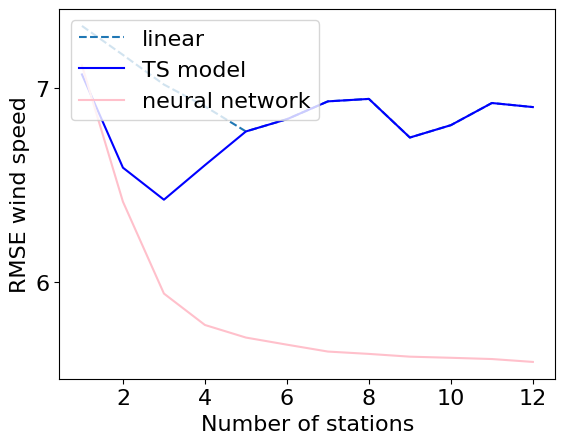

In [46]:
li_train_plot = []
fcm_train_plot = []
nn_train_plot = []
x_axis =  [1,2,3,4,5,6,7,8,9, 10,11,12]
for exp in training_results:
     li_train_plot.append(np.mean([d['linear_train'] for d in exp if 'linear_train' in d]))
     fcm_train_plot.append(np.mean([d['fcm_train'] for d in exp if 'fcm_train' in d]))
     nn_train_plot.append(np.mean([d['nn_train'] for d in exp if 'nn_train' in d]))
     #gpr_train_plot.append(np.mean([d['gpr_train'] for d in exp if 'nn_train' in d]))


# insert the optimal value from previous experiments 
# li_train_plot.insert(1, 6.7202)
# fcm_train_plot.insert(1, 6.6459)
# nn_train_plot.insert(1, 5.8963)

fig, ax = plt.subplots()
for axis in [ax.xaxis, ax.yaxis]:
    axis.set_major_locator(ticker.MaxNLocator(integer=True))
    
plt.plot(x_axis, li_train_plot, '--', label='linear')
plt.plot(x_axis, fcm_train_plot, label='TS model', c='blue')
plt.plot(x_axis, nn_train_plot, label='neural network', c='pink')
plt.legend(loc="upper left")
#plt.ylim(5)
plt.xlabel('Number of stations')
plt.ylabel('RMSE wind speed')
#plt.title('RMSE wind speed vs number of stations on training data')

for exp in training_results:
    print('exp')
    print(f"{np.round(np.mean([d['linear_train'] for d in exp if 'linear_train' in d]), 4)}±{np.round(np.std([d['linear_train'] for d in exp if 'linear_train' in d]),4)}")
    print(f"{np.round(np.mean([d['fcm_train'] for d in exp if 'fcm_train' in d]), 4)}±{np.round(np.std([d['fcm_train'] for d in exp if 'fcm_train' in d]),4)}")
    print(f"{np.round(np.mean([d['nn_train'] for d in exp if 'nn_train' in d]), 4)}±{np.round(np.std([d['nn_train'] for d in exp if 'nn_train' in d]),4)}")


In [44]:
test_results

[[{'linear_test': 7.3328376},
  {'fcm_test': 50.12633013758871},
  {'nn_test': 7.126054077148438},
  {'gpr_test': 724.5124372800911},
  {'linear_test': 7.3328366},
  {'fcm_test': 50.16594908035329},
  {'nn_test': 7.109055061340332},
  {'gpr_test': 770.792600240156},
  {'linear_test': 7.3328366},
  {'fcm_test': 50.239415841729674},
  {'nn_test': 7.121261119842529},
  {'gpr_test': 797.0349607214511},
  {'linear_test': 7.3328376},
  {'fcm_test': 50.234204248405675},
  {'nn_test': 7.122531471252441},
  {'gpr_test': 707.0465680487888},
  {'linear_test': 7.3328376},
  {'fcm_test': 50.186707582930325},
  {'nn_test': 7.121263217926026},
  {'gpr_test': 737.7197313470867},
  {'linear_test': 7.3328376},
  {'fcm_test': 50.196845091751875},
  {'nn_test': 7.125249462127686},
  {'gpr_test': 792.8331254409234},
  {'linear_test': 7.3328376},
  {'fcm_test': 50.21368757524504},
  {'nn_test': 7.126306629180908},
  {'gpr_test': 1519.760755792719},
  {'linear_test': 7.3328366},
  {'fcm_test': 50.16401702688

exp
7.332799911499023±0.0
7.0854±0.0032
7.123±0.0051
exp
7.180799961090088±0.0
6.5993±0.0054
6.4±0.0313
exp
7.0304999351501465±0.0
6.4392±0.0461
5.9292±0.0098
exp
6.915299892425537±0.0
6.6199±0.0179
5.7671±0.0033
exp
6.783999919891357±0.0
6.784±0.0
5.6984±0.0025
exp
6.853300094604492±0.0
6.8533±0.0
5.669±0.0064
exp
6.934899806976318±0.0
6.9349±0.0
5.6361±0.0056
exp
6.954400062561035±0.0
6.9544±0.0
5.624±0.0038
exp
6.748300075531006±0.0
6.7483±0.0
5.6106±0.0025
exp
6.820300102233887±0.0
6.8203±0.0
5.6121±0.0043
exp
6.937900066375732±0.0
6.9379±0.0
5.6074±0.0046
exp
6.923600196838379±0.0
6.9236±0.0
5.5908±0.006


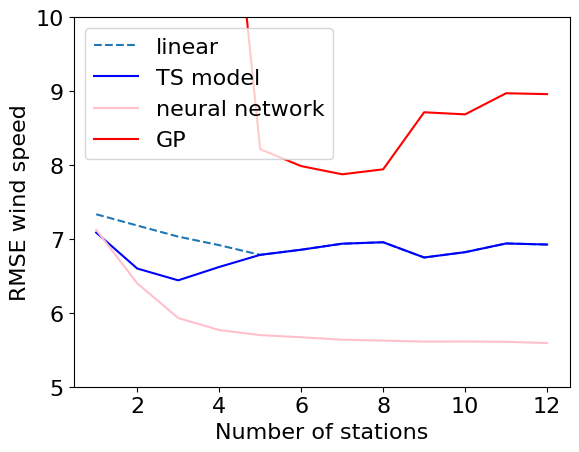

In [50]:
# The fcm testing data is MSE not RMSE

li_train_plot = []
fcm_train_plot = []
nn_train_plot = []
gpr_plot = []
x_axis =  [1,2,3,4,5,6,7,8,9, 10,11,12]
for exp in test_results:
     li_train_plot.append(np.mean([d['linear_test'] for d in exp if 'linear_test' in d]))
     fcm_train_plot.append(np.mean([np.sqrt(d['fcm_test']) for d in exp if 'fcm_test' in d]))
     gpr_plot.append(np.mean([d['gpr_test'] for d in exp if 'gpr_test' in d]))
     nn_train_plot.append(np.mean([d['nn_test'] for d in exp if 'nn_test' in d]))


fig, ax = plt.subplots()
for axis in [ax.xaxis, ax.yaxis]:
    axis.set_major_locator(ticker.MaxNLocator(integer=True))

# insert the optimal value from previous experiments 
# li_train_plot.insert(1, 6.7219)
# fcm_train_plot.insert(1, 6.6489)
# nn_train_plot.insert(1, 5.9011)


plt.plot(x_axis, li_train_plot, '--', label='linear')
plt.plot(x_axis, fcm_train_plot, label='TS model', c='blue')
plt.plot(x_axis, nn_train_plot, label='neural network', c='pink')
plt.plot(x_axis, gpr_plot, label='GP', c='red')
plt.legend(loc="upper left")
plt.ylim(5,10)
plt.xlabel('Number of stations')
plt.ylabel('RMSE wind speed')
#plt.title('RMSE wind speed vs number of stations on testing data')

for exp in test_results:
    print('exp')
    print(f"{np.round(np.mean([d['linear_test'] for d in exp if 'linear_test' in d]), 4)}±{np.round(np.std([d['linear_test'] for d in exp if 'linear_test' in d]),4)}")
    print(f"{np.round(np.mean([np.sqrt(d['fcm_test']) for d in exp if 'fcm_test' in d]), 4)}±{np.round(np.std([np.sqrt(d['fcm_test']) for d in exp if 'fcm_test' in d]),4)}")
    print(f"{np.round(np.mean([d['nn_test'] for d in exp if 'nn_test' in d]), 4)}±{np.round(np.std([d['nn_test'] for d in exp if 'nn_test' in d]),4)}")


Text(0.5, 1.0, 'Loss vs number of epoches')

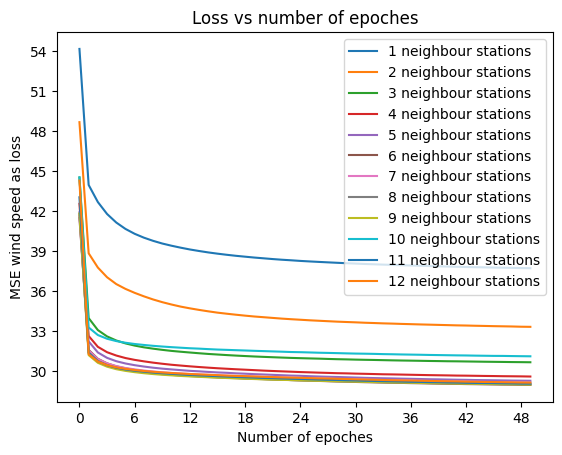

In [35]:
i = 1
fig, ax = plt.subplots()
for axis in [ax.xaxis, ax.yaxis]:
    axis.set_major_locator(ticker.MaxNLocator(integer=True))

for exp in nn_histories:
    nn_losses = []
    for fold in exp:
        nn_losses.append(fold['loss'])
    plt.plot(np.mean(nn_losses, axis=0), label=f"{i} neighbour stations")
    i = i+1


plt.legend(loc="upper right")
#plt.ylim(5)
plt.xlabel('Number of epoches')
plt.ylabel('MSE wind speed as loss')
plt.title('Loss vs number of epoches')

In [3]:
opt_x = pd.read_csv('Data/exp/5x_test.csv', index_col=0)
opt_y = pd.read_csv('Data/exp/5y_test.csv', index_col=0)

FCM traning RMSE: 8.16315534435806
FCM traning RMSE: 8.083711986919232
FCM traning RMSE: 7.970060591501671
FCM traning RMSE: 7.906636302399481
FCM traning RMSE: 7.878282731463363
FCM traning RMSE: 7.811867918051072
FCM traning RMSE: 7.733882628446361
FCM traning RMSE: 7.777428323862338
FCM traning RMSE: 7.714776222888085
FCM traning RMSE: 7.697975175523951
FCM traning RMSE: 7.681360151544759
FCM traning RMSE: 7.6623961272263
FCM traning RMSE: 7.6535745643432405


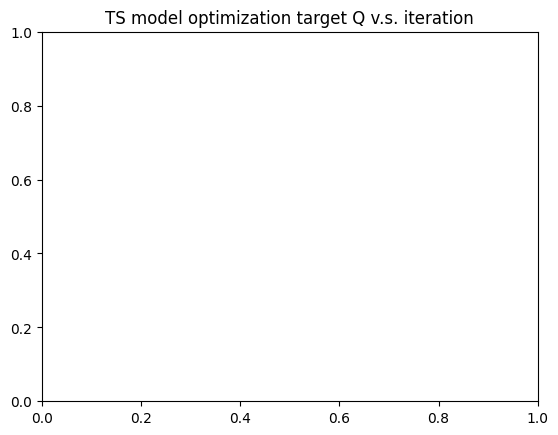

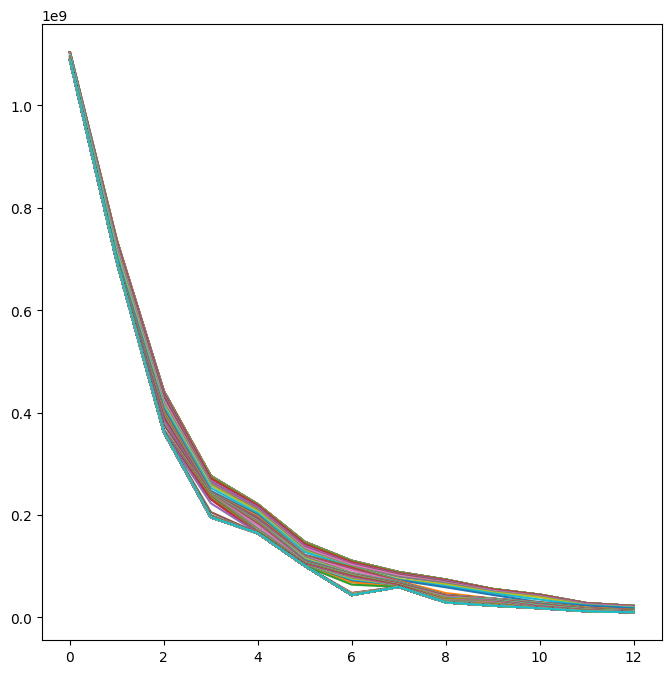

In [4]:
# Plot Q vs # of Nc
# Fcm hyperparameters
FCM_Ncs = [2,3,5,8,10,15,20,25,30,40,50,80,100]
FCM_m = 2
#tol = 1e-5
max_iter = 200
qs = []

for FCM_Nc in FCM_Ncs:   
    N = opt_x.shape[0]
    U = np.random.rand(N, FCM_Nc)
    U = U / np.sum(U, axis=1, keepdims=True)
    temp_qs = []

    # Fuzzy C-Means 聚类
    for _ in range(max_iter):
        U_old = U.copy()
        mf = U ** FCM_m
        cen = np.dot(mf.T, opt_x) / np.sum(mf, axis=0, keepdims=True).T
        dists = cdist(opt_x, cen)
        tmp = np.power(dists, -2 / (FCM_m - 1))
        U = tmp / np.sum(tmp, axis=1, keepdims=True)

        q = np.sum((U ** FCM_m) * (dists ** 2))
        temp_qs.append(q)

        # 检查是否收敛
#         if np.linalg.norm(U - U_old) < tol:
#             break
    # 模型训练 find if this can be optimized
    z = np.hstack((np.ones((N, 1)), opt_x))
    H = np.zeros((N, FCM_Nc * (opt_x.shape[1] + 1)))

    # 生成模糊规则矩阵 H
    for j in range(FCM_Nc):
        Uj = np.tile(U[:, j], (opt_x.shape[1] + 1, 1)).T
        H[:, (j * (opt_x.shape[1] + 1)):((j + 1) * (opt_x.shape[1] + 1))] = Uj * z

    # 计算权重 W
    W = pinv(np.dot(H.T, H)).dot(H.T).dot(opt_y)

        
    # 在训练集上进行预测
    y_hat_train = np.dot(H, W)
    mse_train = mean_squared_error(opt_y, y_hat_train)
    rmse_train = sqrt(mean_squared_error(opt_y, y_hat_train))
    print("FCM traning RMSE:", rmse_train)
    qs.append(temp_qs)
    
plt.title('TS model optimization target Q v.s. iteration')
plt.figure(figsize=(8,8))
plt.plot(qs)

Text(0.5, 1.0, 'TS model optimization target Q v.s. iteration for differenct number of rules')

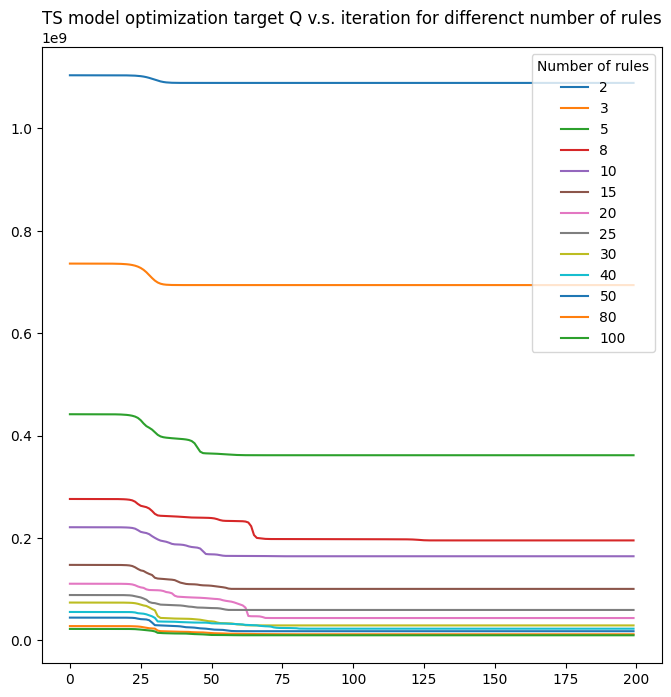

In [6]:
plt.figure(figsize=(8,8))

for exp in qs:
    plt.plot(exp)

plt.legend(FCM_Ncs, title="Number of rules")
plt.title('TS model optimization target Q v.s. iteration for differenct number of rules')